# CRAWL DATA

In [2]:
# =============================================================================
# DS108 RAINFALL PREDICTION PIPELINE - SETUP
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Import refactored modules
from src.data.crawler import NASAPowerCrawler
from src.data.loader import DataLoader  
from src.data.dataquality import assess_data_quality
from src.config.constants import Config

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

print("🌟 DS108 RAINFALL PREDICTION PIPELINE")
print("🎯 Goal: Predict rainfall for Ho Chi Minh City")
print("📅 Period: 25+ years of NASA POWER data")

🌟 DS108 RAINFALL PREDICTION PIPELINE
🎯 Goal: Predict rainfall for Ho Chi Minh City
📅 Period: 25+ years of NASA POWER data


In [3]:
# =============================================================================
# SECTION 1: DATA COLLECTION & LOADING
# =============================================================================

print("📊 SECTION 1: DATA COLLECTION & LOADING")

# Option 1: Load existing data 
loader = DataLoader()
df_raw = loader.load_data(rename_columns=False)

# Option 2: Crawl fresh data (uncomment if needed)
# crawler = NASAPowerCrawler()
# df_raw = crawler.crawl_data()

print(f"Raw data shape: {df_raw.shape if df_raw is not None else 'None'}")

📊 SECTION 1: DATA COLLECTION & LOADING
📂 LOADING WEATHER DATA
✅ Data loaded: (9252, 23)
📅 Date column converted
Raw data shape: (9252, 23)


In [4]:
# Apply Vietnamese column mapping and basic preprocessing
if df_raw is not None:
    df = df_raw.rename(columns=Config.COLUMN_MAPPING)
    
    # Convert date column
    date_col = 'Ngày'
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
    
    print(f"Processed data shape: {df.shape}")
    print(f"Date range: {df[date_col].min()} → {df[date_col].max()}")
    print(f"Weather parameters: {len([col for col in df.columns if col not in ['Ngày', 'Vĩ độ', 'Kinh độ']])}")
else:
    print("❌ Data loading failed")

Processed data shape: (9252, 23)
Date range: 2000-01-01 00:00:00 → 2025-04-30 00:00:00
Weather parameters: 20


# Thông tin bộ dữ liệu

**Dữ liệu NASA POWER API cho Thành phố Hồ Chí Minh**

**a) Chức năng (nội dung) của bộ dữ liệu là gì?**

Bộ dữ liệu này chứa thông tin khí tượng và bề mặt đất hàng ngày cho Thành phố Hồ Chí Minh, được thu thập tự động thông qua API NASA Prediction Of Worldwide Energy Resources (POWER). Dữ liệu bao gồm nhiều tham số quan trọng như:

*   **Nhiệt độ**: trung bình, tối thiểu, tối đa, điểm sương, bầu ướt, nhiệt độ bề mặt đất
*   **Độ ẩm**: tương đối, tuyệt đối  
*   **Lượng mưa**: mục tiêu dự đoán chính
*   **Áp suất bề mặt**
*   **Gió**: tốc độ trung bình, tối đa, hướng gió ở các độ cao khác nhau
*   **Bức xạ mặt trời**: bức xạ sóng dài xuống bề mặt
*   **Độ ẩm đất**: bề mặt, vùng rễ, toàn bộ mặt cắt

Dữ liệu được cung cấp cho mỗi ngày trong khoảng thời gian được chỉ định từ 01/01/2000 đến 30/04/2025, phục vụ mục tiêu dự đoán thời tiết cho toàn thành phố.

**b) Nguồn gốc của bộ dữ liệu?**

Dữ liệu gốc được cung cấp bởi dự án NASA POWER. Dữ liệu cụ thể trong bộ dữ liệu này được thu thập bằng cách gọi đến API công khai của NASA POWER:

*   **Nguồn dữ liệu:** NASA POWER (Prediction Of Worldwide Energy Resources)
*   **API Endpoint:** `https://power.larc.nasa.gov/api/temporal/daily/point`
*   **Phương pháp:** Single request crawl với 20 parameters (trong giới hạn API)
*   **Vị trí:** Tọa độ trung tâm TP.HCM (lat: 10.78, lon: 106.7)

**c) Cấu trúc các tập tin của bộ dữ liệu? Ý nghĩa từng tập tin.**

Dữ liệu sau khi thu thập được lưu trữ trong thư mục `nasa_power_hcmc_data` với cấu trúc đơn giản:

1.  **Tệp dữ liệu chính:**
    *   **Tên tệp:** `hcmc_weather_data_{Ngày_Bắt_Đầu}_{Ngày_Kết_Thúc}.csv`
    *   **Nội dung:** Chứa dữ liệu hàng ngày của tất cả 20 tham số khí tượng cho TP.HCM trong khoảng thời gian xác định. Mỗi hàng đại diện cho một ngày.

**d) Các thông tin nào mà các record (bản ghi) lưu trữ?**

Mỗi record (hàng trong tệp CSV) tương ứng với dữ liệu của một ngày cho TP.HCM và chứa các cột sau:

**Thông tin địa lý và thời gian:**
*   **DATE:** Ngày ghi nhận dữ liệu (định dạng datetime)
*   **LATITUDE:** Vĩ độ điểm đại diện TP.HCM (10.78)
*   **LONGITUDE:** Kinh độ điểm đại diện TP.HCM (106.7)

**Nhóm 1 - Nhiệt độ, độ ẩm, mưa, áp suất (11 chỉ số):**
*   **PRECTOTCORR:** Lượng mưa đã hiệu chỉnh (mm/ngày) - *Biến mục tiêu*
*   **QV2M:** Độ ẩm tuyệt đối ở 2m (g/kg)
*   **RH2M:** Độ ẩm tương đối ở 2m (%)
*   **T2M:** Nhiệt độ trung bình ở 2m (°C)
*   **T2MDEW:** Điểm sương/sương giá ở 2m (°C)
*   **T2MWET:** Nhiệt độ bầu ướt ở 2m (°C)
*   **T2M_MAX:** Nhiệt độ tối đa ở 2m (°C)
*   **TS:** Nhiệt độ bề mặt đất (°C)
*   **T2M_MIN:** Nhiệt độ tối thiểu ở 2m (°C)
*   **ALLSKY_SFC_LW_DWN:** Bức xạ sóng dài xuống bề mặt (MJ/m²/ngày)
*   **PS:** Áp suất bề mặt (kPa)

**Nhóm 2 - Gió và độ ẩm đất (9 chỉ số):**
*   **WS10M:** Tốc độ gió ở 10m (m/s)
*   **WD10M:** Hướng gió ở 10m (Độ)
*   **WS10M_MAX:** Tốc độ gió tối đa ở 10m (m/s)
*   **WS2M_MAX:** Tốc độ gió tối đa ở 2m (m/s)
*   **WS2M:** Tốc độ gió ở 2m (m/s)
*   **WD2M:** Hướng gió ở 2m (Độ)
*   **GWETPROF:** Độ ẩm đất theo mặt cắt (tỷ lệ 0-1)
*   **GWETTOP:** Độ ẩm bề mặt đất (tỷ lệ 0-1)
*   **GWETROOT:** Độ ẩm vùng rễ (tỷ lệ 0-1)

**Ghi chú quan trọng:**
- Giá trị `-999` biểu thị dữ liệu thiếu hoặc không thể tính toán
- Dữ liệu được crawl trong 1 lần duy nhất với 20 parameters (tuân thủ giới hạn API)
- Tổng cộng có 20 weather parameters + 3 metadata columns cho việc dự đoán thời tiết TP.HCM

### Tham khảo

*   **NASA POWER Data Access Viewer:** [https://power.larc.nasa.gov/data-access-viewer/](https://power.larc.nasa.gov/data-access-viewer/)
*   **NASA POWER Documentation:** [https://power.larc.nasa.gov/docs/](https://power.larc.nasa.gov/docs/)
*   **NASA POWER API Documentation:** [https://power.larc.nasa.gov/docs/services/api/](https://power.larc.nasa.gov/docs/services/api/)

# Data Quality Assessment

In [5]:
# =============================================================================
# SECTION 2: DATA QUALITY ASSESSMENT
# =============================================================================

print("🔍 SECTION 2: DATA QUALITY ASSESSMENT")

# Run comprehensive quality assessment
quality_results = assess_data_quality(df, target_col='Lượng mưa')

# Display results
print(f"\nQuality Assessment Results:")
for section, results in quality_results.items():
    print(f"{section}: {results}")

🔍 SECTION 2: DATA QUALITY ASSESSMENT
🔍 DATA QUALITY ASSESSMENT
📊 Dataset: (9252, 23)
❓ Missing data: 0.00%
🔄 Duplicates: 0 rows (0.00%)
🏆 Quality Score: 100/100

Quality Assessment Results:
basic_info: {'shape': (9252, 23), 'memory_mb': 1.6236305236816406, 'columns': ['Lượng mưa', 'Độ ẩm tuyệt đối 2m', 'Độ ẩm tương đối 2m', 'Nhiệt độ 2m', 'Điểm sương 2m', 'Nhiệt độ bầu ướt 2m', 'Nhiệt độ tối đa 2m', 'Nhiệt độ bề mặt đất', 'Nhiệt độ tối thiểu 2m', 'Bức xạ sóng dài xuống', 'Áp suất bề mặt', 'Tốc độ gió 10m', 'Hướng gió 10m', 'Tốc độ gió tối đa 10m', 'Tốc độ gió tối đa 2m', 'Tốc độ gió 2m', 'Hướng gió 2m', 'Độ ẩm đất mặt cắt', 'Độ ẩm đất bề mặt', 'Độ ẩm đất vùng rễ', 'Ngày', 'Vĩ độ', 'Kinh độ']}
missing_data: {'total_missing': 0, 'missing_percentage': 0.0, 'columns_with_missing': {}}
duplicates: {'duplicate_rows': 0, 'duplicate_percentage': 0.0}
data_types: {'float64': 22, 'datetime64[ns]': 1}
target_variable: {'exists': True, 'missing_count': 0, 'missing_percentage': 0.0, 'min_value': 0.

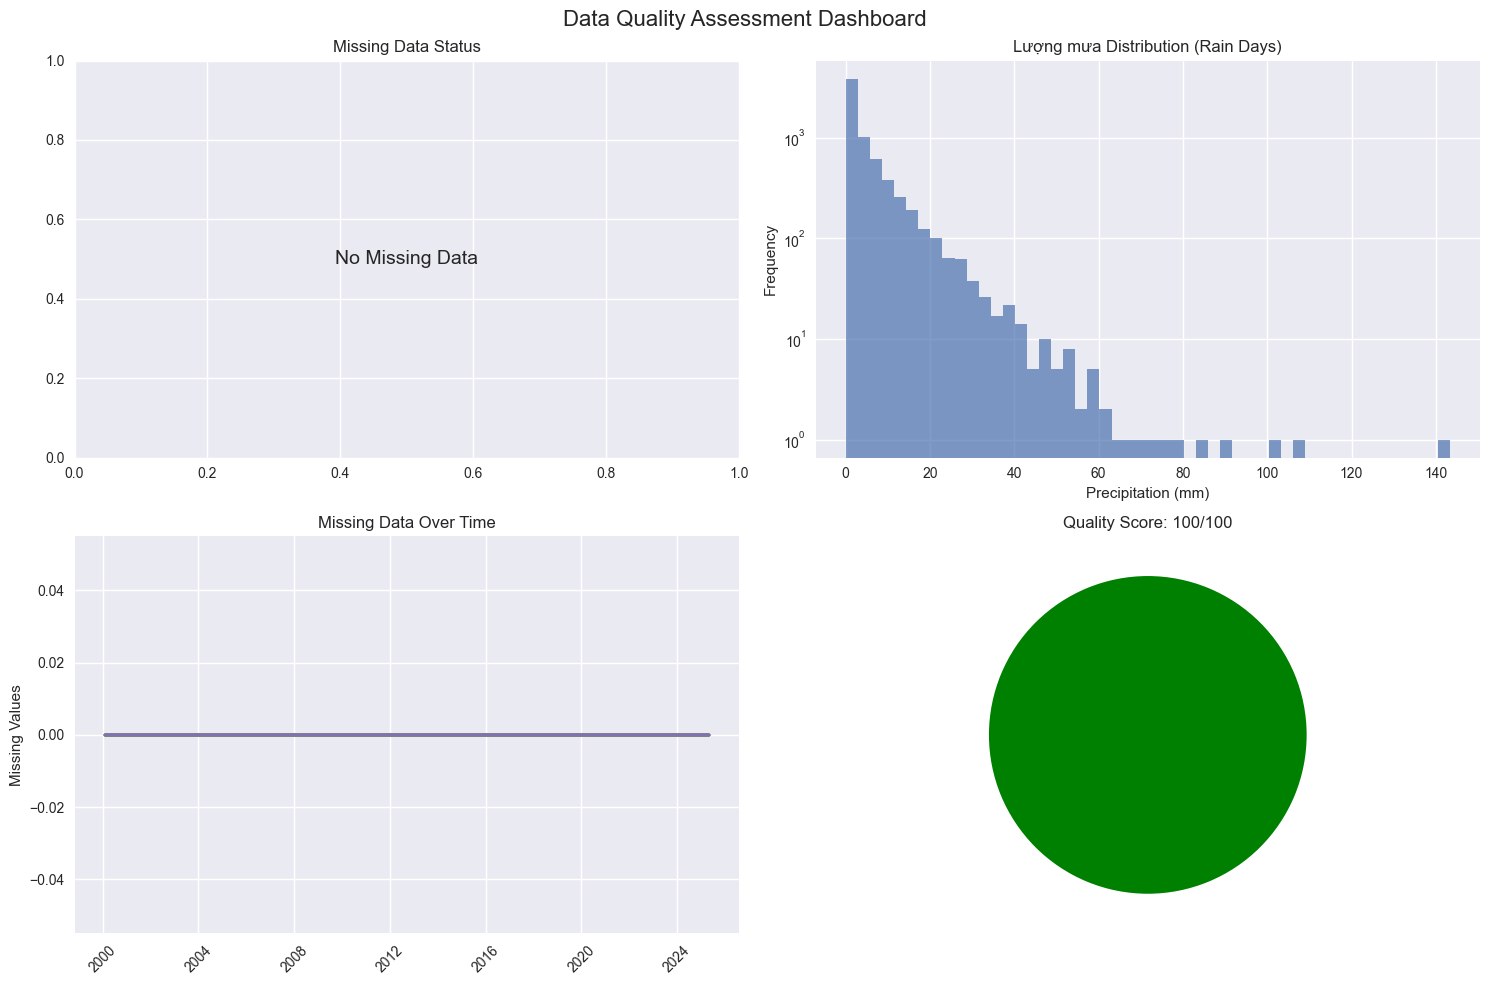

In [6]:
# Create quality assessment dashboard
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Data Quality Assessment Dashboard', fontsize=16)

# Missing data
missing_data = quality_results['missing_data']
if missing_data['columns_with_missing']:
    missing_df = pd.DataFrame(list(missing_data['columns_with_missing'].items()), 
                             columns=['Column', 'Missing_Count'])
    missing_df['Missing_Percentage'] = (missing_df['Missing_Count'] / len(df)) * 100
    
    axes[0,0].bar(range(len(missing_df)), missing_df['Missing_Percentage'])
    axes[0,0].set_title('Missing Data by Column')
    axes[0,0].set_ylabel('Missing %')
    axes[0,0].set_xticks(range(len(missing_df)))
    axes[0,0].set_xticklabels(missing_df['Column'], rotation=45, ha='right')
else:
    axes[0,0].text(0.5, 0.5, 'No Missing Data', ha='center', va='center', 
                   transform=axes[0,0].transAxes, fontsize=14)
    axes[0,0].set_title('Missing Data Status')

# Target variable distribution
target_col = 'Lượng mưa'
if target_col in df.columns:
    target_data = df[target_col].dropna()
    axes[0,1].hist(target_data[target_data > 0], bins=50, alpha=0.7)
    axes[0,1].set_title(f'{target_col} Distribution (Rain Days)')
    axes[0,1].set_xlabel('Precipitation (mm)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_yscale('log')

# Data completeness over time
df_monthly = df.set_index('Ngày').resample('M').apply(lambda x: x.isnull().sum().sum())
axes[1,0].plot(df_monthly.index, df_monthly.values)
axes[1,0].set_title('Missing Data Over Time')
axes[1,0].set_ylabel('Missing Values')
axes[1,0].tick_params(axis='x', rotation=45)

# Quality score
overall_score = quality_results['overall_score']
axes[1,1].pie([overall_score, 100-overall_score], 
              colors=['green' if overall_score >= 80 else 'orange' if overall_score >= 70 else 'red', 'lightgray'],
              startangle=90)
axes[1,1].set_title(f'Quality Score: {overall_score}/100')

plt.tight_layout()
plt.show()

# Time Series Analysis

## Distribution Analysis

📊 SECTION 3: DISTRIBUTION ANALYSIS
🚀 STARTING COMPREHENSIVE DISTRIBUTION ANALYSIS
📊 DISTRIBUTION ANALYSIS INITIALIZED
   - Total Features: 22
   - Analysis Features: 20
   - Target Variable: Lượng mưa
   - Sample Size: 9,252

📋 5. DISTRIBUTION ANALYSIS SUMMARY REPORT

📈 1. DESCRIPTIVE STATISTICS SUMMARY
📊 Comprehensive Descriptive Statistics:

🔢 Basic Statistics:
              Feature  Count     Mean  Median   Mode     Std   Min    Max
            Lượng mưa   9252   3.9293    0.65   0.00  7.6473  0.00 143.31
   Độ ẩm tuyệt đối 2m   9252  17.2692   18.15  19.11  2.3491  8.14  21.47
   Độ ẩm tương đối 2m   9252  77.6260   82.49  88.46 12.4275 40.84  95.49
          Nhiệt độ 2m   9252  27.4593   27.01  26.91  1.9548 19.89  34.30
        Điểm sương 2m   9252  22.5162   23.50  24.35  2.4122 10.82  26.26
  Nhiệt độ bầu ướt 2m   9252  24.9877   25.30  25.27  1.4066 17.23  28.29
   Nhiệt độ tối đa 2m   9252  32.4488   31.23  30.24  3.5078 23.01  42.93
  Nhiệt độ bề mặt đất   9252  28.0657   27

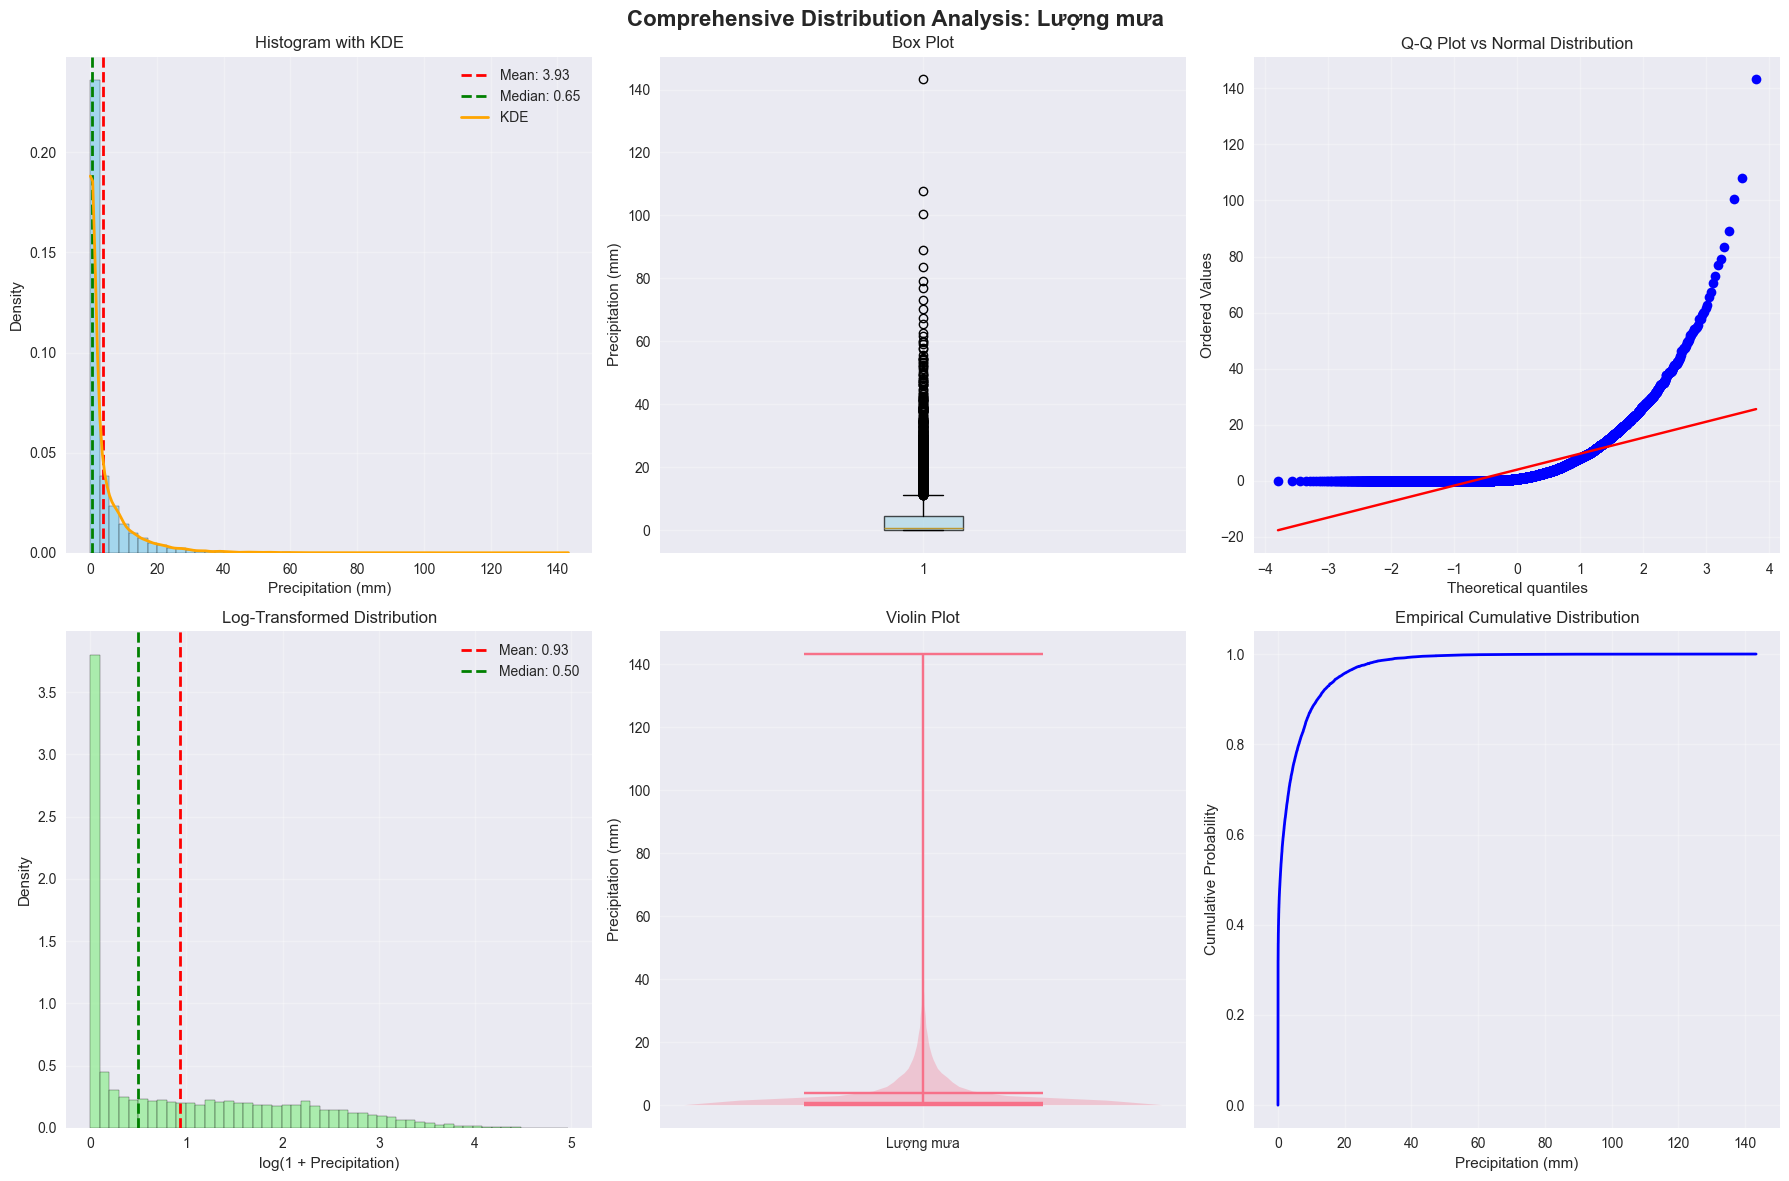


📊 Creating distribution overview for all features...


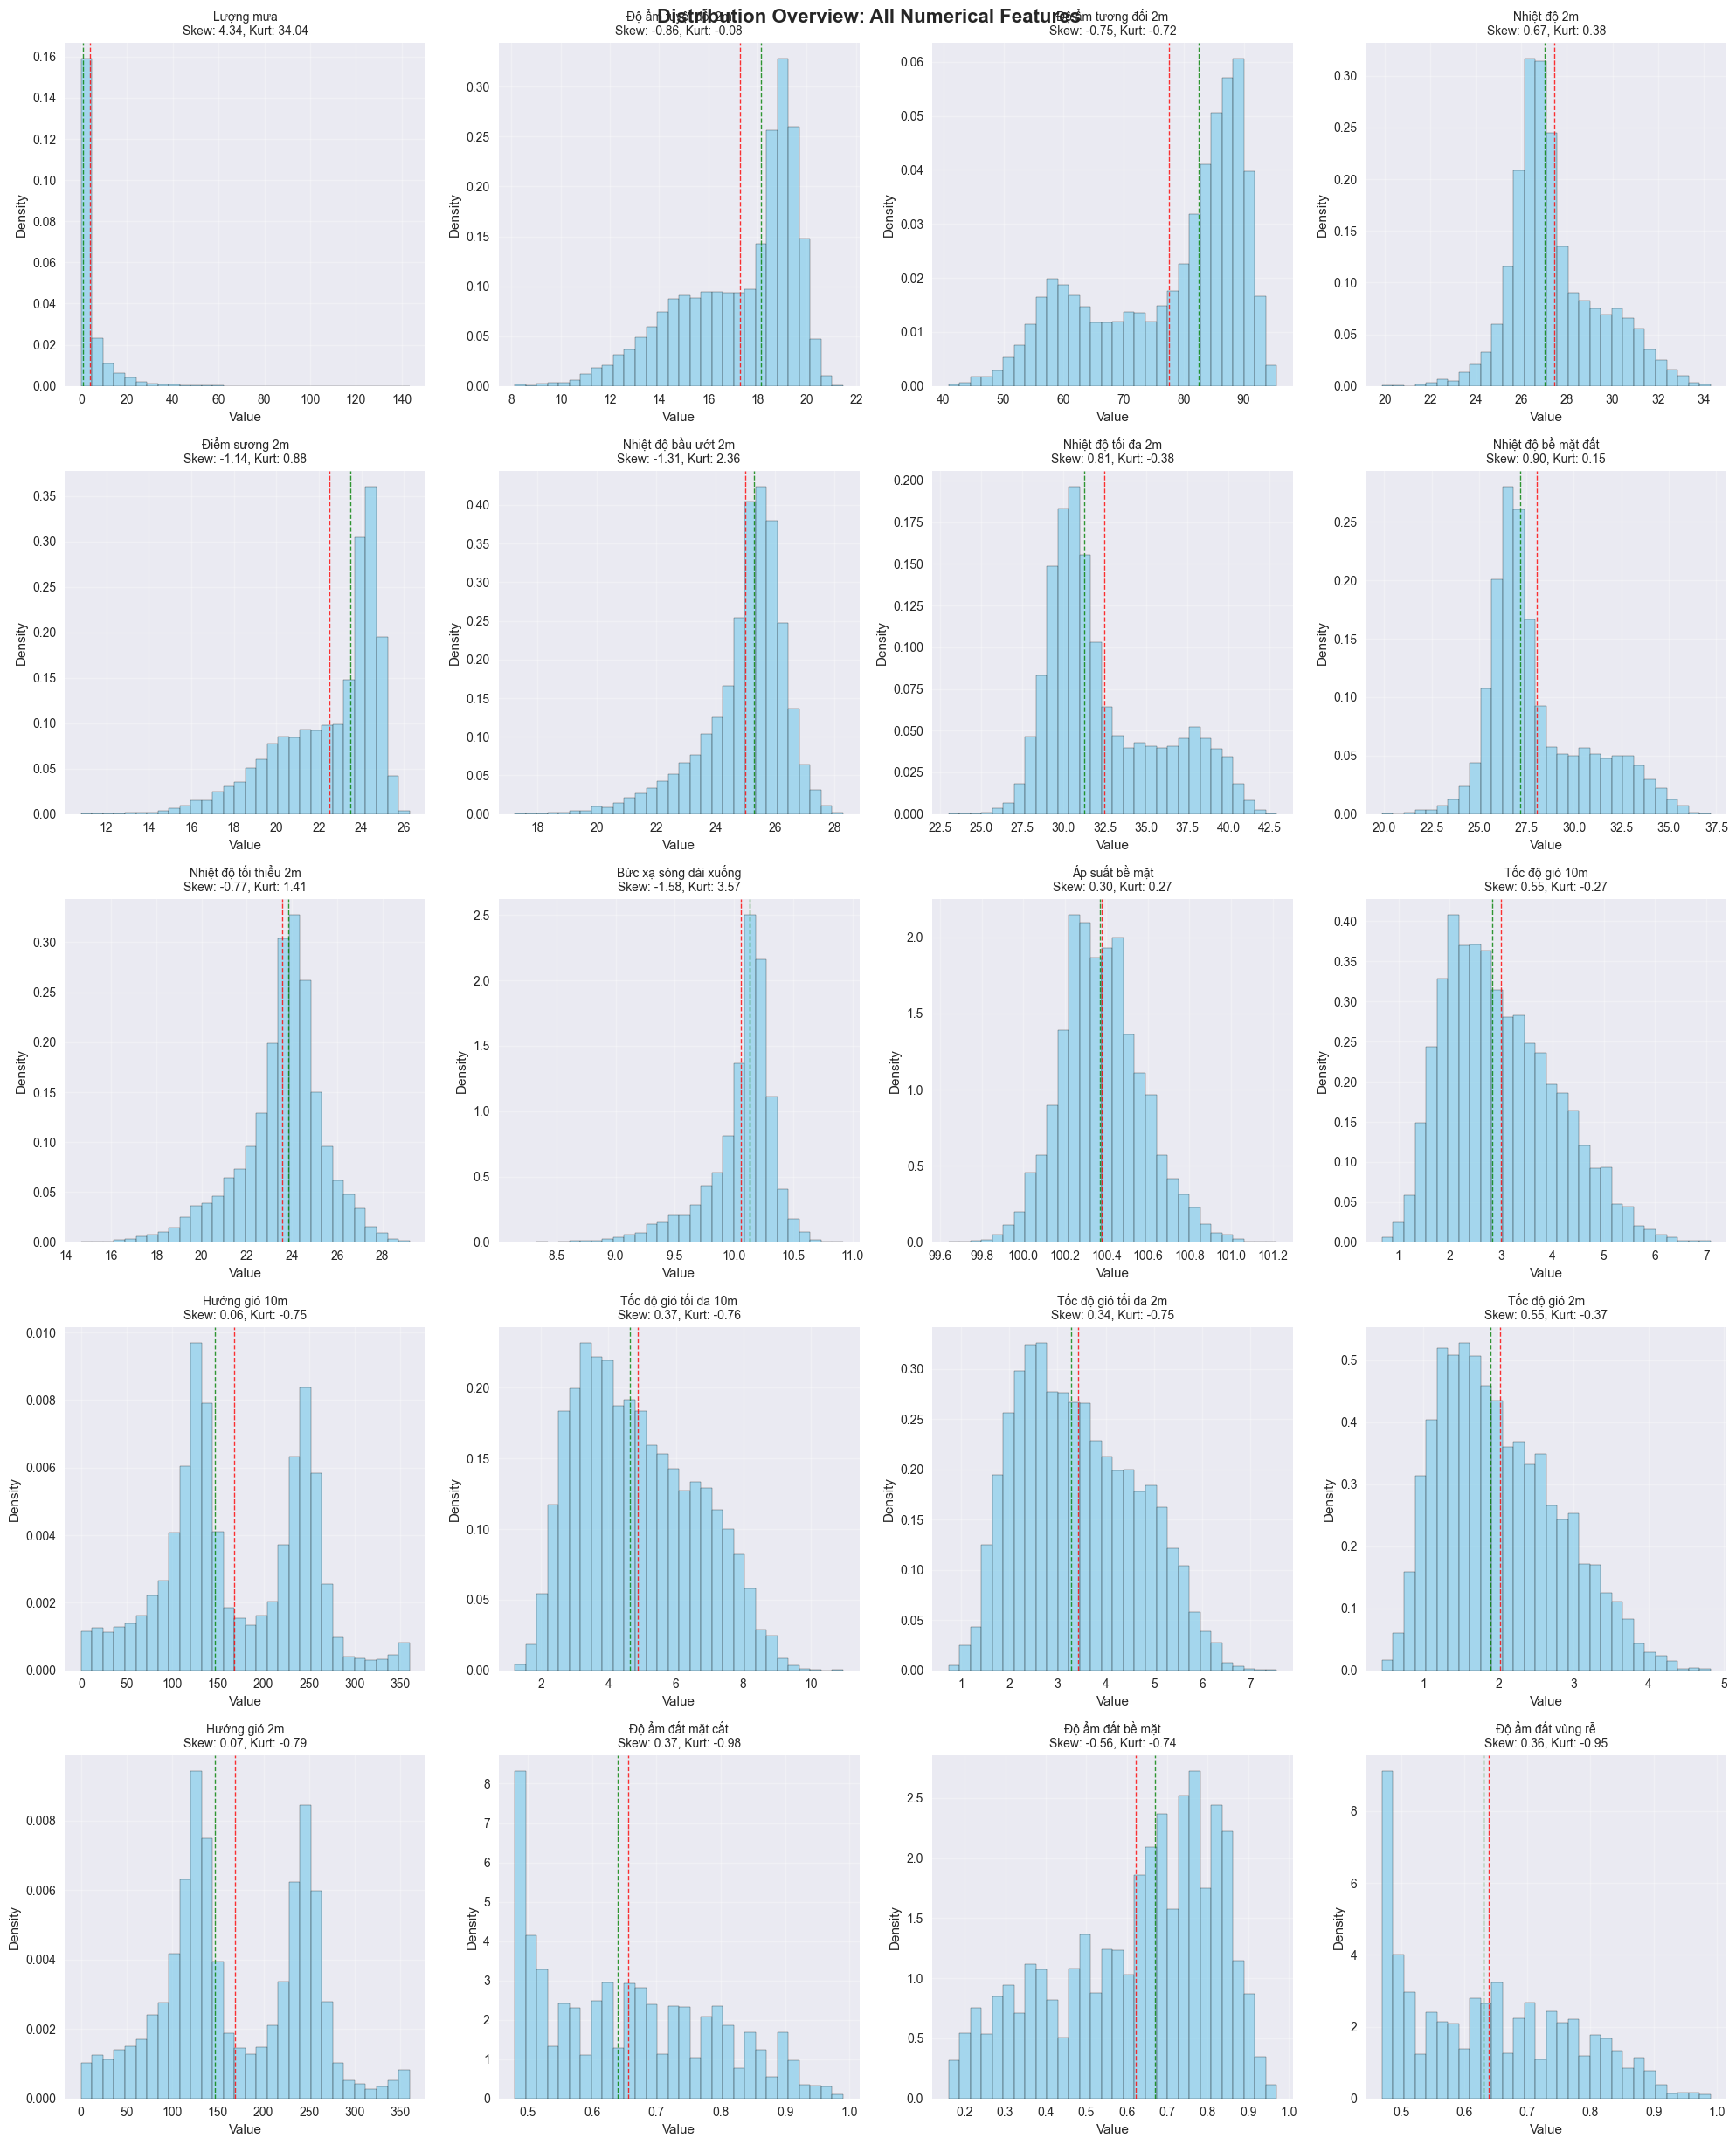


📐 Creating skewness and kurtosis comparison...


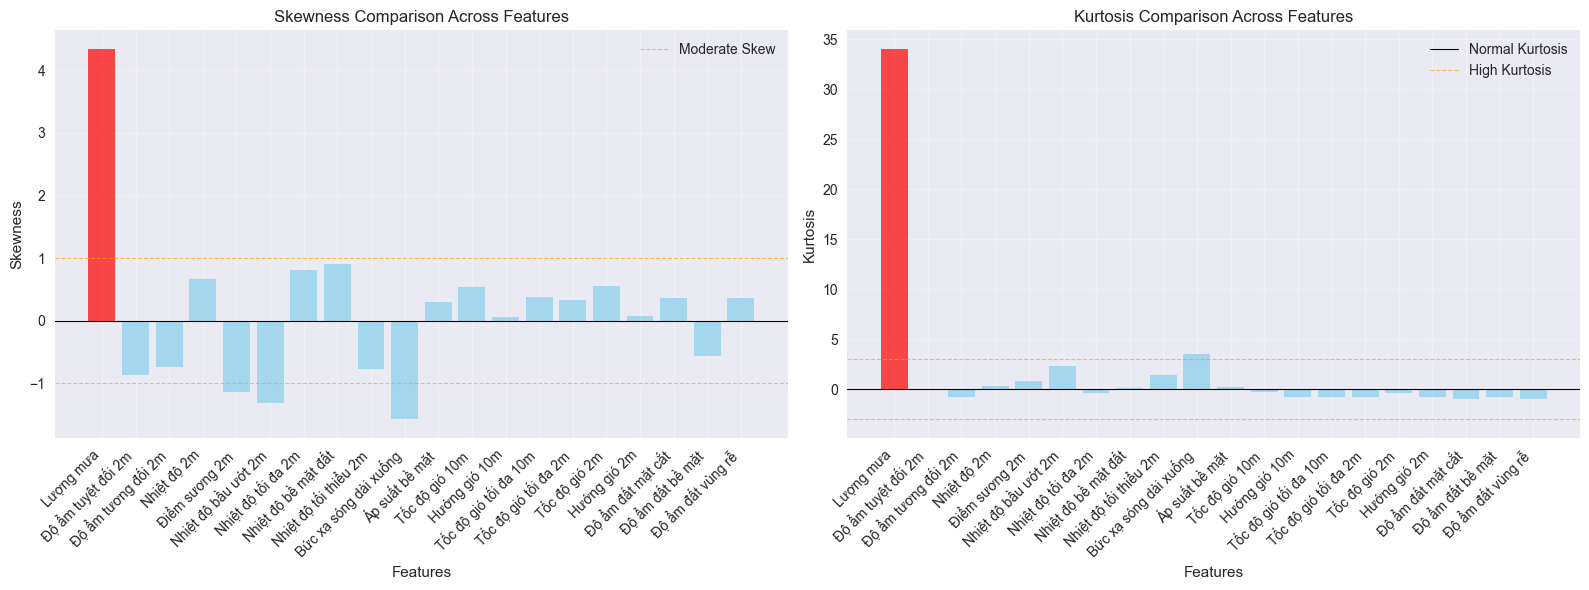


✅ DISTRIBUTION ANALYSIS COMPLETED

📋 DISTRIBUTION ANALYSIS SUMMARY:
   - target_skewness: 4.336759396909124
   - zero_rain_percentage: 25.73497622135754
   - normal_features_count: 0
   - high_skew_features: ['Lượng mưa', 'Điểm sương 2m', 'Nhiệt độ bầu ướt 2m', 'Bức xạ sóng dài xuống']


In [7]:
# =============================================================================
# SECTION 3: DISTRIBUTION ANALYSIS (USING REFACTORED MODULE)
# =============================================================================

print("📊 SECTION 3: DISTRIBUTION ANALYSIS")

# Import refactored Distribution Analysis module
from src.analysis.DistributionAnalysis import analyze_distributions

# Run comprehensive distribution analysis with visualization
distribution_results = analyze_distributions(
    df=df, 
    target_col='Lượng mưa',
    include_visualization=True
)

# Display summary insights
print("\n📋 DISTRIBUTION ANALYSIS SUMMARY:")
for key, value in distribution_results['summary_insights'].items():
    print(f"   - {key}: {value}")

## Extreme Event Explore

⛈️ SECTION 4: EXTREME EVENT ANALYSIS

⛈️ COMPONENT 2: EXTREME EVENTS ANALYSIS
🔍 2.1 Extreme Events Definition
--------------------------------------------------
   📊 Extreme Event Thresholds:
      - 95th percentile: 18.45mm
      - 99th percentile: 34.86mm
      - 99.9th percentile: 67.01mm

   📈 Extreme Event Counts:
      - > 95th percentile: 463 events (5.00%)
      - > 99th percentile: 93 events (1.01%)
      - > 99.9th percentile: 10 events (0.11%)

🌪️ 2.2 Seasonal Patterns of Extreme Events
--------------------------------------------------


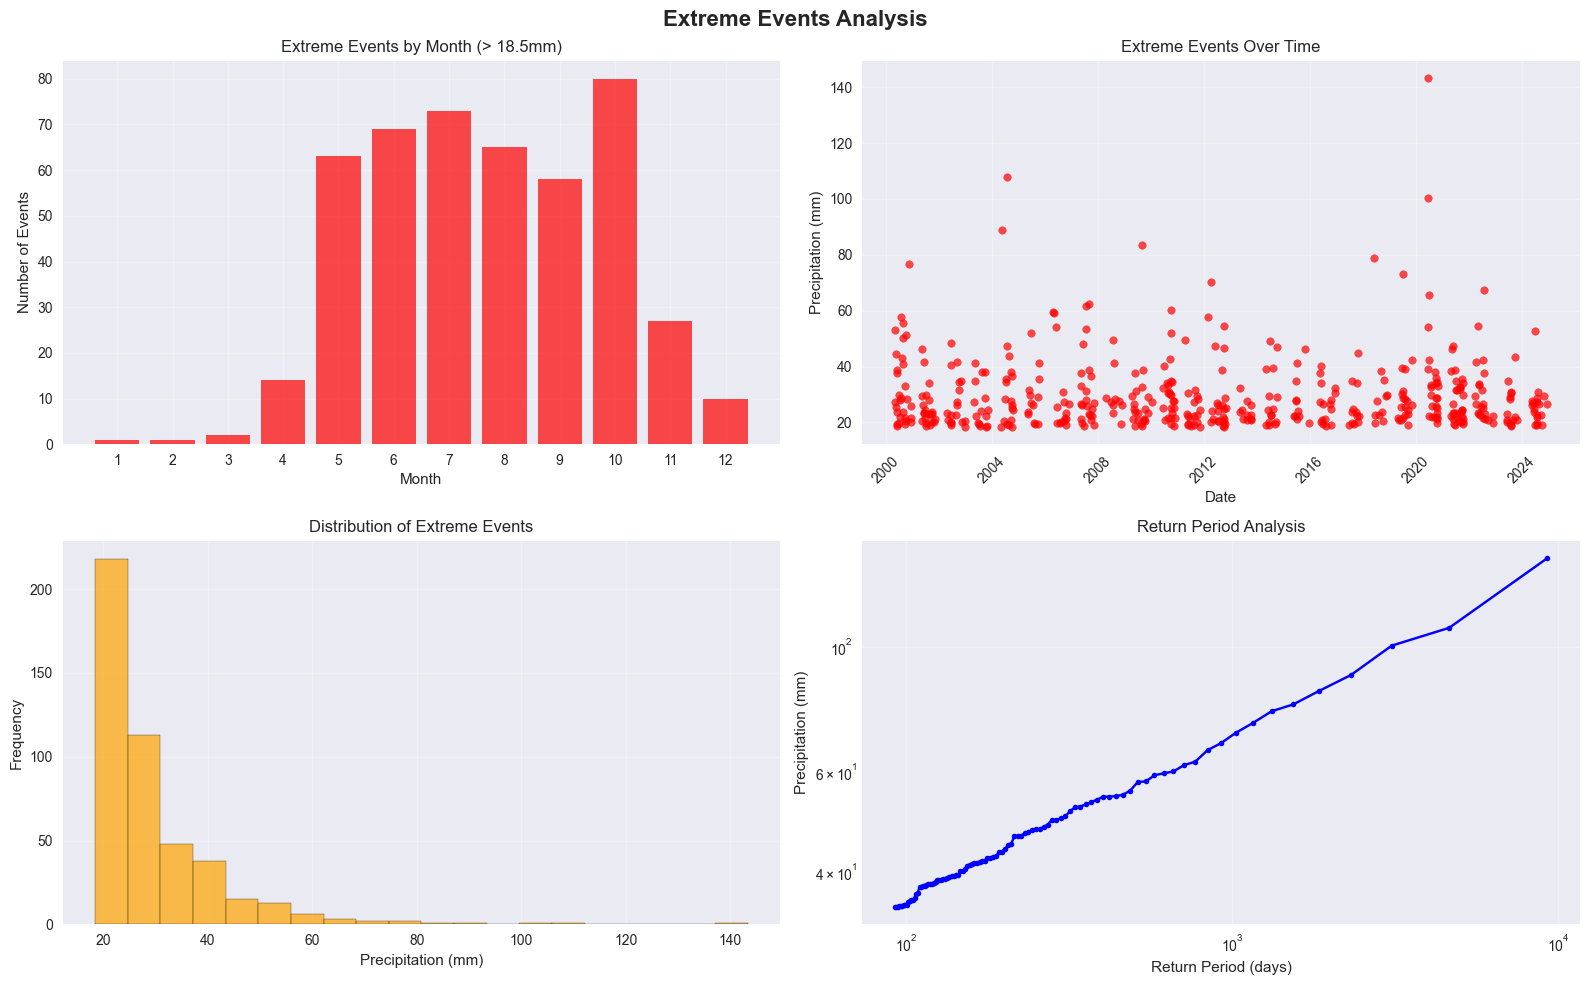

   📅 Peak extreme events month: 10

✅ EXTREME EVENTS ANALYSIS COMPLETED

📋 EXTREME EVENT ANALYSIS SUMMARY:
📊 Extreme Event Thresholds:
   - 95th percentile: 18.45mm
   - 99th percentile: 34.86mm
   - 99.9th percentile: 67.01mm

📈 Extreme Event Counts:
   - > 95th percentile: 463 events (5.00%)
   - > 99th percentile: 93 events (1.01%)
   - > 99.9th percentile: 10 events (0.11%)

📅 Seasonal Insights:
   - Peak extreme events month: Oct
   - Total extreme events analyzed: 463


In [8]:
# =============================================================================
# SECTION 4: EXTREME EVENT ANALYSIS (USING REFACTORED MODULE)
# =============================================================================

print("⛈️ SECTION 4: EXTREME EVENT ANALYSIS")

# Import refactored Extreme Event Analysis module  
from src.analysis.ExtremeEventAnalysis import analyze_extreme_events

# Run comprehensive extreme events analysis
extreme_results = analyze_extreme_events(
    df=df,
    target_col='Lượng mưa', 
    date_col='Ngày'
)

# Display summary results
if extreme_results['success']:
    print("\n📋 EXTREME EVENT ANALYSIS SUMMARY:")
    
    # Display thresholds
    thresholds = extreme_results['extreme_definition']['thresholds']
    print(f"📊 Extreme Event Thresholds:")
    print(f"   - 95th percentile: {thresholds['p95']:.2f}mm")
    print(f"   - 99th percentile: {thresholds['p99']:.2f}mm") 
    print(f"   - 99.9th percentile: {thresholds['p99_9']:.2f}mm")
    
    # Display counts
    counts = extreme_results['extreme_definition']['extreme_counts']
    total = extreme_results['extreme_definition']['total_records']
    print(f"\n📈 Extreme Event Counts:")
    print(f"   - > 95th percentile: {counts['p95']} events ({counts['p95']/total*100:.2f}%)")
    print(f"   - > 99th percentile: {counts['p99']} events ({counts['p99']/total*100:.2f}%)")
    print(f"   - > 99.9th percentile: {counts['p99_9']} events ({counts['p99_9']/total*100:.2f}%)")
    
    # Display seasonal patterns
    if extreme_results['seasonal_patterns']['success']:
        peak_month = extreme_results['seasonal_patterns']['peak_month']
        if peak_month:
            month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                          7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
            print(f"\n📅 Seasonal Insights:")
            print(f"   - Peak extreme events month: {month_names.get(peak_month, peak_month)}")
            print(f"   - Total extreme events analyzed: {extreme_results['seasonal_patterns']['total_extreme_events']}")
else:
    print(f"❌ Extreme Event Analysis failed: {extreme_results.get('error', 'Unknown error')}")

## Temporal Structure & Seasonality

### ANALYZER INITIALIZATION

In [9]:
from src.analysis.TemporalAnalysis import TemporalStructureAnalyzer
from src.config.constants import Config

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

print("🕐 TEMPORAL STRUCTURE ANALYSIS")
print("=" * 50)

# Initialize Temporal Analyzer
temporal_analyzer = TemporalStructureAnalyzer(
    df=df,  # Assuming df is your preprocessed dataframe
    target_col='Lượng mưa',
    date_col='Ngày'
)

print(f"✅ Temporal Analyzer initialized")
print(f"   📊 Data shape: {temporal_analyzer.df.shape}")
print(f"   📅 Date range: {temporal_analyzer.df[temporal_analyzer.date_col].min()} → {temporal_analyzer.df[temporal_analyzer.date_col].max()}")
print(f"   🎯 Target column: {temporal_analyzer.target_col}")

🕐 TEMPORAL STRUCTURE ANALYSIS
✅ Temporal Analyzer initialized
   📊 Data shape: (9252, 26)
   📅 Date range: 2000-01-01 00:00:00 → 2025-04-30 00:00:00
   🎯 Target column: Lượng mưa


### SEASONAL PATTERNS ANALYSIS

### 

🔍 Analyzing Seasonal Patterns
   - Time units: ['Month', 'DayOfYear', 'Year']
   - Aggregations: ['mean', 'std', 'median', 'count']
   - Quantile threshold: 0.5
   ✅ Seasonal analysis completed


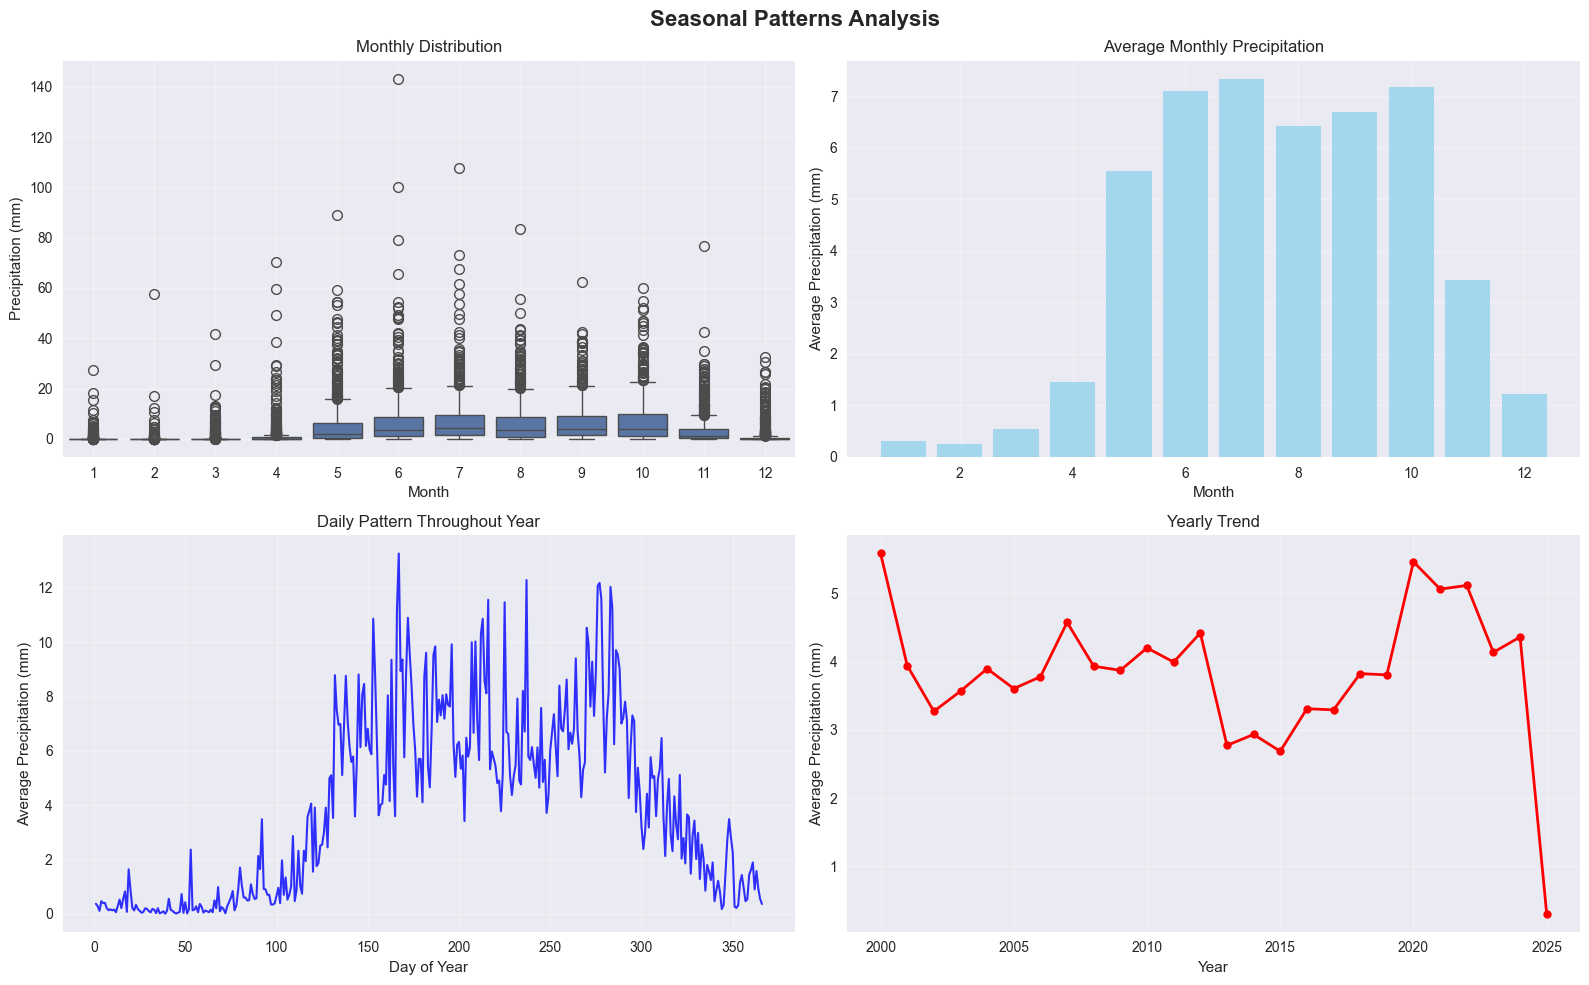

🌧️ Wet Season (>50th percentile): [5, 6, 7, 8, 9, 10]
☀️ Dry Season (<50th percentile): [1, 2, 3, 4, 11, 12]


In [10]:
# =============================================================================
# TEMPORAL ANALYSIS 1: SEASONAL PATTERNS
# =============================================================================

# Analysis with parameter tuning
seasonal_results = temporal_analyzer.analyze_seasonal_patterns(
    time_units=['Month', 'DayOfYear', 'Year'],  # Các đơn vị thời gian phân tích
    agg_functions=['mean', 'std', 'median', 'count'],  # Thống kê tính toán
    quantile_threshold=0.5  # Ngưỡng phân biệt mùa mưa/khô (50th percentile)
)

# Visualization
temporal_analyzer.plot_seasonal_patterns(
    seasonal_results=seasonal_results,
    figsize=(16, 10),
    color_scheme='default',
    show_grid=True
)

### FFT FREQUENCY ANALYSIS

🔊 Enhanced FFT Frequency Analysis
   - Detrend window: 365
   - Top periods to find: 50
   - Period range: (1, 730)
   - Dominant periods to return: 20
   📊 Found 39 total dominant periods
   📊 Returning top 20 dominant periods:
      1. 494 days
      2. 423 days
      3. 404 days
      4. 386 days
      5. 370 days
      6. 356 days
      7. 342 days
      8. 329 days
      9. 278 days
      10. 261 days
      11. 185 days
      12. 178 days
      13. 122 days
      14. 97 days
      15. 75 days
      16. 73 days
      17. 72 days
      18. 63 days
      19. 60 days
      20. 45 days
   📊 Displaying 20 dominant periods in bar chart


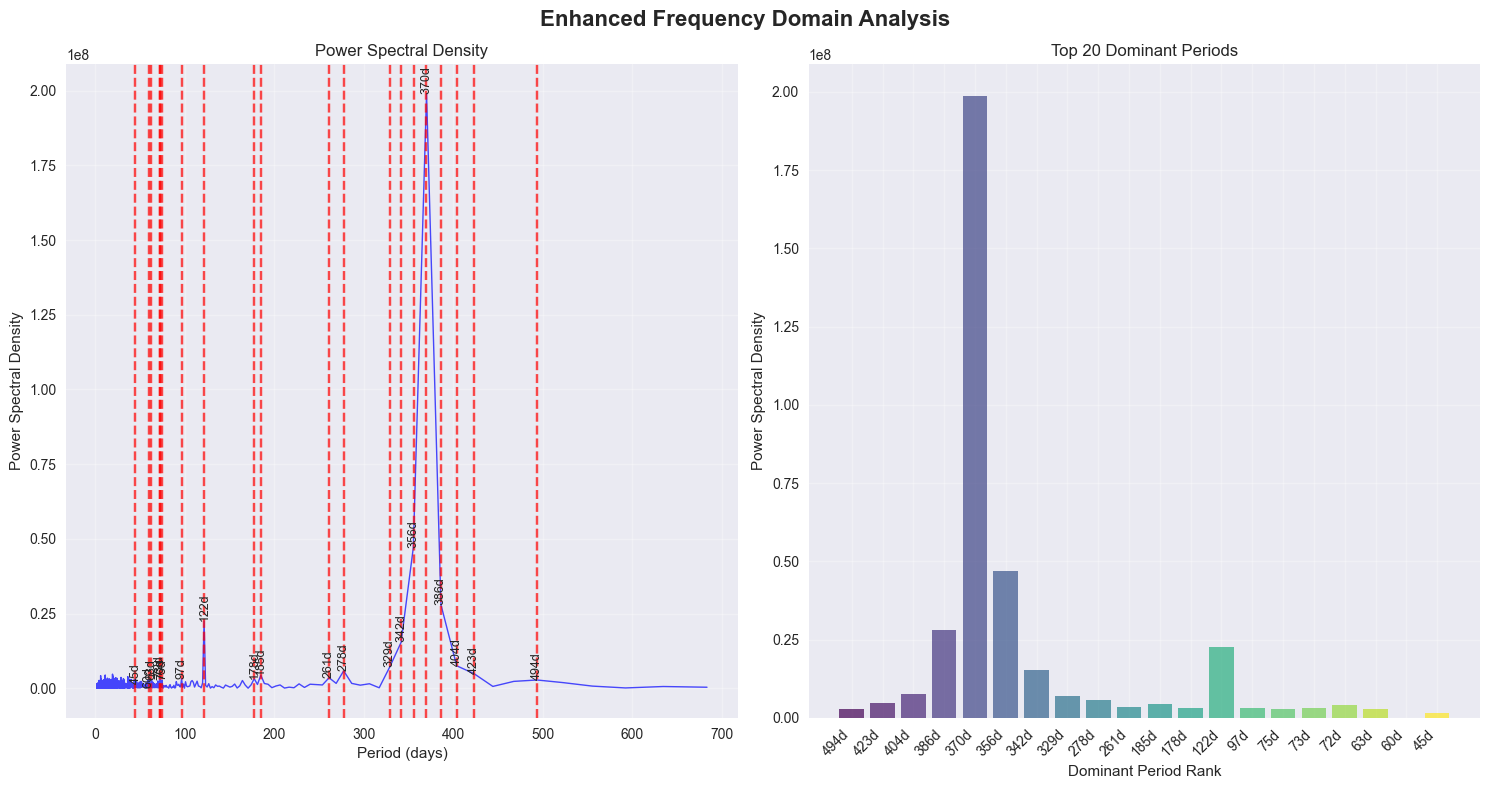

In [11]:
# =============================================================================
# TEMPORAL ANALYSIS 2: FFT FREQUENCY ANALYSIS
# =============================================================================

# Analysis with parameter tuning for Vietnam weather patterns
fft_results_365 = temporal_analyzer.analyze_fft(
    detrend_window=365,  
    top_n=50,  
    period_range=(1, 730),
    return_n_dominant=20 
)

# Visualization
temporal_analyzer.plot_spectrum(
    fft_results=fft_results_365,
    figsize=(15, 8),
    show_dominant=True,
    max_period=730,  
    log_scale=False,
    bar_chart_periods=20 
)

🔊 Enhanced FFT Frequency Analysis
   - Detrend window: 180
   - Top periods to find: 20
   - Period range: (1, 730)
   - Dominant periods to return: 20
   📊 Found 18 total dominant periods
   📊 Returning top 18 dominant periods:
      1. 363 days
      2. 178 days
      3. 123 days
      4. 121 days
      5. 119 days
      6. 108 days
      7. 97 days
      8. 73 days
      9. 60 days
      10. 50 days
      11. 32 days
      12. 29 days
      13. 24 days
      14. 19 days
      15. 16 days
      16. 15 days
      17. 7 days
      18. 6 days
   📊 Displaying 18 dominant periods in bar chart


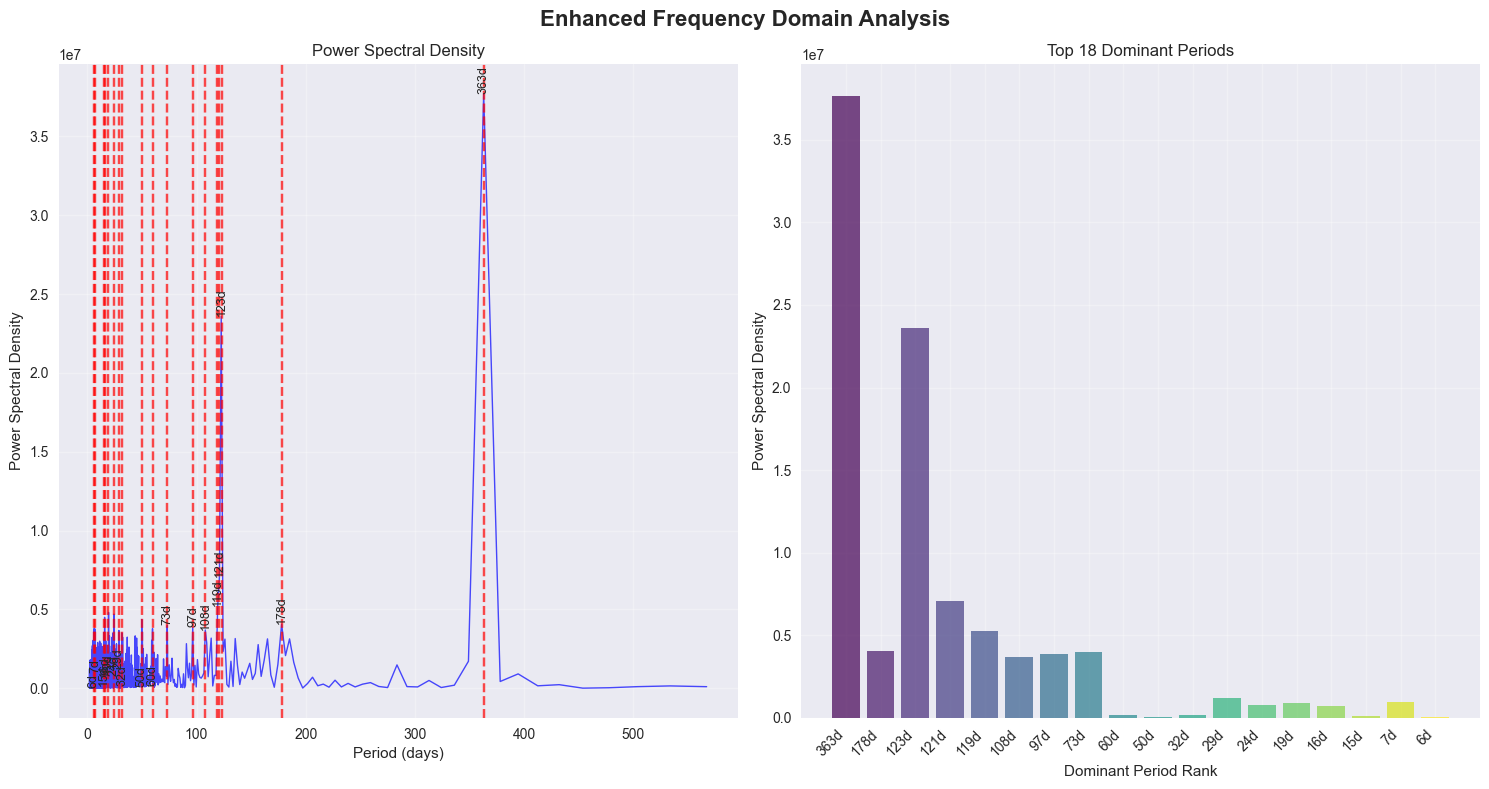

In [12]:
# =============================================================================
# TEMPORAL ANALYSIS 2: FFT FREQUENCY ANALYSIS
# =============================================================================

# Analysis with parameter tuning for Vietnam weather patterns
fft_results_180 = temporal_analyzer.analyze_fft(
    detrend_window=180,  
    top_n=20,  
    period_range=(1, 730),
    return_n_dominant=20
)

# Visualization
temporal_analyzer.plot_spectrum(
    fft_results=fft_results_180,
    figsize=(15, 8),
    show_dominant=True,
    max_period=600,  
    log_scale=False,
    bar_chart_periods=20 
)

🔊 Enhanced FFT Frequency Analysis
   - Detrend window: 90
   - Top periods to find: 20
   - Period range: (1, 730)
   - Dominant periods to return: 20
   📊 Found 18 total dominant periods
   📊 Returning top 18 dominant periods:
      1. 122 days
      2. 73 days
      3. 72 days
      4. 65 days
      5. 63 days
      6. 60 days
      7. 59 days
      8. 50 days
      9. 45 days
      10. 44 days
      11. 29 days
      12. 25 days
      13. 24 days
      14. 23 days
      15. 16 days
      16. 14 days
      17. 7 days
      18. 5 days
   📊 Displaying 18 dominant periods in bar chart


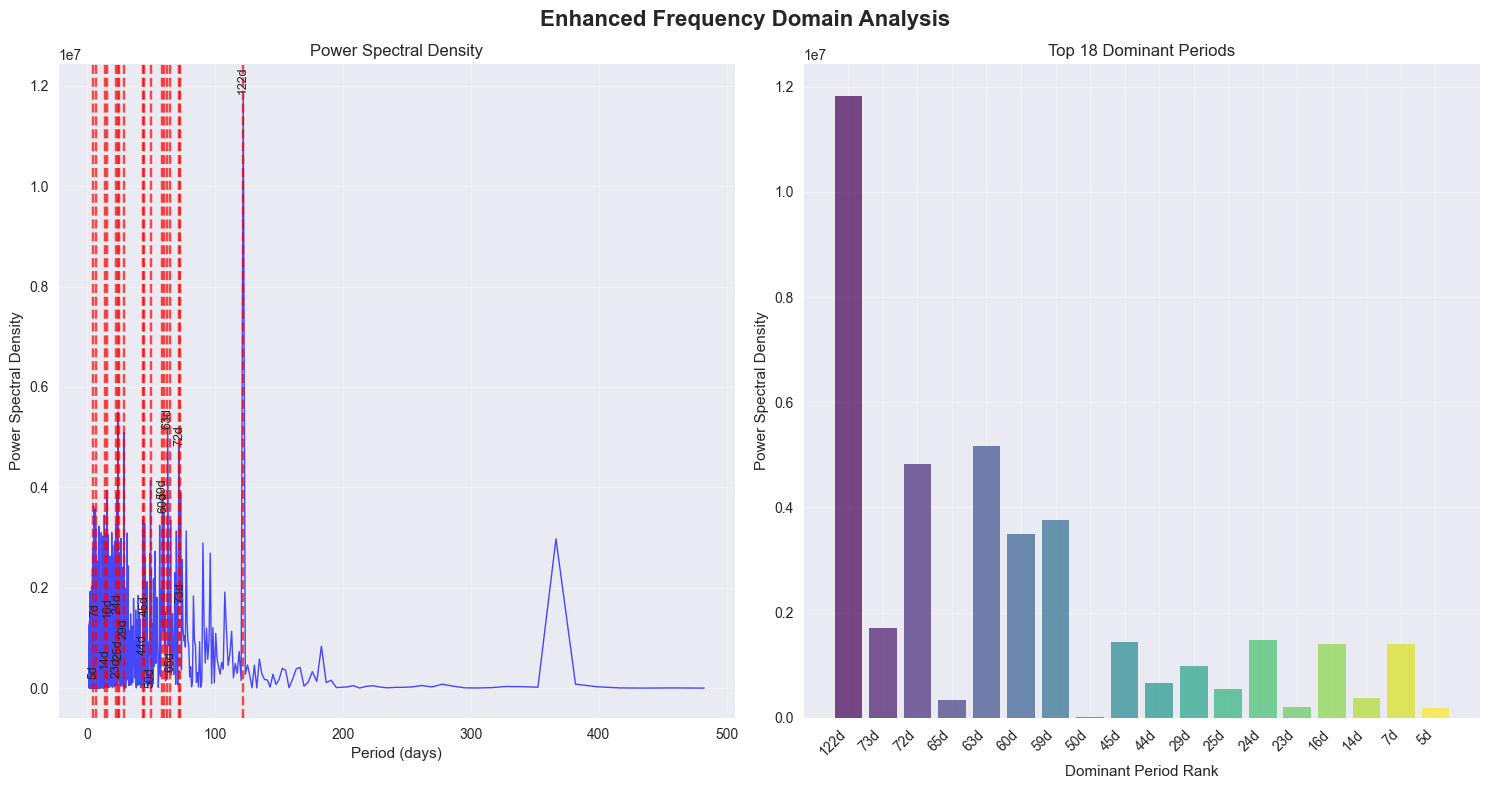

In [13]:
# =============================================================================
# TEMPORAL ANALYSIS 2: FFT FREQUENCY ANALYSIS
# =============================================================================

# Analysis with parameter tuning for Vietnam weather patterns
fft_results_90 = temporal_analyzer.analyze_fft(
    detrend_window=90,  
    top_n=20,  
    period_range=(1, 730),
    return_n_dominant=20
)

# Visualization
temporal_analyzer.plot_spectrum(
    fft_results=fft_results_90,
    figsize=(15, 8),
    show_dominant=True,
    max_period=500,  
    log_scale=False,
    bar_chart_periods=20 
)

🔊 Enhanced FFT Frequency Analysis
   - Detrend window: 30
   - Top periods to find: 20
   - Period range: (1, 730)
   - Dominant periods to return: 20
   📊 Found 12 total dominant periods
   📊 Returning top 12 dominant periods:
      1. 29 days
      2. 27 days
      3. 25 days
      4. 24 days
      5. 23 days
      6. 22 days
      7. 21 days
      8. 20 days
      9. 19 days
      10. 17 days
      11. 16 days
      12. 6 days
   📊 Displaying 12 dominant periods in bar chart


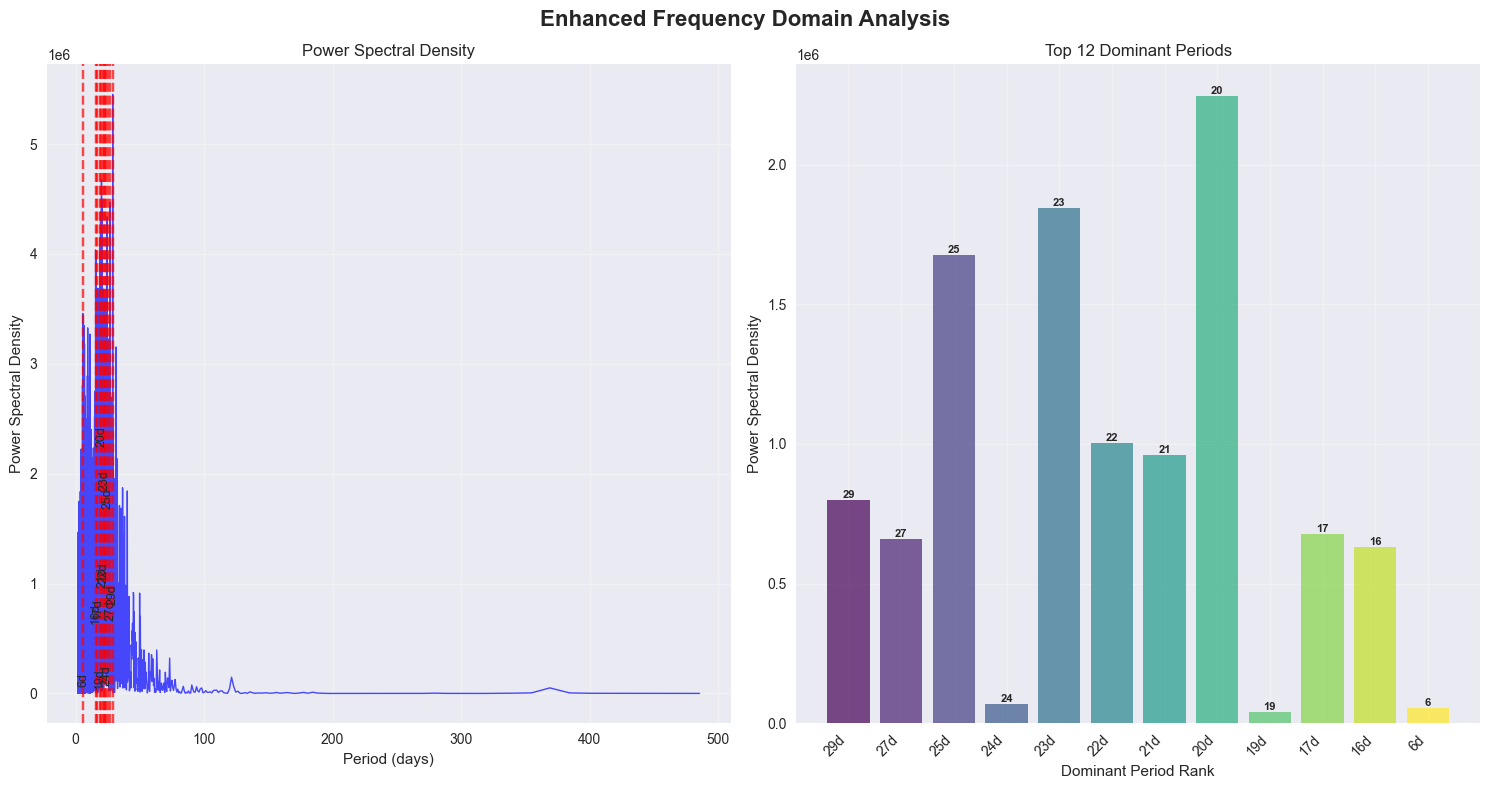

In [14]:
# =============================================================================
# TEMPORAL ANALYSIS 2: FFT FREQUENCY ANALYSIS
# =============================================================================

# Analysis with parameter tuning for Vietnam weather patterns
fft_results_30 = temporal_analyzer.analyze_fft(
    detrend_window=30,  
    top_n=20,  
    period_range=(1, 730),
    return_n_dominant=20
)

# Visualization
temporal_analyzer.plot_spectrum(
    fft_results=fft_results_30,
    figsize=(15, 8),
    show_dominant=True,
    max_period=500,  
    log_scale=False,
    bar_chart_periods=20 
)

🔊 Enhanced FFT Frequency Analysis
   - Detrend window: 15
   - Top periods to find: 20
   - Period range: (1, 730)
   - Dominant periods to return: 20
   📊 Found 9 total dominant periods
   📊 Returning top 9 dominant periods:
      1. 16 days
      2. 14 days
      3. 13 days
      4. 12 days
      5. 11 days
      6. 10 days
      7. 9 days
      8. 7 days
      9. 4 days
   📊 Displaying 9 dominant periods in bar chart


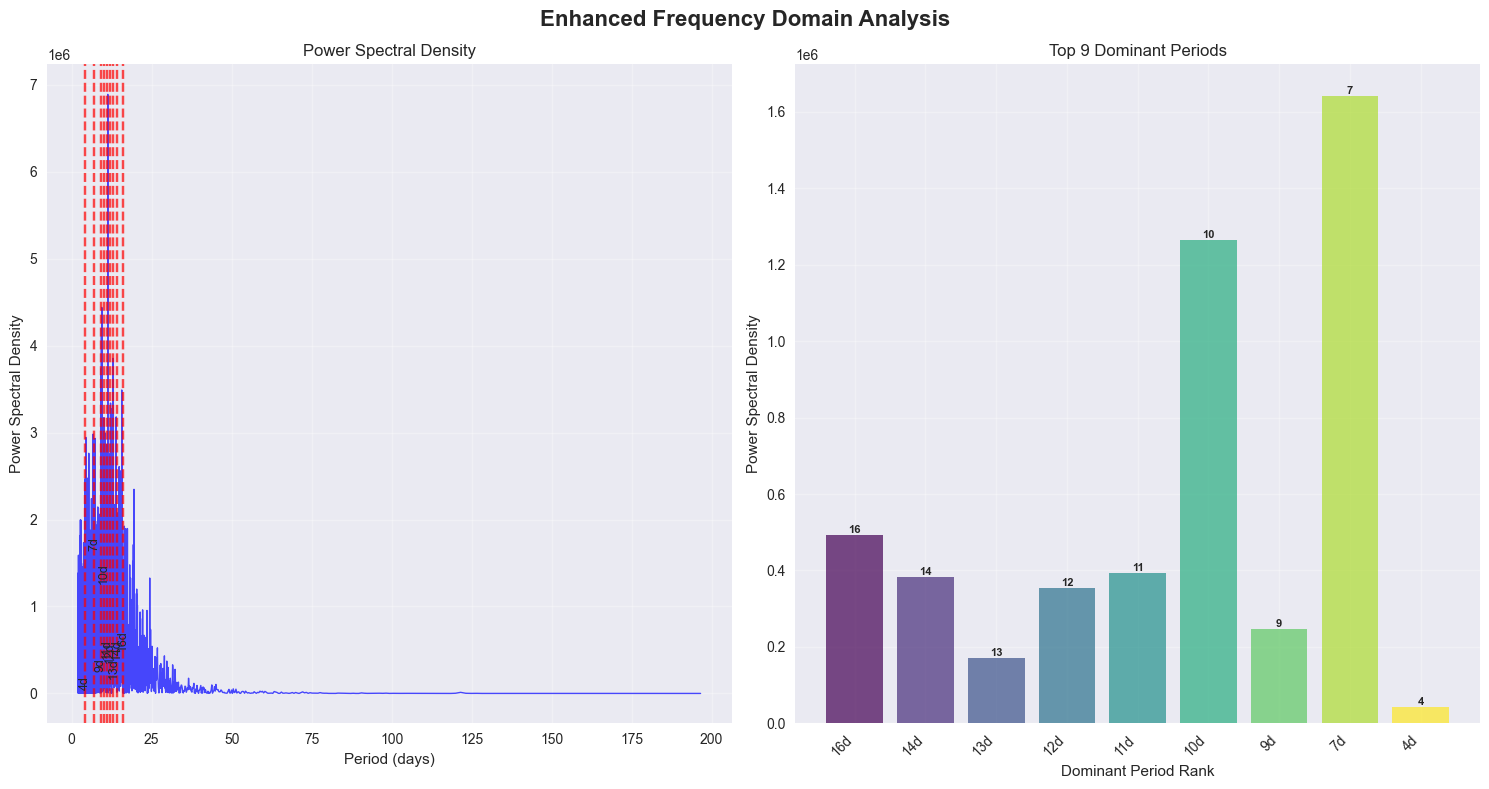

In [15]:
# =============================================================================
# TEMPORAL ANALYSIS 2: FFT FREQUENCY ANALYSIS
# =============================================================================

# Analysis with parameter tuning for Vietnam weather patterns
fft_results_15 = temporal_analyzer.analyze_fft(
    detrend_window=15,  
    top_n=20,  
    period_range=(1, 730),
    return_n_dominant=20
)

# Visualization
temporal_analyzer.plot_spectrum(
    fft_results=fft_results_15,
    figsize=(15, 8),
    show_dominant=True,
    max_period=200,  
    log_scale=False,
    bar_chart_periods=20 
)

🔊 Enhanced FFT Frequency Analysis
   - Detrend window: 7
   - Top periods to find: 20
   - Period range: (1, 730)
   - Dominant periods to return: 20
   📊 Found 4 total dominant periods
   📊 Returning top 4 dominant periods:
      1. 7 days
      2. 6 days
      3. 5 days
      4. 4 days
   📊 Displaying 4 dominant periods in bar chart


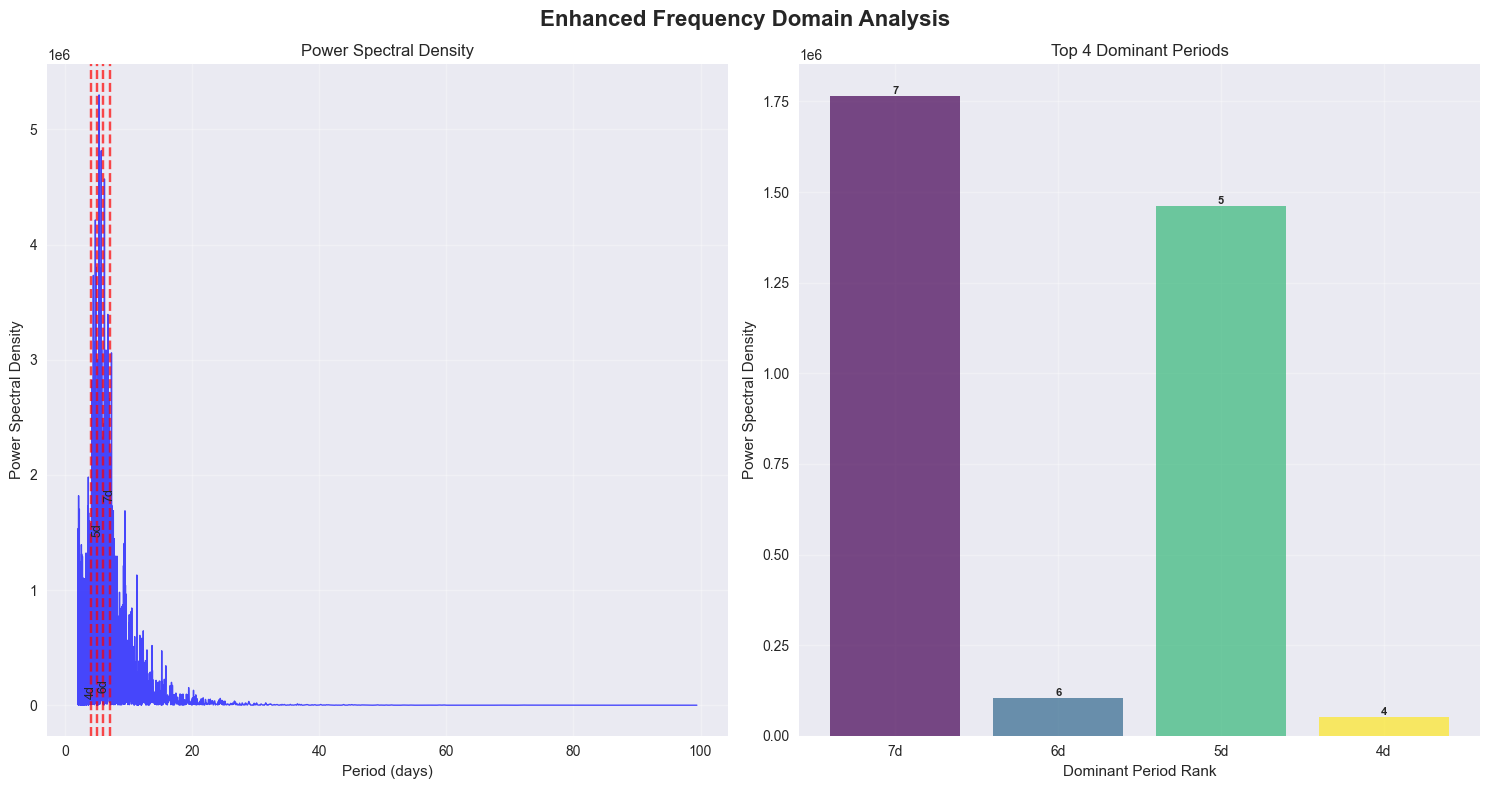

In [16]:
# =============================================================================
# TEMPORAL ANALYSIS 2: FFT FREQUENCY ANALYSIS
# =============================================================================

# Analysis with parameter tuning for Vietnam weather patterns
fft_results_7 = temporal_analyzer.analyze_fft(
    detrend_window=7,  
    top_n=20,  
    period_range=(1, 730),
    return_n_dominant=20
)

# Visualization
temporal_analyzer.plot_spectrum(
    fft_results=fft_results_7,
    figsize=(15, 8),
    show_dominant=True,
    max_period=100,  
    log_scale=False,
    bar_chart_periods=20 
)

### MSTL Decomposition

In [17]:
analysis_periods = [7, 20, 122, 365]

mstl_results = temporal_analyzer.decompose_mstl(
    periods=analysis_periods,
    # MSTL parameters
    windows=None,  # Use default values from original paper
    lmbda=None,    
    iterate=3,     # Standard iteration count
    # STL parameters for fine-tuning
    robust=True,   # Handle outliers better
    seasonal_deg=1,  # Linear seasonal fit
    trend_deg=1      # Linear trend fit
)

print("\n🎯 MSTL Analysis Results:")
if mstl_results['success']:
    print("   ✅ MSTL decomposition completed successfully")
    print(f"   📊 Components available: trend, seasonal, residual")
    print(f"   📈 Trend shape: {mstl_results['trend'].shape}")
    print(f"   🌊 Seasonal shape: {mstl_results['seasonal'].shape}")  
    print(f"   📉 Residual shape: {mstl_results['resid'].shape}")
    print(f"   📤 Residual ready for Stationarity analysis")
else:
    print("   ❌ MSTL decomposition failed")
    print(f"   ⚠️ Error: {mstl_results['error']}")

📊 MSTL Decomposition
   - Periods: [7, 20, 122, 365]
   - Windows: None
   - Lambda: None
   - Iterations: 3
   - STL kwargs: {'robust': True, 'seasonal_deg': 1, 'trend_deg': 1}
   🔄 Applying log1p transformation (lmbda=None)
   ✅ MSTL decomposition completed successfully
   📊 Transform method: log1p
   📊 Components extracted: trend, seasonal, residual
   📤 Residual component available for Stationarity analysis

🎯 MSTL Analysis Results:
   ✅ MSTL decomposition completed successfully
   📊 Components available: trend, seasonal, residual
   📈 Trend shape: (9252,)
   🌊 Seasonal shape: (9252, 4)
   📉 Residual shape: (9252,)
   📤 Residual ready for Stationarity analysis


📊 MSTL Decomposition Visualization
✅ MSTL decomposition successful - proceeding with visualization

🎯 Decomposition Summary:
   📊 Periods used: [7, 20, 122, 365]
   🔄 Lambda (Box-Cox): None
   📈 Trend shape: (9252,)
   🌊 Seasonal shape: (9252, 4)
   📉 Residual shape: (9252,)


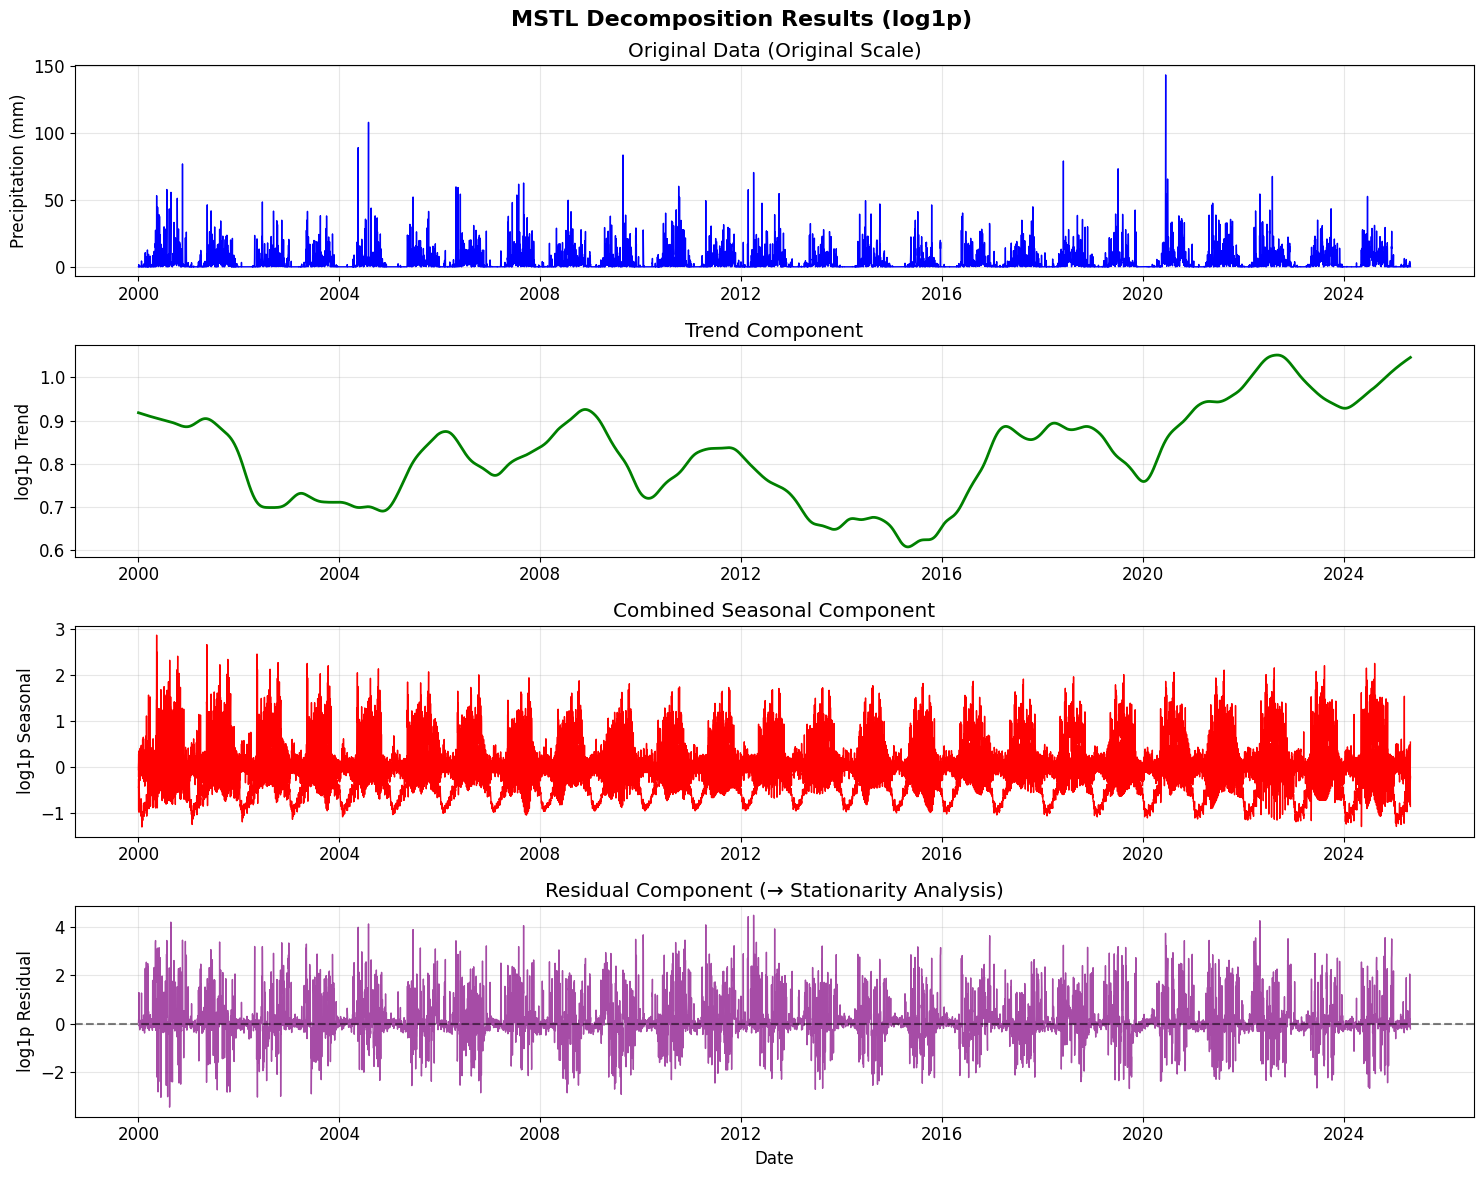

   📤 Residual component ready for Stationarity analysis
   🔄 Transform method used: log1p


In [18]:
# =============================================================================
# MSTL DECOMPOSITION VISUALIZATION
# =============================================================================

# Core libraries for visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from typing import Dict, List, Tuple, Any, Optional

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting parameters
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['font.size'] = 12

print("📊 MSTL Decomposition Visualization")
print("=" * 50)

# Check if MSTL decomposition was successful
if mstl_results['success']:
    print("✅ MSTL decomposition successful - proceeding with visualization")
    
    # Display decomposition info
    print(f"\n🎯 Decomposition Summary:")
    print(f"   📊 Periods used: {mstl_results['periods']}")
    print(f"   🔄 Lambda (Box-Cox): {mstl_results['lmbda']}")
    print(f"   📈 Trend shape: {mstl_results['trend'].shape}")
    print(f"   🌊 Seasonal shape: {mstl_results['seasonal'].shape}")
    print(f"   📉 Residual shape: {mstl_results['resid'].shape}")
    
    # Check if fallback was used
    if mstl_results.get('fallback_used'):
        print(f"   ⚠️ Zero-handling fallback used: {mstl_results['zeros_adjusted']} zeros adjusted")
        print(f"   📊 Epsilon added: {mstl_results['epsilon_added']}")
    
    # Visualize decomposition
    temporal_analyzer.plot_decomposition(
        mstl_results=mstl_results,
        figsize=(15, 12),
        show_components=['trend', 'seasonal', 'resid'],
        original_scale=True
    )
    
else:
    print("❌ MSTL decomposition failed - cannot visualize")
    print(f"⚠️ Error: {mstl_results['error']}")

### Stationarity

🔍 COMPLETE STATIONARITY & AUTOCORRELATION ANALYSIS
   🎯 Theory-Driven Parameters Extracted:
      • Representative periods: [7, 20, 122, 365]
      • Max lags recommended: 200
      • Seasonal periods: [7, 20, 122, 365]
      • Parameter source: theory_driven

🔍 PHẦN 3: THEORY-DRIVEN STATIONARITY & AUTOCORRELATION DIAGNOSTICS
🎯 Mục tiêu: Theory-driven chẩn đoán với representative periods

🔍 BƯỚC 1: CHẨN ĐOÁN TÍNH DỪNG
   📊 ADF Test:
      - Statistic: -8.709252
      - P-value: 0.000000
      - Result: ✅ Stationary
   📊 KPSS Test:
      - Statistic: 0.072028
      - P-value: 0.100000
      - Result: ✅ Stationary
   🎯 Kết luận: ✅ STATIONARY


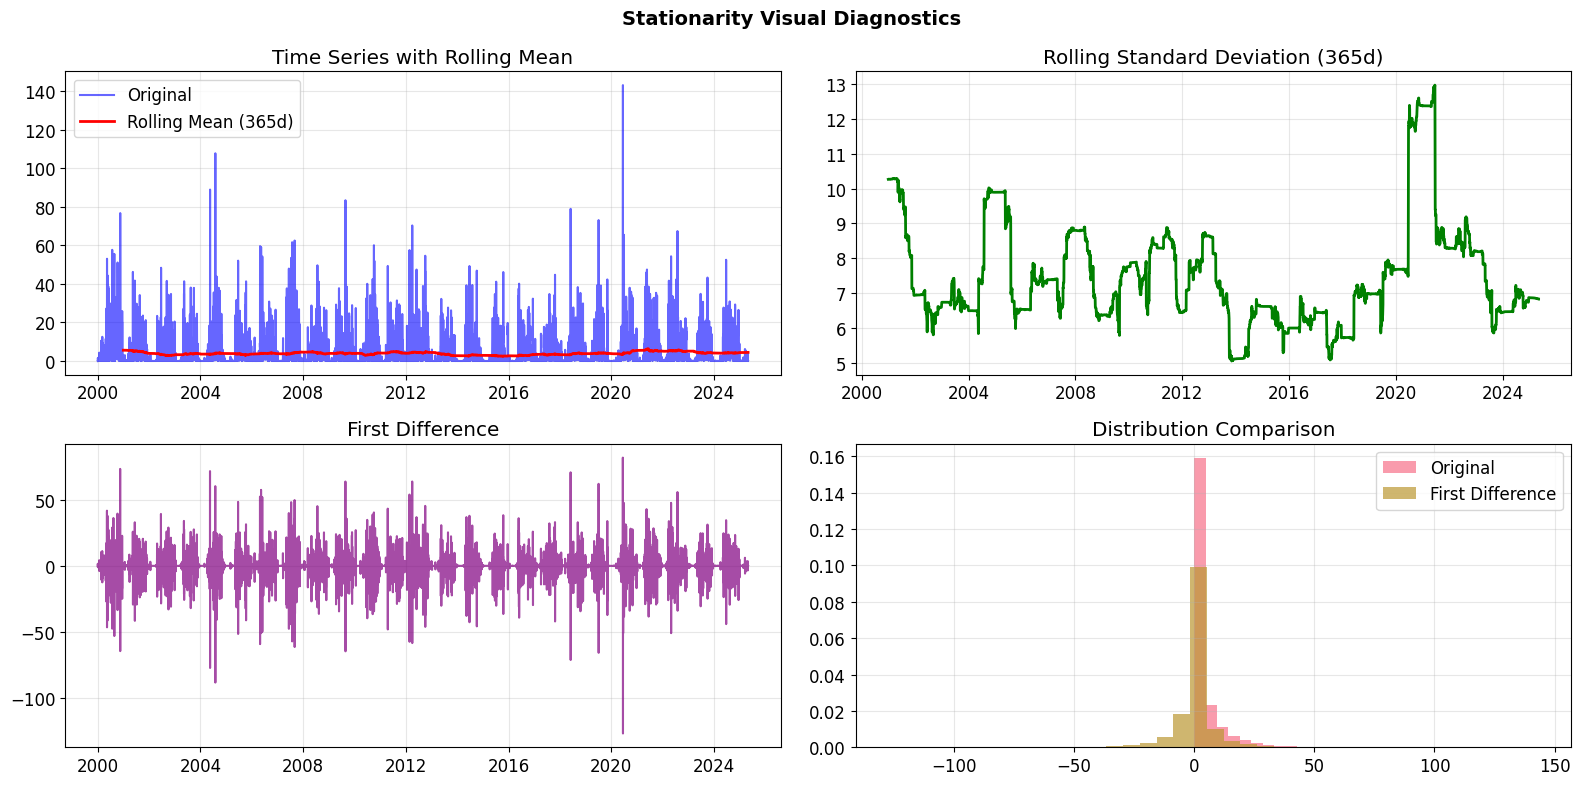


🔄 BƯỚC 2: PHÂN TÍCH TỰ TƯƠNG QUAN (THEORY-DRIVEN)
   🎯 Theory-driven max_lags: 200
      Source: theory_driven
      Based on max period: 365 + buffer: 91
   📈 ACF (Original Series):
      • Total significant lags: 160
      • Lags near representative periods: 32
   📈 PACF (Original Series):
      • Total significant lags: 44
      • Lags near representative periods: 18
   🎯 Theory-Driven SARIMA Parameter Selection:
      • ACF lags (p): [1, 2, 3, 4, 5]
      • PACF lags (q): [1, 2, 3, 4, 5]
      • Representative periods: [7, 20, 122, 365]
   📊 SARIMA Suggestions: ['SARIMA(3,1,3)x(1,1,1,365)', 'SARIMA(3,0,3)x(1,0,1,365)', 'SARIMA(3,1,3)x(1,1,1,122)']


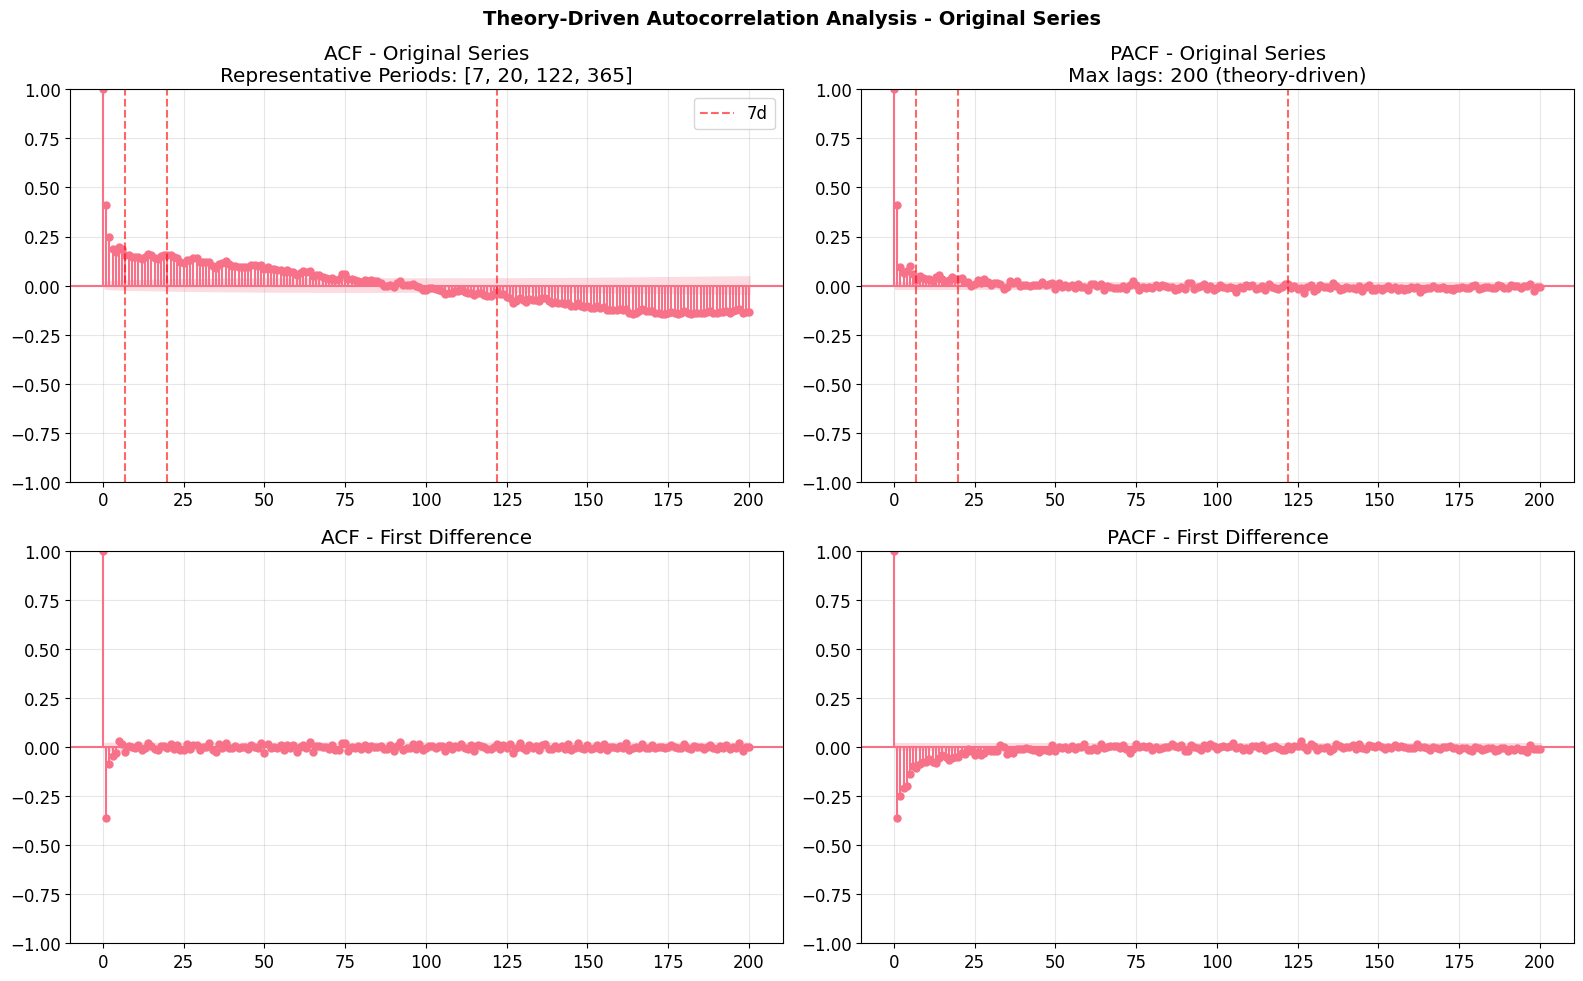


🧪 BƯỚC 3: CHẨN ĐOÁN RESIDUAL MSTL
🔍 Residual Diagnostics
   - Ljung-Box lags: 10
   - ACF lags: 40
   - Mean: 0.123163
   - Std: 0.819033
   ⚠️ Autocorrelation detected at 10 lags


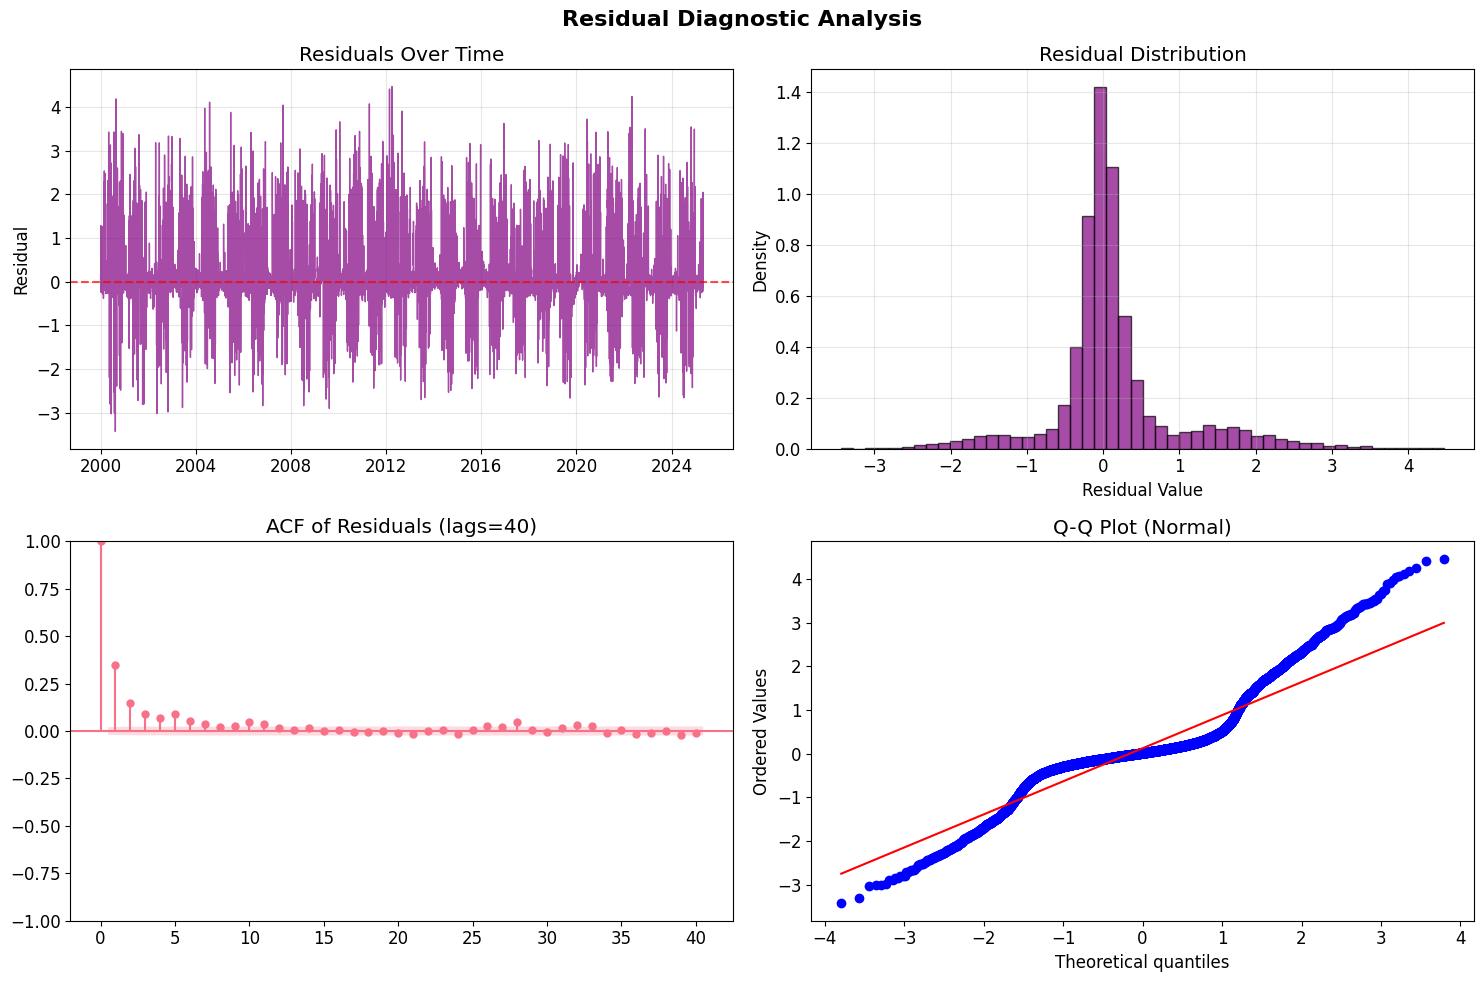


📊 Residual Summary:
   - Count: 9,252
   - Mean: 0.123163
   - Std: 0.819033
   - Skewness: 0.8237
   - Kurtosis: 3.6522
   📊 MSTL Quality: Poor
      • Significant structure in residuals
      • MSTL may be insufficient

📋 BƯỚC 4: TỔNG HỢP & KẾT LUẬN (THEORY-DRIVEN)
   📊 PHÁT HIỆN CHÍNH:
      🔹 Tính dừng: Stationary
      🔹 Cần sai phân: Không
      🔹 Methodology: theory_driven
      🔹 Lags quan trọng (top 5): [1, 2, 3, 4, 5]
      🔹 Theory-validated lags: 32
      🔹 Max lags used: 200 (theory_driven)
      🎯 Representative periods: [7, 20, 122, 365]

   💡 THEORY-DRIVEN MODEL RECOMMENDATIONS:
      • ARMA models suitable
      • SARIMA models for theory-driven seasonal patterns
      • Representative periods: [7, 20, 122, 365]
      • All seasonal periods: [7, 20, 122, 365]
      • Additional AR/MA terms may be needed
      • Theory-driven analysis: 32 lags validated against representative periods
✅ Complete analysis finished!


In [19]:
from src.analysis.Stationarity import StationarityAutocorrelationAnalyzer

print("🔍 COMPLETE STATIONARITY & AUTOCORRELATION ANALYSIS")
print("=" * 55)

# Check prerequisites
if 'mstl_results' in locals() and mstl_results.get('success'):
    
    # Initialize analyzer
    analyzer = StationarityAutocorrelationAnalyzer(
        df=df,
        target_col='Lượng mưa',
        date_col='Ngày',
        mstl_results=mstl_results,
        representative_periods=analysis_periods
    )
    
    # ✅ ONE METHOD CALL - RUNS EVERYTHING!
    complete_results = analyzer.analyze()
    
    print("✅ Complete analysis finished!")
    
    # Results contain:
    # - stationarity tests (ADF, KPSS)
    # - autocorrelation analysis (ACF, PACF)  
    # - residual diagnostics (if MSTL provided)
    # - synthesis & recommendations
    
else:
    print("❌ MSTL results not available")

## Cross-Correlation & Multicollinearity Analysis

🚀 STARTING COMPREHENSIVE CORRELATION ANALYSIS
🔍 CORRELATION ANALYZER INITIALIZED
   📊 Dataset Shape: (9252, 23)
   🎯 Target Variable: Lượng mưa
   🔢 Total Features: 20
   📈 Predictor Features: 19

📋 6. CORRELATION ANALYSIS INSIGHTS REPORT

🌤️ 1. METEOROLOGICAL CORRELATION MATRIX ANALYSIS
📊 Meteorological Feature Groups:
   - Temperature: 6 features
   - Humidity: 5 features
   - Wind: 6 features
   - Pressure_Radiation: 2 features
   - Precipitation: 1 features

📅 2. TEMPORAL CORRELATION DYNAMICS

🔍 3. MULTICOLLINEARITY ANALYSIS
📊 Multicollinearity Analysis Results:
            Feature     VIF_Score    Category Risk_Level
Nhiệt độ bầu ướt 2m 154387.023484 Temperature       High
      Điểm sương 2m 113529.370568 Temperature       High
        Nhiệt độ 2m  74977.814798 Temperature       High
      Tốc độ gió 2m    611.690068        Wind       High
     Tốc độ gió 10m    584.487676        Wind       High
 Độ ẩm tuyệt đối 2m    278.682109    Humidity       High
 Độ ẩm tương đối 2m    242.9

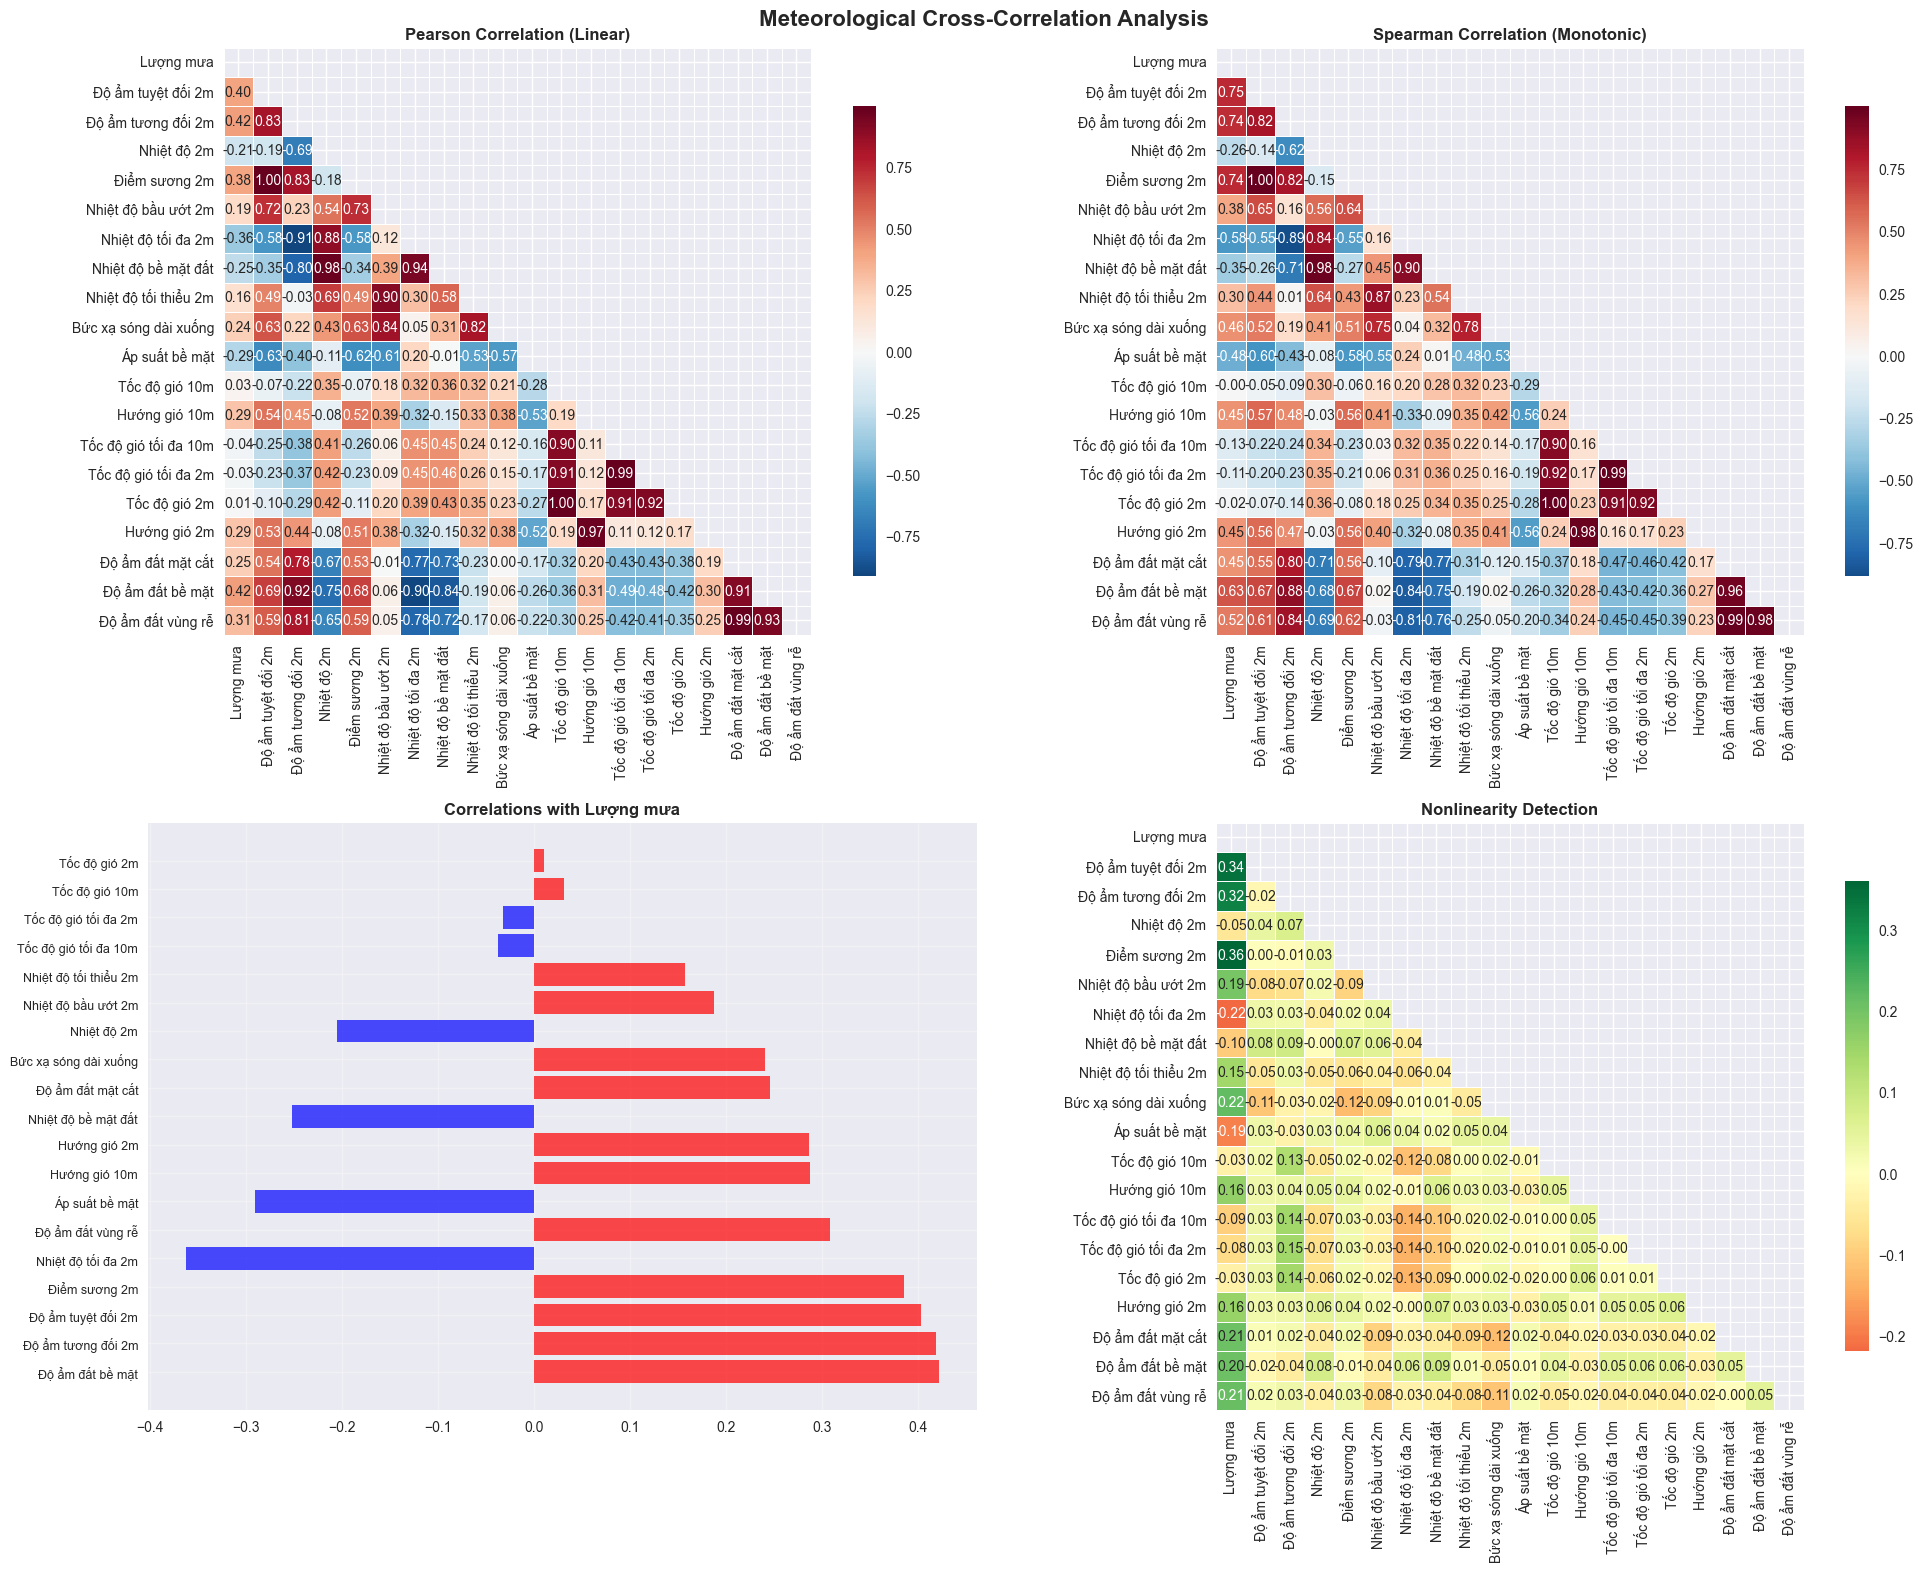

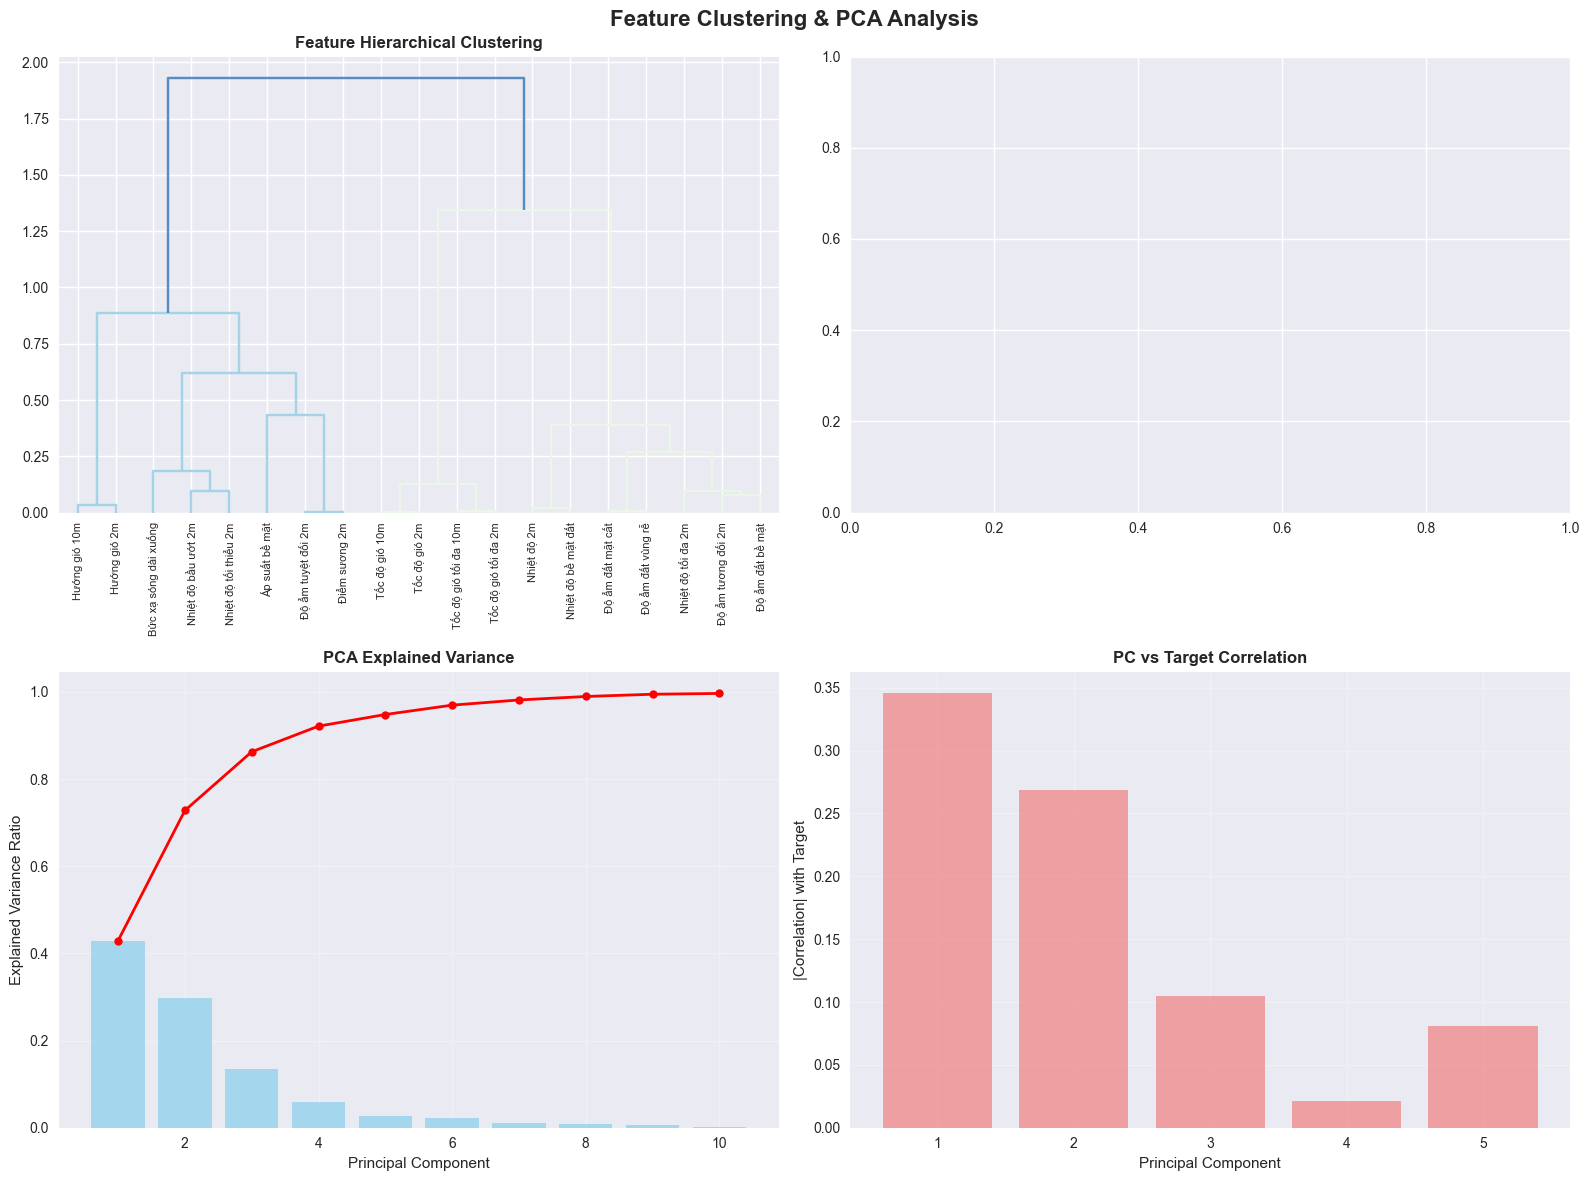

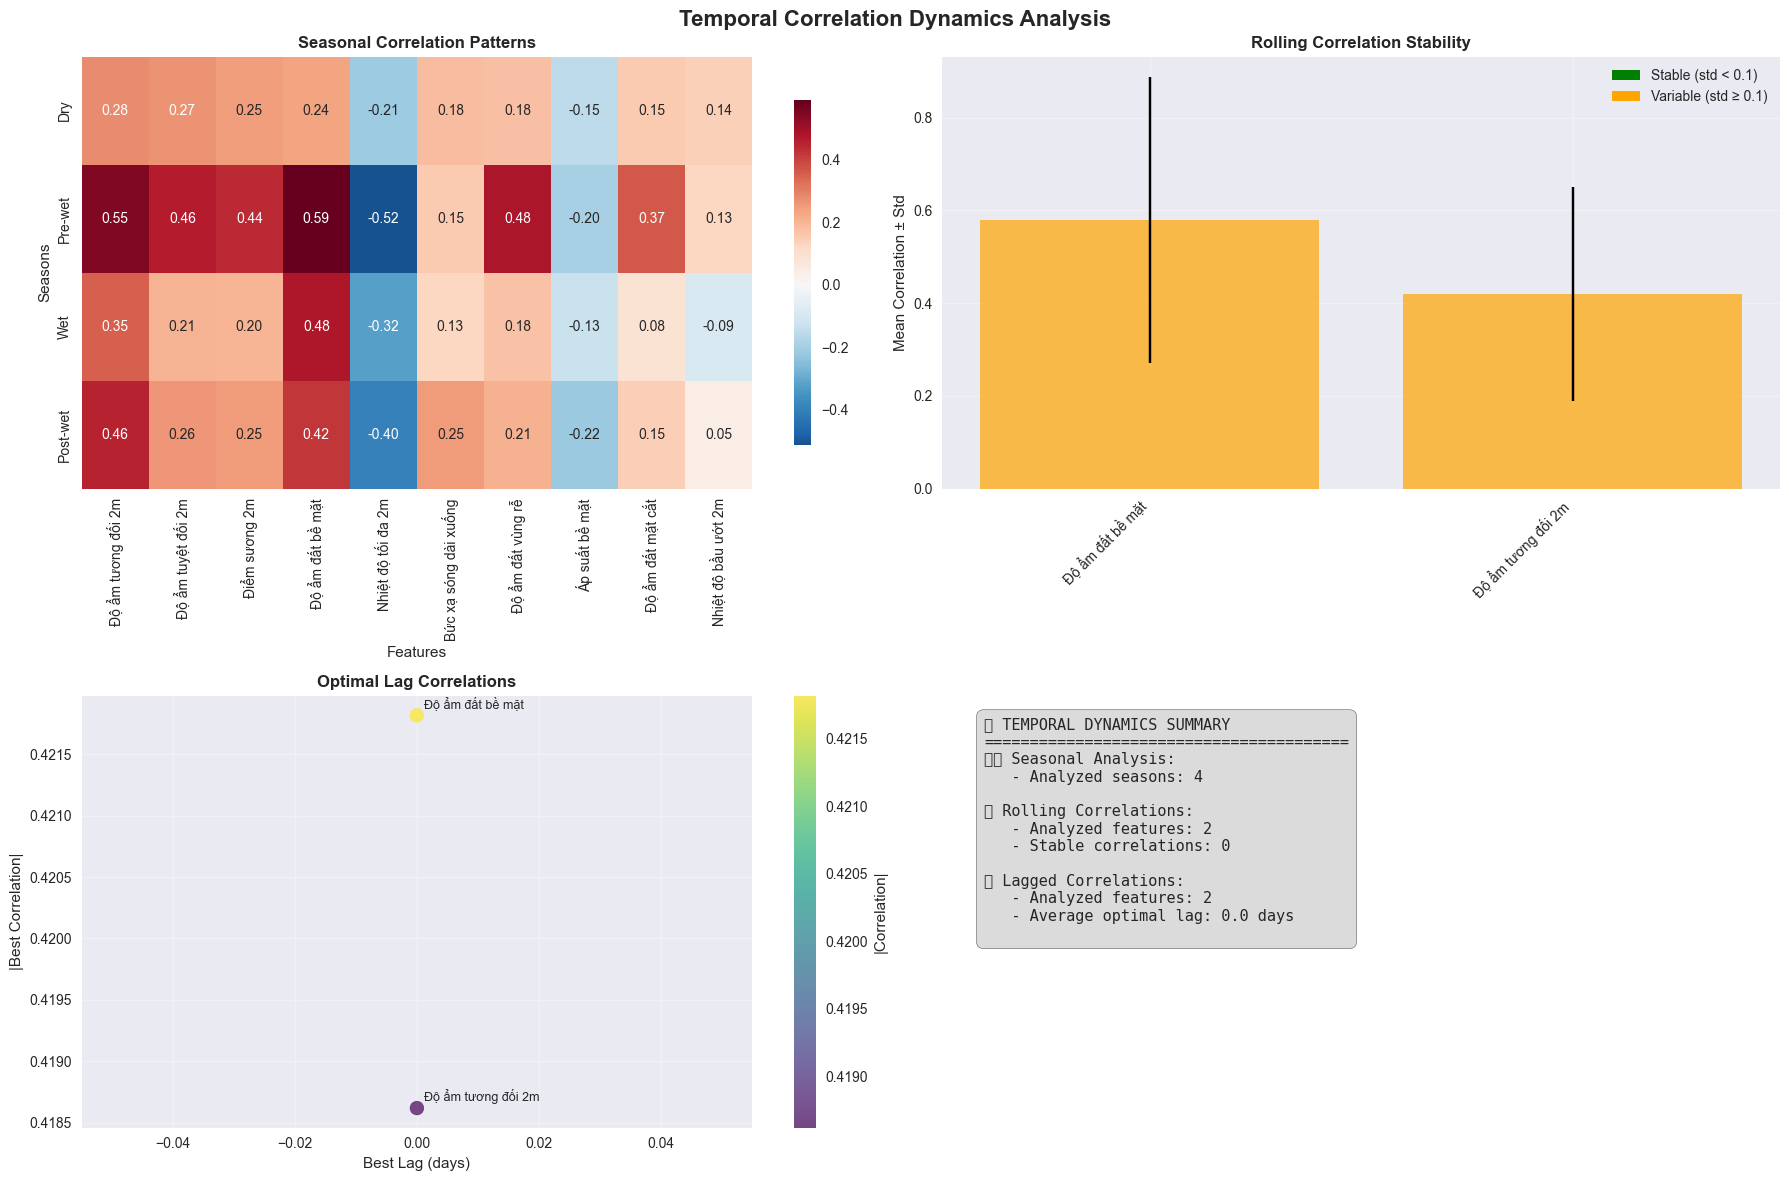

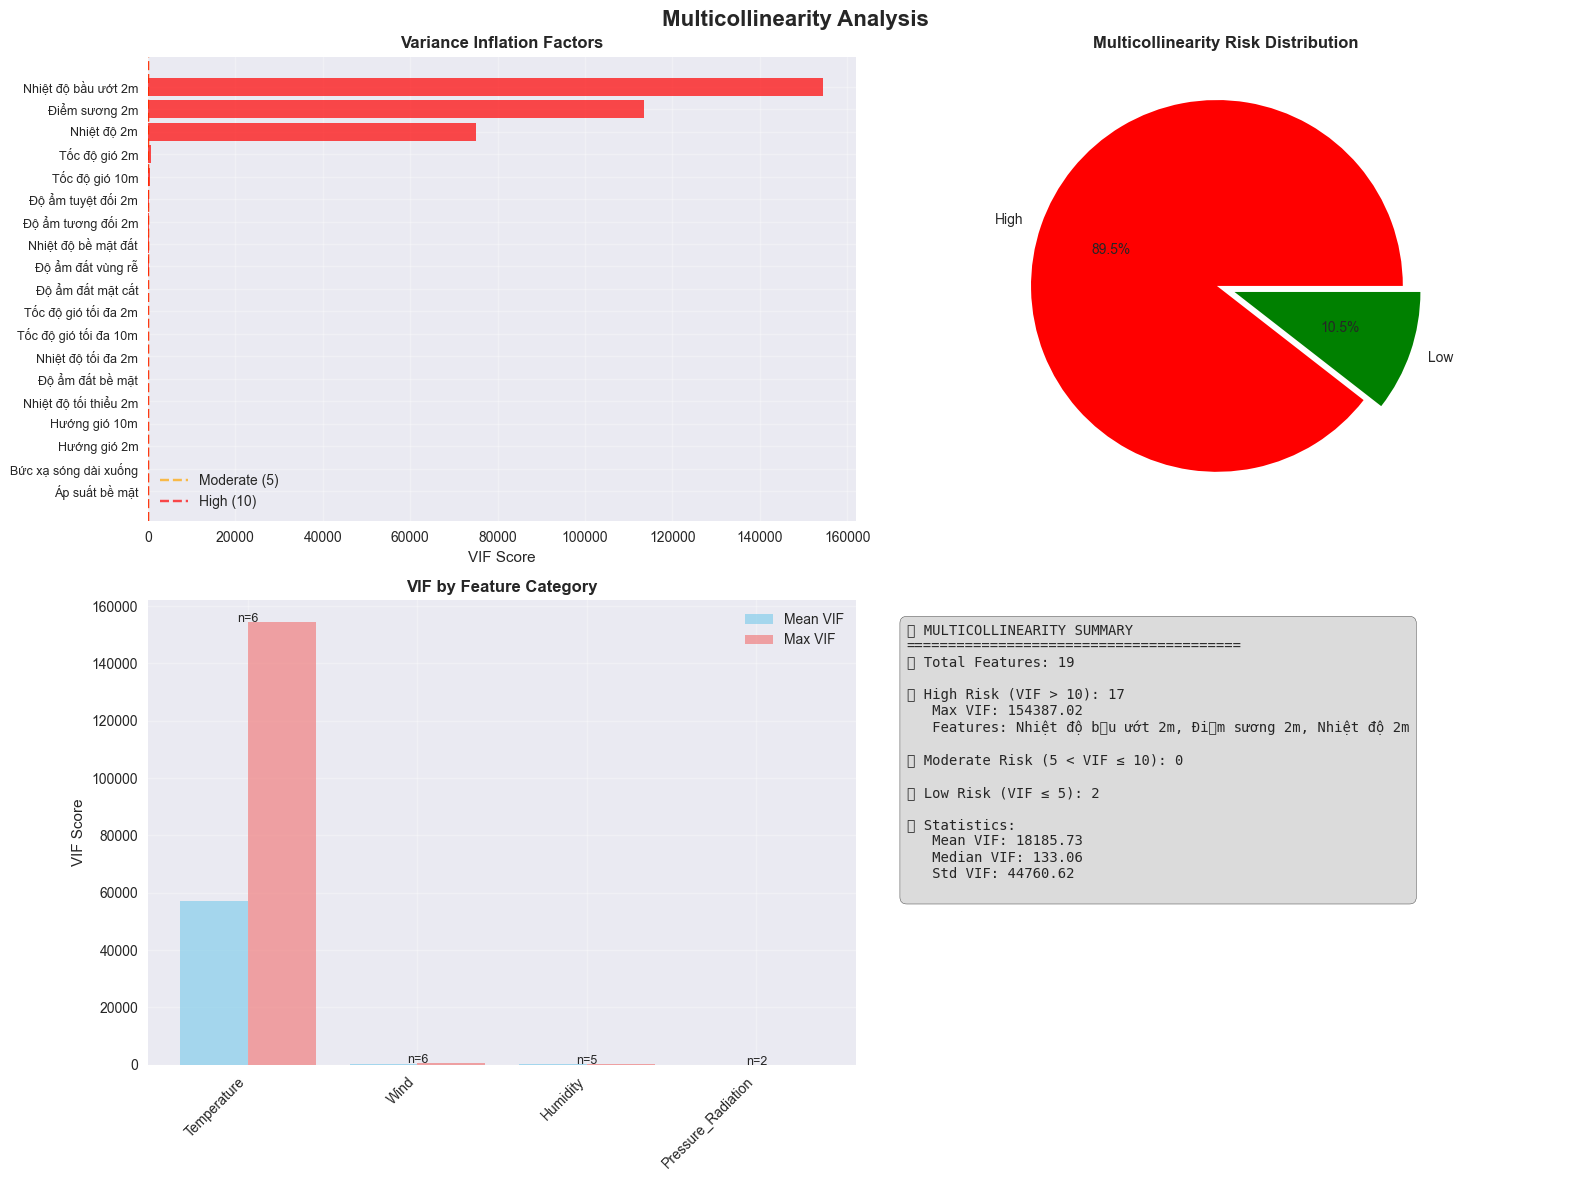

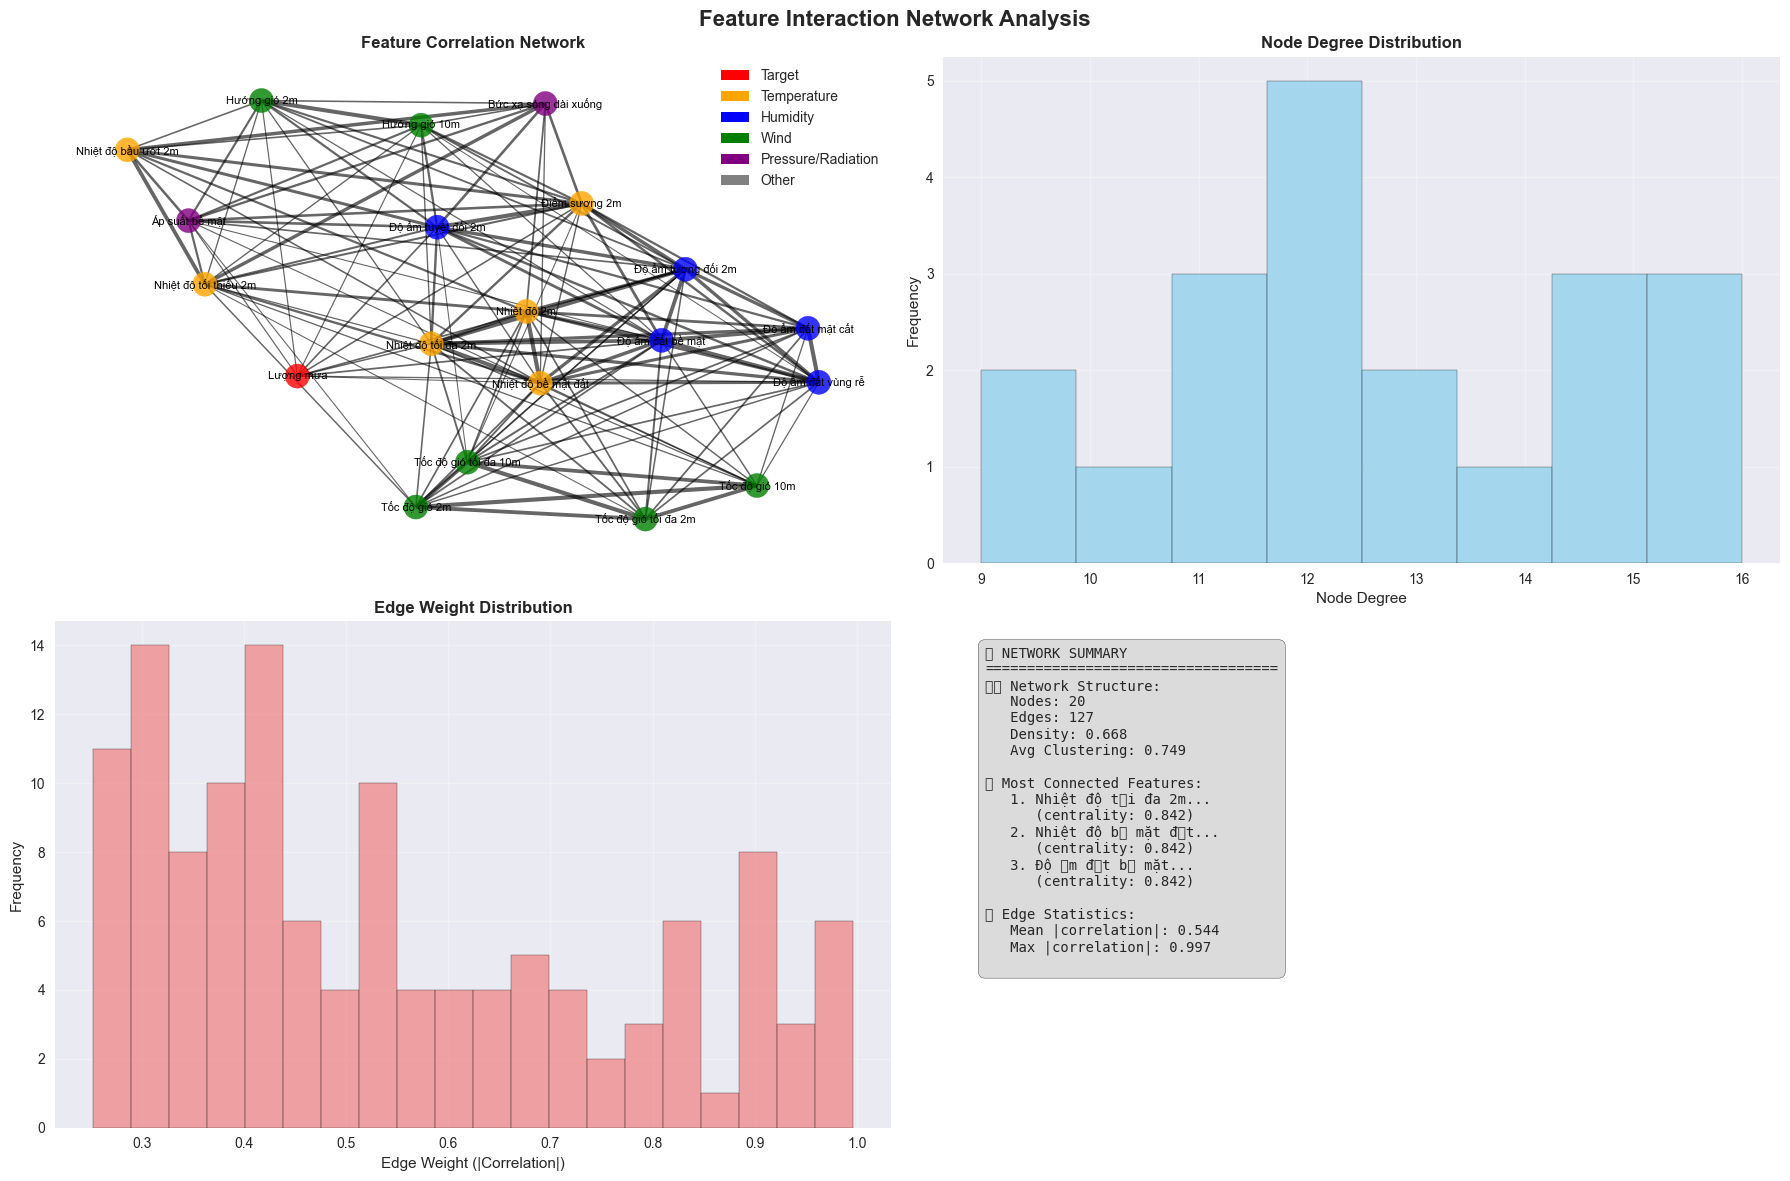


✅ CORRELATION ANALYSIS COMPLETED


In [20]:
from src.analysis.CorrelationAnalysis import analyze_correlations

# Chạy toàn bộ pipeline với visualization
results = analyze_correlations(df, target_col='Lượng mưa', date_col='Ngày', include_visualization=True)

# Feature Engineering

In [21]:
# Import feature engineering utilities
from src.featurengineering.utils import (
    select_features, create_temporal_features, create_lag_features,
    create_rolling_features, create_interaction_features, 
    handle_missing_values, validate_feature_quality,
    apply_feature_engineering_steps, create_mstl_features
)

print("✅ Feature Engineering modules imported successfully")

✅ Feature Engineering modules imported successfully


## Feature Selection

In [22]:
# Define selected features (same as manual approach)
selected_features = [
    'Nhiệt độ tối đa 2m',      # T2M_MAX
    'Nhiệt độ tối thiểu 2m',    # T2M_MIN
    'Độ ẩm tương đối 2m',       # RH2M
    'Độ ẩm đất bề mặt',         # GWETTOP
    'Hướng gió 10m',            # WD10M
    'Áp suất bề mặt',           # PS
    'Bức xạ sóng dài xuống'     # ALLSKY_SFC_LW_DWN
]

# Use module function for feature selection
df_selected = select_features(
    df=df,
    features_to_keep=selected_features,
    target_col='Lượng mưa',
    date_col='Ngày',
    keep_essential=True
)

print(f"Selected features: {selected_features}")

📊 SELECTING FEATURES
   Features to select: 7
   Original shape: (9252, 23)
   Selected shape: (9252, 9)
   ✅ Feature selection completed
Selected features: ['Nhiệt độ tối đa 2m', 'Nhiệt độ tối thiểu 2m', 'Độ ẩm tương đối 2m', 'Độ ẩm đất bề mặt', 'Hướng gió 10m', 'Áp suất bề mặt', 'Bức xạ sóng dài xuống']


## MSTL result feature

In [23]:
# Sau khi chạy MSTL decomposition
df_selected = create_mstl_features(df_selected, mstl_results, lag_periods=[1])

📊 ADDING MSTL FEATURES
   Components shape: 9252 observations
   Seasonal shape: (9252, 4)
   ✅ Added 6 MSTL features:
      • MSTL_Trend: 0 missing values
      • MSTL_Residual: 0 missing values
      • MSTL_Seasonal_1: 0 missing values
      • MSTL_Seasonal_2: 0 missing values
      • MSTL_Seasonal_3: 0 missing values
      • MSTL_Seasonal_4: 0 missing values

   🕒 Creating lag features for MSTL components...
⏰ CREATING LAG FEATURES
   ✅ Created 6 lag features
   Columns lagged: ['MSTL_Trend', 'MSTL_Residual', 'MSTL_Seasonal_1', 'MSTL_Seasonal_2', 'MSTL_Seasonal_3', 'MSTL_Seasonal_4']
   Lag periods: [1]
   Dataset shape: (9252, 21)

   📊 Final shape: (9252, 21)


## Temporal feature

In [24]:
# Create temporal features using module function
temporal_features_to_create = [
    'Year', 'Month', 'DayofMonth', 'DayofYear',
    'Month_sin', 'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos',
    'Is_Wet_Season'
]

df_selected = create_temporal_features(
    df=df_selected,
    date_col='Ngày',
    features_to_create=temporal_features_to_create,
    wet_season_months=[5, 6, 7, 8, 9, 10]  # May-November for HCMC
)

# Display sample of new features (same as manual)
print("\n📊 Sample of new time features:")
print(df_selected[['Ngày', 'Year', 'Month', 'DayofMonth', 'DayofYear',
                   'Month_sin', 'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos',
                   'Is_Wet_Season']].head(10))

print(f"\n🌧️ Wet Season Distribution:")
print(df_selected['Is_Wet_Season'].value_counts())

🕒 CREATING TEMPORAL FEATURES
   ✅ Created 9 temporal features
   Dataset shape: (9252, 30)

📊 Sample of new time features:
        Ngày  Year  Month  DayofMonth  DayofYear  Month_sin  Month_cos  \
0 2000-01-01  2000      1           1          1        0.5   0.866025   
1 2000-01-02  2000      1           2          2        0.5   0.866025   
2 2000-01-03  2000      1           3          3        0.5   0.866025   
3 2000-01-04  2000      1           4          4        0.5   0.866025   
4 2000-01-05  2000      1           5          5        0.5   0.866025   
5 2000-01-06  2000      1           6          6        0.5   0.866025   
6 2000-01-07  2000      1           7          7        0.5   0.866025   
7 2000-01-08  2000      1           8          8        0.5   0.866025   
8 2000-01-09  2000      1           9          9        0.5   0.866025   
9 2000-01-10  2000      1          10         10        0.5   0.866025   

   DayOfYear_sin  DayOfYear_cos  Is_Wet_Season  
0       0.017

## Lag and Rolling window Engineering


### for Target Variable

In [25]:
# A. Target Variable Lag Features
print("🎯 Creating Target Variable Lag Features...")

df_selected = create_lag_features(
    df=df_selected,
    columns_to_lag='Lượng mưa',
    lags=[1, 2, 3, 4, 5, 7, 20, 30],
    suffix='lag'
)

🎯 Creating Target Variable Lag Features...
⏰ CREATING LAG FEATURES
   ✅ Created 8 lag features
   Columns lagged: ['Lượng mưa']
   Lag periods: [1, 2, 3, 4, 5, 7, 20, 30]
   Dataset shape: (9252, 38)


In [26]:
# B. Target Variable Rolling Features
print("🎯 Creating Target Variable Rolling Features...")

# Rolling sum features (cumulative rainfall)
df_selected = create_rolling_features(
    df=df_selected,
    columns_to_roll='Lượng mưa',
    windows=[7, 20],
    stats=['sum', 'mean', 'max', 'std']
)

🎯 Creating Target Variable Rolling Features...
🪟 CREATING ROLLING FEATURES
   ✅ Created 8 rolling features
   Columns: ['Lượng mưa']
   Windows: [7, 20]
   Statistics: ['sum', 'mean', 'max', 'std']
   Dataset shape: (9252, 46)


### for Feature

In [27]:
# C. Temperature Features
print("🌡️ Creating Temperature Features...")

temp_vars = ['Nhiệt độ tối đa 2m', 'Nhiệt độ tối thiểu 2m']

# Temperature lag features
for var in temp_vars:
    df_selected = create_lag_features(
        df=df_selected,
        columns_to_lag=var,
        lags=[1],
        suffix='lag'
    )

# Temperature rolling features
for var in temp_vars:
    df_selected = create_rolling_features(
        df=df_selected,
        columns_to_roll=var,
        windows=[7, 20],
        stats=['mean']
    )

🌡️ Creating Temperature Features...
⏰ CREATING LAG FEATURES
   ✅ Created 1 lag features
   Columns lagged: ['Nhiệt độ tối đa 2m']
   Lag periods: [1]
   Dataset shape: (9252, 47)
⏰ CREATING LAG FEATURES
   ✅ Created 1 lag features
   Columns lagged: ['Nhiệt độ tối thiểu 2m']
   Lag periods: [1]
   Dataset shape: (9252, 48)
🪟 CREATING ROLLING FEATURES
   ✅ Created 2 rolling features
   Columns: ['Nhiệt độ tối đa 2m']
   Windows: [7, 20]
   Statistics: ['mean']
   Dataset shape: (9252, 50)
🪟 CREATING ROLLING FEATURES
   ✅ Created 2 rolling features
   Columns: ['Nhiệt độ tối thiểu 2m']
   Windows: [7, 20]
   Statistics: ['mean']
   Dataset shape: (9252, 52)


In [28]:
# D. Humidity Features
print("💧 Creating Humidity Features...")

humidity_vars = ['Độ ẩm tương đối 2m', 'Độ ẩm đất bề mặt']

# Humidity lag features
for var in humidity_vars:
    df_selected = create_lag_features(
        df=df_selected,
        columns_to_lag=var,
        lags=[1],
        suffix='lag'
    )

# Humidity rolling features
for var in humidity_vars:
    df_selected = create_rolling_features(
        df=df_selected,
        columns_to_roll=var,
        windows=[7, 20],
        stats=['mean', 'std']
    )

💧 Creating Humidity Features...
⏰ CREATING LAG FEATURES
   ✅ Created 1 lag features
   Columns lagged: ['Độ ẩm tương đối 2m']
   Lag periods: [1]
   Dataset shape: (9252, 53)
⏰ CREATING LAG FEATURES
   ✅ Created 1 lag features
   Columns lagged: ['Độ ẩm đất bề mặt']
   Lag periods: [1]
   Dataset shape: (9252, 54)
🪟 CREATING ROLLING FEATURES
   ✅ Created 4 rolling features
   Columns: ['Độ ẩm tương đối 2m']
   Windows: [7, 20]
   Statistics: ['mean', 'std']
   Dataset shape: (9252, 58)
🪟 CREATING ROLLING FEATURES
   ✅ Created 4 rolling features
   Columns: ['Độ ẩm đất bề mặt']
   Windows: [7, 20]
   Statistics: ['mean', 'std']
   Dataset shape: (9252, 62)


In [29]:
# D. Humidity Features
print("💧 Creating Remaining Features...")

humidity_vars = ['Áp suất bề mặt', 'Bức xạ sóng dài xuống' ]

# Humidity rolling features
for var in humidity_vars:
    df_selected = create_rolling_features(
        df=df_selected,
        columns_to_roll=var,
        windows=[7],
        stats=['mean']
    )

💧 Creating Remaining Features...
🪟 CREATING ROLLING FEATURES
   ✅ Created 1 rolling features
   Columns: ['Áp suất bề mặt']
   Windows: [7]
   Statistics: ['mean']
   Dataset shape: (9252, 63)
🪟 CREATING ROLLING FEATURES
   ✅ Created 1 rolling features
   Columns: ['Bức xạ sóng dài xuống']
   Windows: [7]
   Statistics: ['mean']
   Dataset shape: (9252, 64)


### Validate Feature

In [30]:
# Validate engineered features quality
print("🔍 Validating Feature Quality...")

validation_results = validate_feature_quality(
    df=df_selected,
    target_col='Lượng mưa',
    correlation_threshold=0.05,
    variance_threshold=0.01
)

# Display validation summary
print(validation_results['summary'])

🔍 Validating Feature Quality...
✅ VALIDATING FEATURE QUALITY
   Analyzing 62 features...



📊 FEATURE QUALITY VALIDATION:
   • Total features: 62
   • Low correlation (|r| < 0.05): 5
   • Low variance (< 0.01): 2
   • High missing (> 10%): 0
   • Recommended to drop: 7
   • Good quality features: 55

   ✅ Feature validation completed

📊 FEATURE QUALITY VALIDATION:
   • Total features: 62
   • Low correlation (|r| < 0.05): 5
   • Low variance (< 0.01): 2
   • High missing (> 10%): 0
   • Recommended to drop: 7
   • Good quality features: 55



In [31]:
# Handle missing values created by lag/rolling operations
print("🗑️ Handling Missing Values...")

df_final = handle_missing_values(
    df=df_selected,
    strategy='drop',  # Drop rows with any missing values
    date_col='Ngày'
)

print(f"✅ Feature Engineering Pipeline Completed!")
print(f"   Original data shape: {df.shape}")
print(f"   Final engineered shape: {df_final.shape}")
print(f"   Total features created: {df_final.shape[1] - df.shape[1]}")

🗑️ Handling Missing Values...
🗑️ HANDLING MISSING VALUES
   Strategy: drop
   Original shape: (9252, 64)
   Missing values: 344
   Final shape: (9222, 64)
   Rows removed: 30
   Missing values remaining: 0
   Date range: 2000-01-31 00:00:00 to 2025-04-30 00:00:00
   ✅ Missing value handling completed
✅ Feature Engineering Pipeline Completed!
   Original data shape: (9252, 23)
   Final engineered shape: (9222, 64)
   Total features created: 41


## Multicolinear and cross-correlation checking for new feature

🚀 STARTING COMPREHENSIVE CORRELATION ANALYSIS
🔍 CORRELATION ANALYZER INITIALIZED
   📊 Dataset Shape: (9222, 64)
   🎯 Target Variable: Lượng mưa
   🔢 Total Features: 63
   📈 Predictor Features: 62

📋 6. CORRELATION ANALYSIS INSIGHTS REPORT

🌤️ 1. METEOROLOGICAL CORRELATION MATRIX ANALYSIS
📊 Meteorological Feature Groups:
   - Temperature: 8 features
   - Humidity: 12 features
   - Wind: 1 features
   - Pressure_Radiation: 4 features
   - Precipitation: 1 features

📅 2. TEMPORAL CORRELATION DYNAMICS

🔍 3. MULTICOLLINEARITY ANALYSIS
📊 Multicollinearity Analysis Results:
                 Feature    VIF_Score Category Risk_Level
        Lượng mưa_sum_7d          inf    Other       High
       Lượng mưa_mean_7d          inf    Other       High
      Lượng mưa_mean_20d          inf    Other       High
       Lượng mưa_sum_20d          inf    Other       High
              MSTL_Trend 1.252565e+05    Other       High
        MSTL_Trend_lag_1 1.252517e+05    Other       High
               Dayof

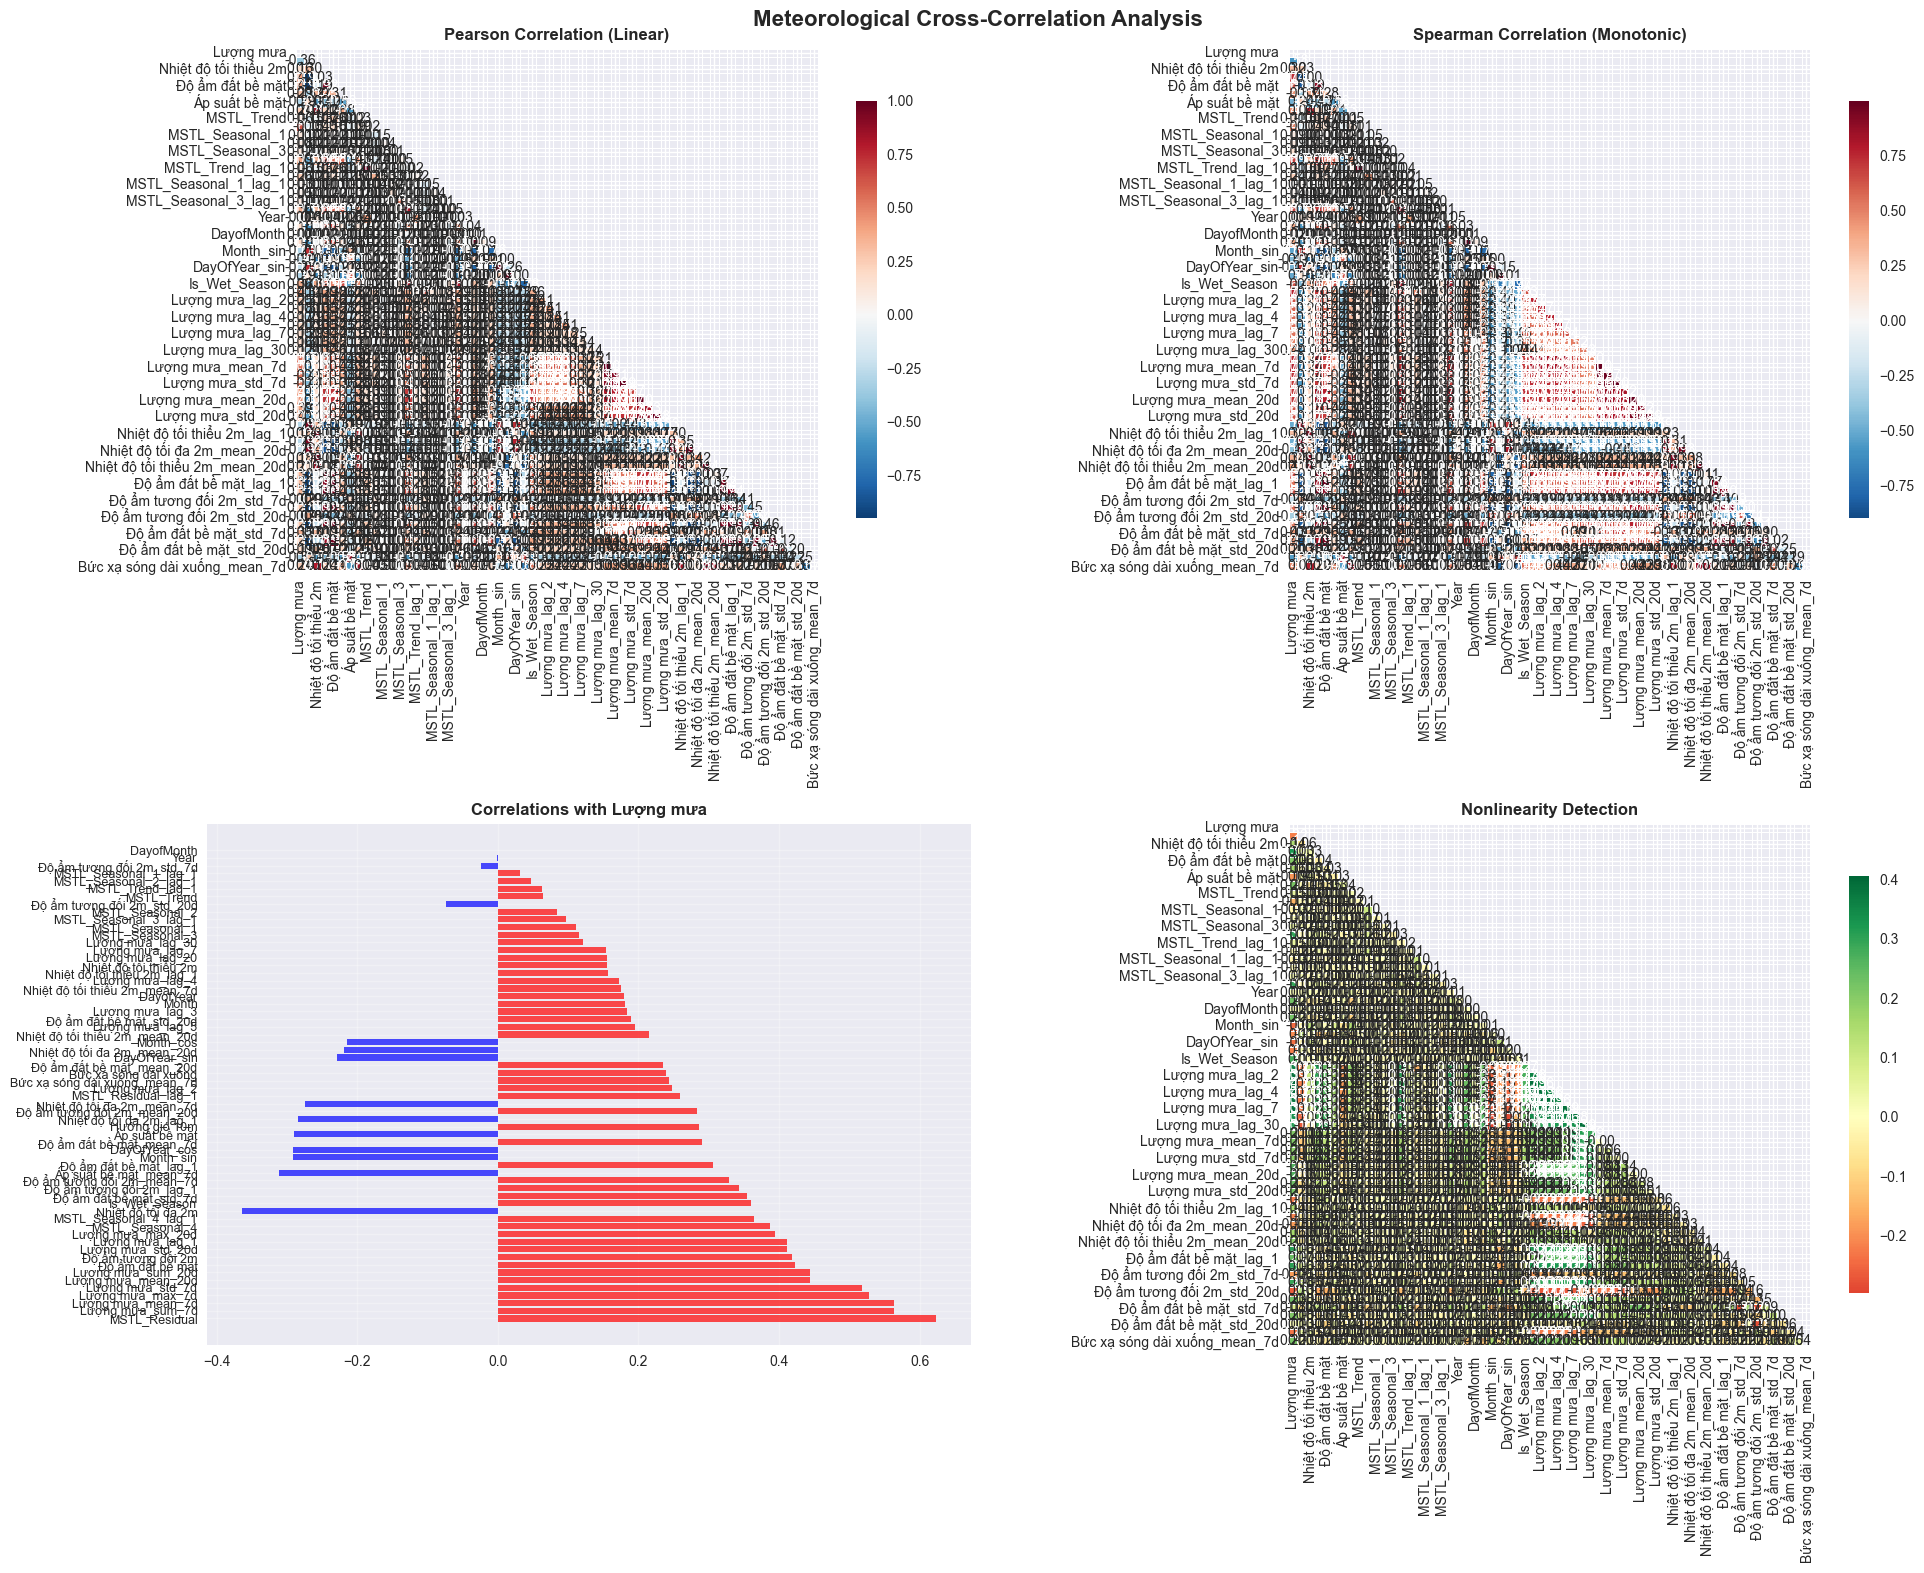

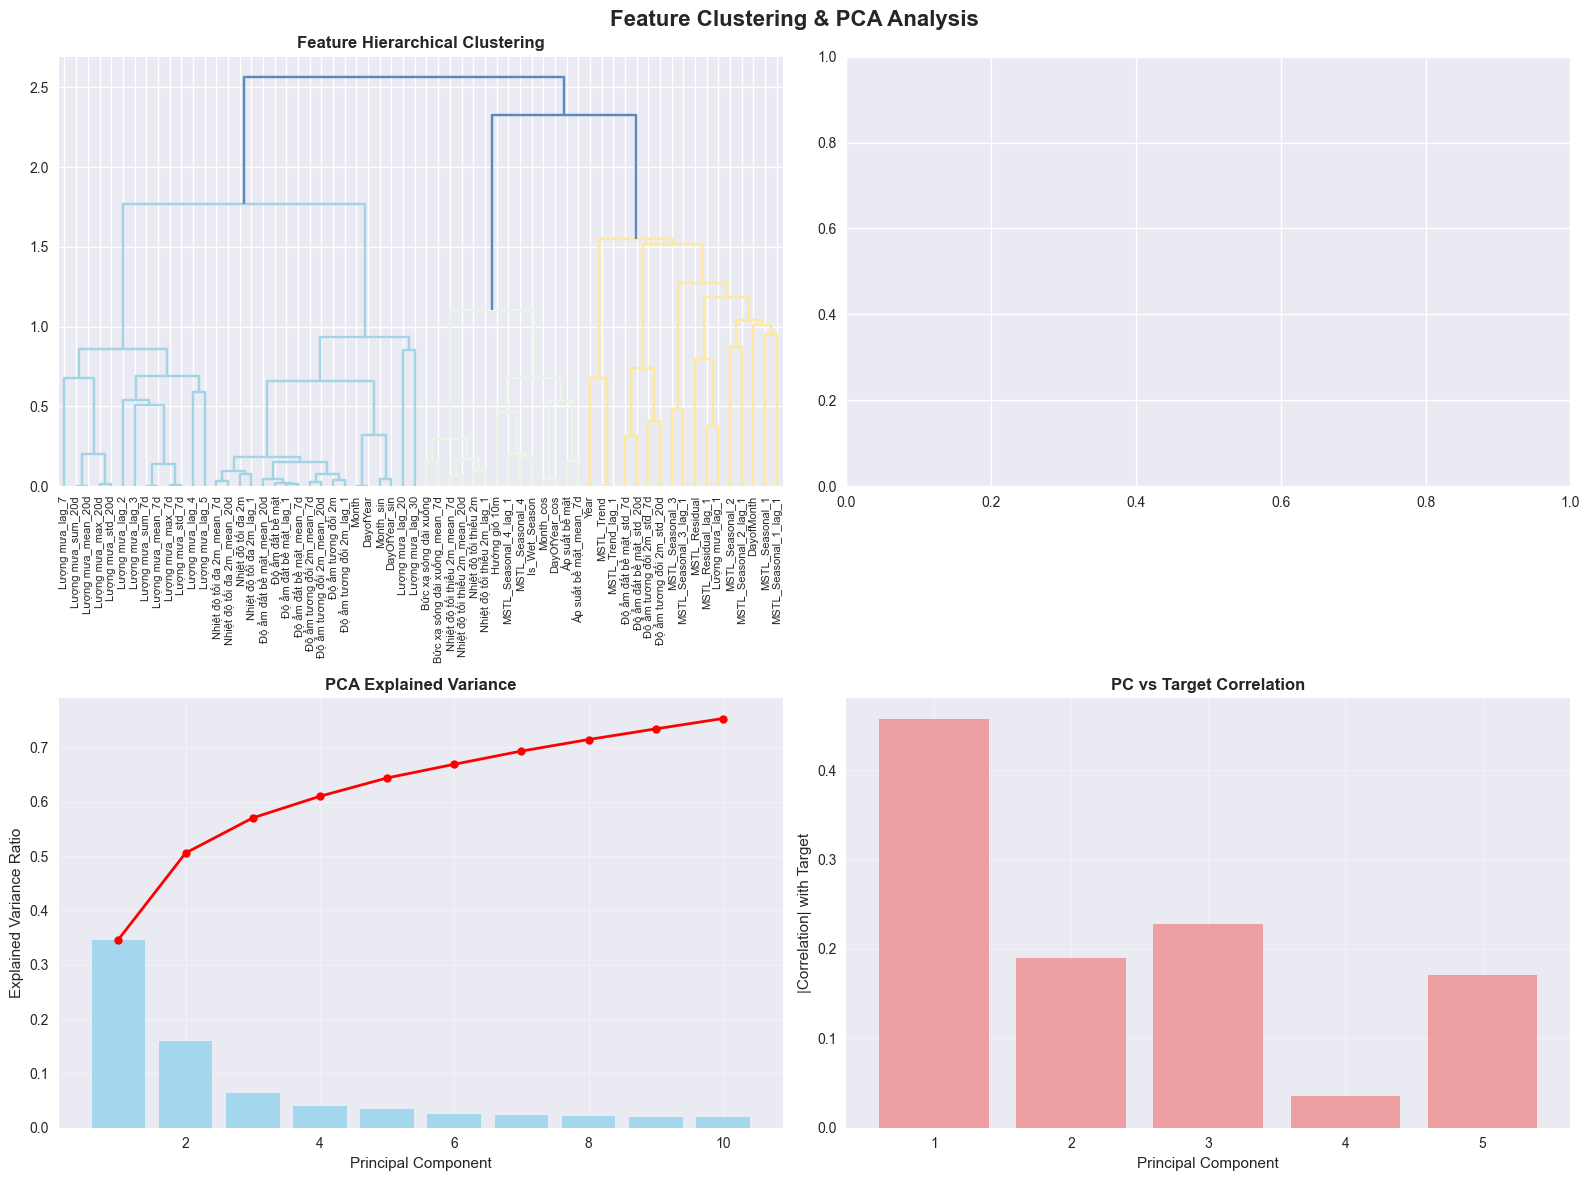

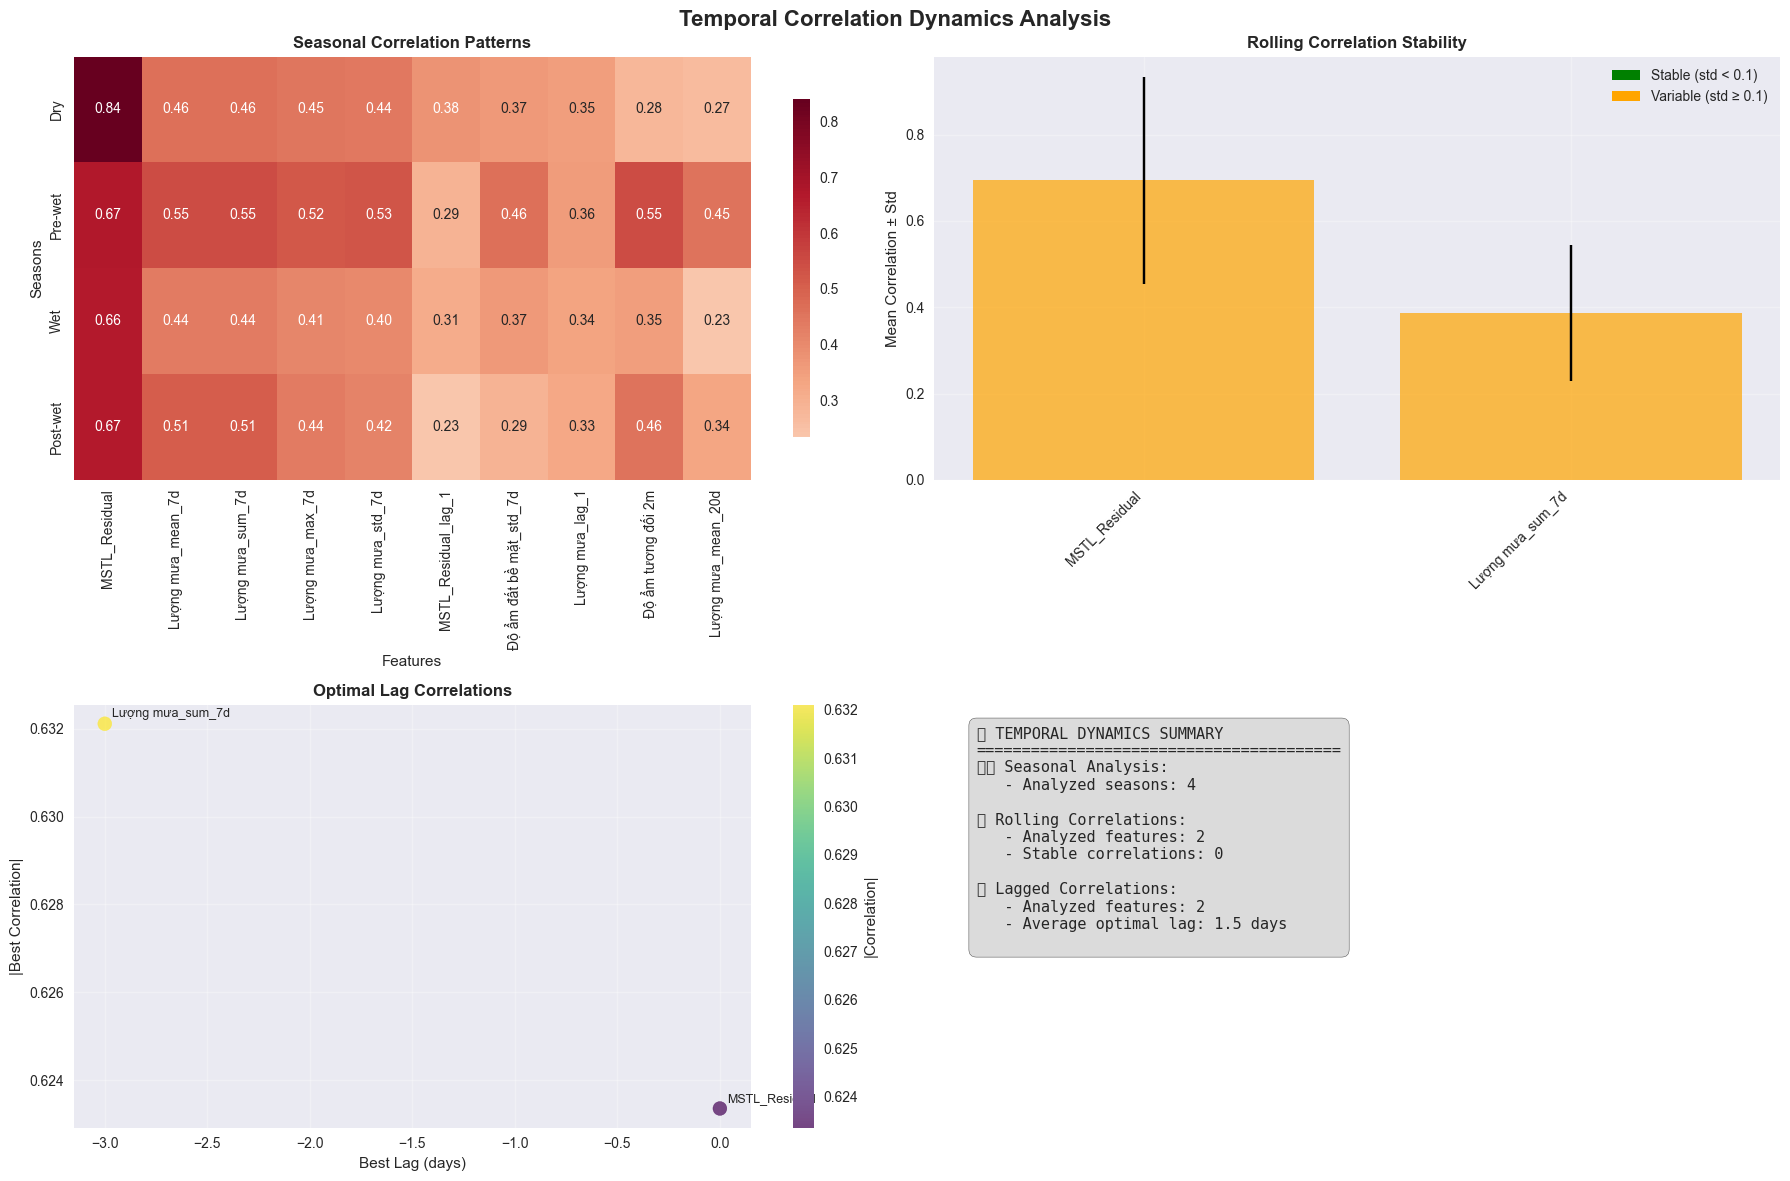

posx and posy should be finite values
posx and posy should be finite values


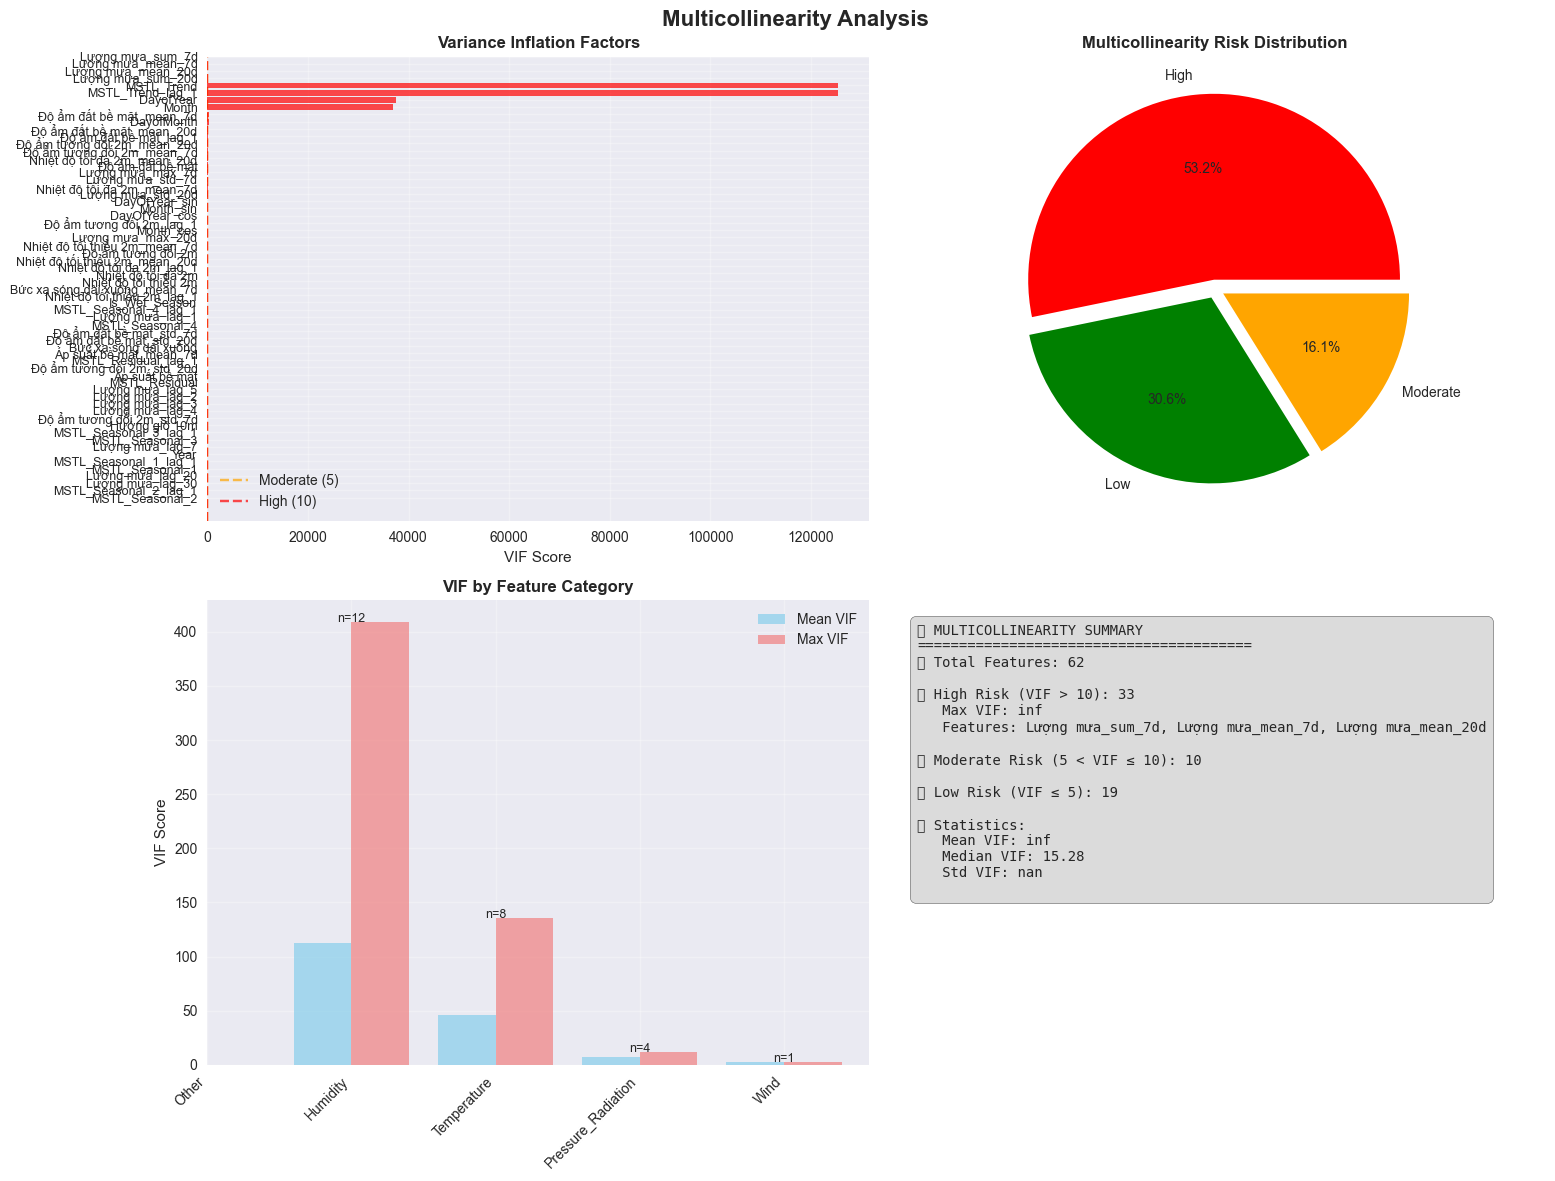

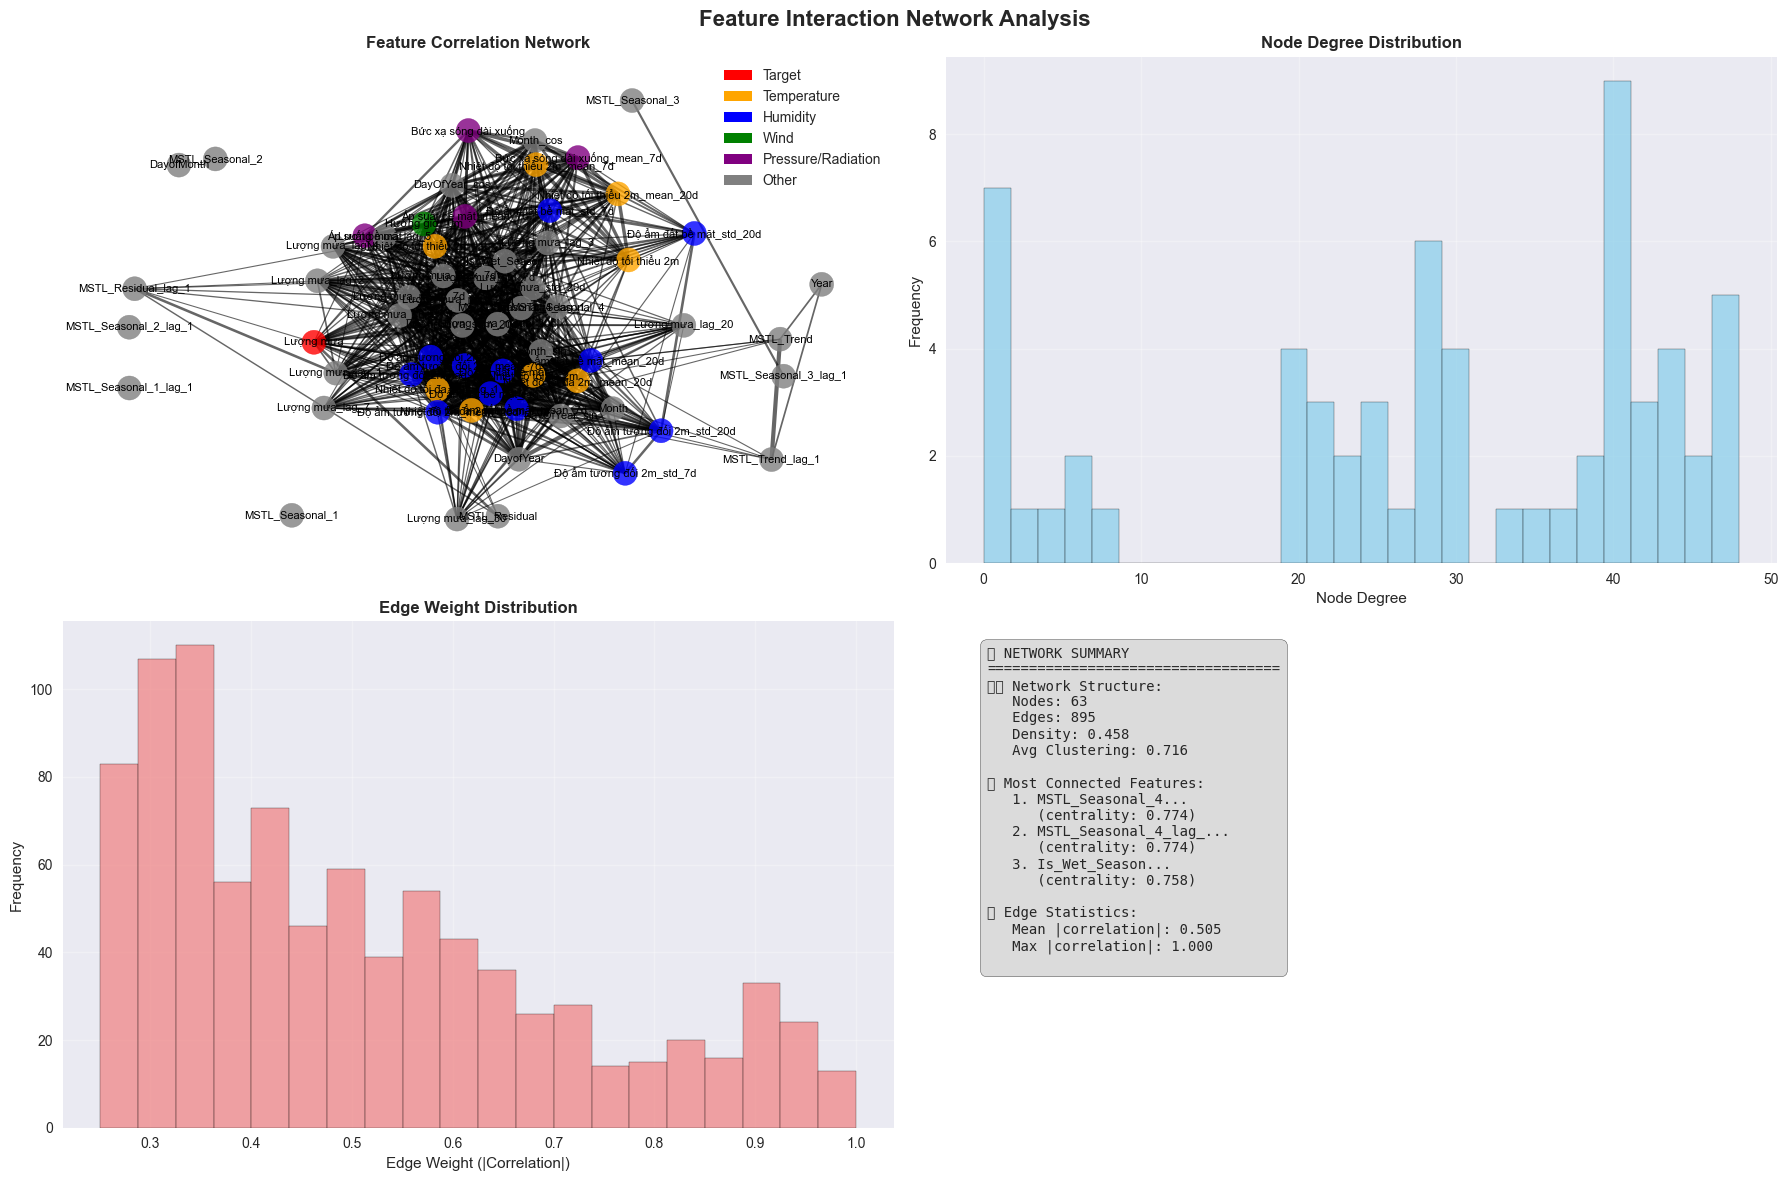


✅ CORRELATION ANALYSIS COMPLETED


In [32]:
from src.analysis.CorrelationAnalysis import analyze_correlations

# Chạy toàn bộ pipeline với visualization
results = analyze_correlations(df_final, target_col='Lượng mưa', date_col='Ngày', include_visualization=True)

# Modeling

## Tree-based model

In [34]:
# =============================================================================
# CORRECTED TREE-BASED MODELS PIPELINE - SETUP
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error, r2_score

# Import models with proper interface
from src.models.tree_models import RandomForestRainfallModel, LightGBMRainfallModel, XGBoostRainfallModel
from src.models.base import evaluate_rainfall_model
from src.config.constants import Config

# Setup
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🌳 CORRECTED TREE-BASED MODELS PIPELINE")
print("="*60)
print(f"📅 Start: {datetime.now().strftime('%H:%M:%S')}")

# Configuration
TARGET_COL = Config.COLUMN_MAPPING.get('PRECTOTCORR', 'Lượng mưa')
CLASSIFICATION_THRESHOLD = 0.1  # mm/day for rain classification
TEST_SIZE = 0.2
RANDOM_STATE = 42

print(f"🎯 Target: {TARGET_COL}")
print(f"🎯 Rain threshold: {CLASSIFICATION_THRESHOLD} mm/day") 
print(f"🎯 Test size: {TEST_SIZE}")

🌳 CORRECTED TREE-BASED MODELS PIPELINE
📅 Start: 14:43:29
🎯 Target: Lượng mưa
🎯 Rain threshold: 0.1 mm/day
🎯 Test size: 0.2


In [35]:
# =============================================================================
# CORRECTED DATA PREPARATION WITH COLUMN CLEANUP
# =============================================================================

import pandas as pd
import numpy as np
from src.config.constants import Config

print("\n📊 DATA PREPARATION")
print("="*40)

# Define constants from config
TARGET_COL = Config.COLUMN_MAPPING.get('PRECTOTCORR', 'Lượng mưa')
CLASSIFICATION_THRESHOLD = 0.1
TEST_SIZE = 0.2

# Drop unnecessary columns first
columns_to_drop = ['Ngày', 'Kinh độ', 'Vĩ độ']  # datetime and coordinate columns
existing_cols_to_drop = [col for col in columns_to_drop if col in df_final.columns]

print(f"🗑️ Dropping columns: {existing_cols_to_drop}")
df_clean = df_final.drop(columns=existing_cols_to_drop)

print(f"   Original columns: {len(df_final.columns)}")
print(f"   After cleanup: {len(df_clean.columns)}")

# Verify target column exists
if TARGET_COL not in df_clean.columns:
    print(f"❌ ERROR: Target column '{TARGET_COL}' not found!")
    print(f"Available columns: {list(df_clean.columns)}")
    raise ValueError(f"Target column '{TARGET_COL}' missing")

# Prepare features and target
feature_cols = [col for col in df_clean.columns if col != TARGET_COL]
X = df_clean[feature_cols].copy()
y = df_clean[TARGET_COL].copy()

# Remove missing values
print(f"\n🧹 CLEANING MISSING VALUES")
original_size = len(X)
mask = X.isnull().any(axis=1) | y.isnull()
X = X.loc[~mask]
y = y.loc[~mask]

print(f"   Original samples: {original_size:,}")
print(f"   Samples with missing values: {mask.sum():,}")
print(f"   Clean samples: {len(X):,}")
print(f"   Features: {len(feature_cols)}")

# Verify we have numeric data only
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_cols:
    print(f"⚠️ WARNING: Non-numeric columns found: {non_numeric_cols}")
    print("Converting or removing non-numeric columns...")
    X = X.select_dtypes(include=[np.number])
    feature_cols = X.columns.tolist()
    print(f"   Final numeric features: {len(feature_cols)}")

# Rain statistics
rain_count = (y > CLASSIFICATION_THRESHOLD).sum()
rain_pct = (rain_count / len(y)) * 100

print(f"\n📈 TARGET VARIABLE ANALYSIS")
print(f"   Total samples: {len(y):,}")
print(f"   Target range: {y.min():.3f} - {y.max():.3f} mm")
print(f"   Mean rainfall: {y.mean():.3f} mm")
print(f"   Rain events (>{CLASSIFICATION_THRESHOLD}mm): {rain_count:,} ({rain_pct:.1f}%)")
print(f"   No-rain events: {len(y) - rain_count:,} ({100-rain_pct:.1f}%)")

# Time series split (preserve temporal order)
split_idx = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"\n🔄 TRAIN/TEST SPLIT (Time Series)")
print(f"   Train: {len(X_train):,} samples ({100*(1-TEST_SIZE):.0f}%)")
print(f"   Test: {len(X_test):,} samples ({100*TEST_SIZE:.0f}%)")
print(f"   Train rain events: {(y_train > CLASSIFICATION_THRESHOLD).sum():,} ({(y_train > CLASSIFICATION_THRESHOLD).mean()*100:.1f}%)")
print(f"   Test rain events: {(y_test > CLASSIFICATION_THRESHOLD).sum():,} ({(y_test > CLASSIFICATION_THRESHOLD).mean()*100:.1f}%)")

# Feature categories breakdown
mstl_feats = [col for col in feature_cols if 'MSTL' in col]
lag_feats = [col for col in feature_cols if '_lag_' in col]
rolling_feats = [col for col in feature_cols if any(x in col for x in ['_mean_', '_std_', '_sum_'])]
weather_feats = [col for col in feature_cols if col not in mstl_feats + lag_feats + rolling_feats]

print(f"\n📊 FEATURE BREAKDOWN:")
print(f"   Weather features: {len(weather_feats)}")
print(f"   MSTL features: {len(mstl_feats)}")
print(f"   Lag features: {len(lag_feats)}")
print(f"   Rolling features: {len(rolling_feats)}")
print(f"   Total features: {len(feature_cols)}")

# Verify data quality
print(f"\n✅ DATA QUALITY CHECK:")
print(f"   Missing values in X_train: {X_train.isnull().sum().sum()}")
print(f"   Missing values in y_train: {y_train.isnull().sum()}")
print(f"   Infinite values in X_train: {np.isinf(X_train.values).sum()}")
print(f"   Infinite values in y_train: {np.isinf(y_train.values).sum()}")

print(f"\n🎯 DATA PREPARATION COMPLETE!")
print(f"   Ready for model training: ✅")


📊 DATA PREPARATION
🗑️ Dropping columns: ['Ngày']
   Original columns: 64
   After cleanup: 63

🧹 CLEANING MISSING VALUES
   Original samples: 9,222
   Samples with missing values: 0
   Clean samples: 9,222
   Features: 62

📈 TARGET VARIABLE ANALYSIS
   Total samples: 9,222
   Target range: 0.000 - 143.310 mm
   Mean rainfall: 3.941 mm
   Rain events (>0.1mm): 5,748 (62.3%)
   No-rain events: 3,474 (37.7%)

🔄 TRAIN/TEST SPLIT (Time Series)
   Train: 7,377 samples (80%)
   Test: 1,845 samples (20%)
   Train rain events: 4,505 (61.1%)
   Test rain events: 1,243 (67.4%)

📊 FEATURE BREAKDOWN:
   Weather features: 18
   MSTL features: 12
   Lag features: 18
   Rolling features: 20
   Total features: 62

✅ DATA QUALITY CHECK:
   Missing values in X_train: 0
   Missing values in y_train: 0
   Infinite values in X_train: 0
   Infinite values in y_train: 0

🎯 DATA PREPARATION COMPLETE!
   Ready for model training: ✅


In [36]:
# =============================================================================
# MODEL DEFINITIONS (CORRECTED INTERFACE)
# =============================================================================

print("\n⚙️ MODEL DEFINITIONS")
print("="*40)

# Create models with CORRECT constructor parameters
models_config = {
    # Random Forest - Two Stage
    'RF_TwoStage': RandomForestRainfallModel(
        use_two_stage=True,
        classification_threshold=CLASSIFICATION_THRESHOLD,
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=RANDOM_STATE
    ),
    
    # Random Forest - Single Stage  
    'RF_SingleStage': RandomForestRainfallModel(
        use_two_stage=False,
        classification_threshold=CLASSIFICATION_THRESHOLD,
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=RANDOM_STATE
    ),
    
    # LightGBM - Two Stage
    'LGB_TwoStage': LightGBMRainfallModel(
        use_two_stage=True,
        classification_threshold=CLASSIFICATION_THRESHOLD,
        num_boost_round=100,
        random_state=RANDOM_STATE
    ),
    
    # LightGBM - Single Stage
    'LGB_SingleStage': LightGBMRainfallModel(
        use_two_stage=False,
        classification_threshold=CLASSIFICATION_THRESHOLD,
        num_boost_round=100,
        random_state=RANDOM_STATE
    ),
    
    # XGBoost - Two Stage
    'XGB_TwoStage': XGBoostRainfallModel(
        use_two_stage=True,
        classification_threshold=CLASSIFICATION_THRESHOLD,
        random_state=RANDOM_STATE
    ),
    
    # XGBoost - Single Stage
    'XGB_SingleStage': XGBoostRainfallModel(
        use_two_stage=False,
        classification_threshold=CLASSIFICATION_THRESHOLD,
        random_state=RANDOM_STATE
    )
}

print(f"   Defined {len(models_config)} models:")
for name, model in models_config.items():
    approach = 'Two-Stage' if model.use_two_stage else 'Single-Stage'
    print(f"   • {name}: {approach}")


⚙️ MODEL DEFINITIONS
   Defined 6 models:
   • RF_TwoStage: Two-Stage
   • RF_SingleStage: Single-Stage
   • LGB_TwoStage: Two-Stage
   • LGB_SingleStage: Single-Stage
   • XGB_TwoStage: Two-Stage
   • XGB_SingleStage: Single-Stage


In [37]:
# =============================================================================
# TRAINING & EVALUATION (USING CORRECT INTERFACE)
# =============================================================================

print("\n🚀 TRAINING & EVALUATION")
print("="*40)

results = {}

for model_name, model in models_config.items():
    print(f"\n{'='*50}")
    print(f"🎯 {model_name}")
    print(f"{'='*50}")
    
    start_time = datetime.now()
    
    try:
        # Training using CORRECT interface: fit(X, y)
        print("   🔄 Training...")
        model.fit(X_train, y_train)  # BaseRainfallModel.fit() takes exactly 3 args
        training_time = (datetime.now() - start_time).total_seconds()
        print(f"   ✅ Training completed ({training_time:.1f}s)")
        
        # Evaluation using built-in function
        print("   🔄 Evaluating...")
        eval_results = evaluate_rainfall_model(model, X_test, y_test)
        
        # Store results with proper structure
        results[model_name] = {
            'model_type': model_name.split('_')[0],
            'approach': eval_results['approach'],
            'training_time': training_time,
            'evaluation': eval_results
        }
        
        # Print results
        if model.use_two_stage:
            clf_metrics = eval_results.get('classification', {})
            reg_metrics = eval_results.get('regression', {})
            combined_metrics = eval_results.get('combined', {})
            
            print(f"   📊 Classification AUC: {clf_metrics.get('ROC_AUC', 0):.4f}")
            print(f"   📊 Regression MAE: {reg_metrics.get('MAE', float('inf')):.4f}")
            print(f"   📊 Combined MAE: {combined_metrics.get('MAE', float('inf')):.4f}")
            print(f"   📊 Combined R²: {combined_metrics.get('R2', 0):.4f}")
        else:
            single_metrics = eval_results.get('single_stage', {})
            print(f"   📊 MAE: {single_metrics.get('MAE', float('inf')):.4f}")
            print(f"   📊 RMSE: {single_metrics.get('RMSE', float('inf')):.4f}")
            print(f"   📊 R²: {single_metrics.get('R2', 0):.4f}")
        
        print(f"   ✅ {model_name} completed successfully!")
        
    except Exception as e:
        print(f"   ❌ {model_name} failed: {str(e)}")
        results[model_name] = {
            'model_type': model_name.split('_')[0],
            'approach': 'Two-Stage' if model.use_two_stage else 'Single-Stage',
            'error': str(e)
        }

print(f"\n{'='*50}")
print("✅ ALL MODELS COMPLETED")
print(f"{'='*50}")


🚀 TRAINING & EVALUATION

🎯 RF_TwoStage
   🔄 Training...
🚀 Training RandomForestRainfallModel...
   Approach: Two-stage
   📊 Stage 1: Classification (4505 rain days / 7377 total)
   📈 Stage 2: Regression on 4505 rainy days
   ✅ Training completed
   ✅ Training completed (51.4s)
   🔄 Evaluating...
   📊 Classification AUC: 0.9739
   📊 Regression MAE: 1.8088
   📊 Combined MAE: 1.2541
   📊 Combined R²: 0.8453
   ✅ RF_TwoStage completed successfully!

🎯 RF_SingleStage
   🔄 Training...
🚀 Training RandomForestRainfallModel...
   Approach: Single-stage
   📈 Single-stage regression on all 7377 samples
   ✅ Training completed
   ✅ Training completed (97.1s)
   🔄 Evaluating...
   📊 MAE: 1.2632
   📊 RMSE: 3.5295
   📊 R²: 0.8338
   ✅ RF_SingleStage completed successfully!

🎯 LGB_TwoStage
   🔄 Training...
🚀 Training LightGBMRainfallModel...
   Approach: Two-stage
   📊 Stage 1: Classification (4505 rain days / 7377 total)
   📈 Stage 2: Regression on 4505 rainy days
   ✅ Training completed
   ✅ Traini

In [38]:
# =============================================================================
# RESULTS ANALYSIS & COMPARISON (FIXED BASED ON ACTUAL STRUCTURE)
# =============================================================================

print("\n📊 RESULTS ANALYSIS")
print("="*40)

comparison_data = []

for model_name, result in results.items():
    if 'error' in result:
        print(f"❌ {model_name}: {result['error']}")
        continue
    
    eval_data = result.get('evaluation', {})
    
    row = {
        'Model': model_name,
        'Approach': result['approach'].replace('_', '-').title(),  # 'Two-Stage' or 'Single-Stage'
        'Training_Time': result.get('training_time', 0)
    }
    
    if result['approach'] == 'two_stage':
        # Two-stage results - Use COMBINED metrics for overall performance
        clf_metrics = eval_data.get('classification', {})
        reg_metrics = eval_data.get('regression', {})      # Only rainy days
        combined_metrics = eval_data.get('combined', {})   # Full dataset - BETTER for comparison
        
        row.update({
            'Classification_AUC': clf_metrics.get('ROC_AUC', np.nan),
            'Overall_MAE': combined_metrics.get('MAE', np.nan),      # ✅ Use combined
            'Overall_RMSE': combined_metrics.get('RMSE', np.nan),    # ✅ Use combined  
            'Overall_R2': combined_metrics.get('R2', np.nan),        # ✅ Use combined
            'RainDays_MAE': reg_metrics.get('MAE', np.nan),          # Only rainy days
            'RainDays_RMSE': reg_metrics.get('RMSE', np.nan),        # Only rainy days
            'Rain_Days_Count': eval_data.get('rain_days_count', 0)
        })
    else:
        # Single-stage results
        single_metrics = eval_data.get('single_stage', {})  # ✅ CORRECT PATH
        
        row.update({
            'Classification_AUC': np.nan,
            'Overall_MAE': single_metrics.get('MAE', np.nan),
            'Overall_RMSE': single_metrics.get('RMSE', np.nan),      # ✅ NOW AVAILABLE
            'Overall_R2': single_metrics.get('R2', np.nan),
            'RainDays_MAE': np.nan,
            'RainDays_RMSE': np.nan,
            'Rain_Days_Count': eval_data.get('total_samples', 0)
        })
    
    comparison_data.append(row)

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

if not comparison_df.empty:
    print("\n🏆 PERFORMANCE COMPARISON:")
    print("="*120)
    
    # Display table WITH RMSE
    display_cols = ['Model', 'Approach', 'Classification_AUC', 'Overall_MAE', 
                   'Overall_RMSE', 'Overall_R2', 'Training_Time']
    print(comparison_df[display_cols].round(4).to_string(index=False))
    
    # Best performers
    print(f"\n🥇 BEST PERFORMERS:")
    print("="*50)
    
    # Best classification
    two_stage_models = comparison_df[comparison_df['Approach'] == 'Two-Stage']
    if not two_stage_models.empty and not two_stage_models['Classification_AUC'].isna().all():
        best_clf_idx = two_stage_models['Classification_AUC'].idxmax()
        best_clf = two_stage_models.loc[best_clf_idx]
        print(f"🎯 Best Classification: {best_clf['Model']} (AUC: {best_clf['Classification_AUC']:.4f})")
    
    # Best MAE
    if not comparison_df['Overall_MAE'].isna().all():
        best_mae_idx = comparison_df['Overall_MAE'].idxmin()
        best_mae = comparison_df.loc[best_mae_idx]
        print(f"📈 Best MAE: {best_mae['Model']} - {best_mae['Approach']} ({best_mae['Overall_MAE']:.4f})")
    
    # ✅ BEST RMSE
    if not comparison_df['Overall_RMSE'].isna().all():
        best_rmse_idx = comparison_df['Overall_RMSE'].idxmin()
        best_rmse = comparison_df.loc[best_rmse_idx]
        print(f"📈 Best RMSE: {best_rmse['Model']} - {best_rmse['Approach']} ({best_rmse['Overall_RMSE']:.4f})")
    
    # Best R²
    if not comparison_df['Overall_R2'].isna().all():
        best_r2_idx = comparison_df['Overall_R2'].idxmax()
        best_r2 = comparison_df.loc[best_r2_idx]
        print(f"📈 Best R²: {best_r2['Model']} - {best_r2['Approach']} ({best_r2['Overall_R2']:.4f})")
    
    # Fastest
    fastest_idx = comparison_df['Training_Time'].idxmin()
    fastest = comparison_df.loc[fastest_idx]
    print(f"⚡ Fastest Training: {fastest['Model']} - {fastest['Approach']} ({fastest['Training_Time']:.1f}s)")
    
    # Show detailed breakdown
    print(f"\n📋 DETAILED BREAKDOWN:")
    print("="*120)
    detail_cols = ['Model', 'Approach', 'Overall_MAE', 'Overall_RMSE', 'RainDays_MAE', 'RainDays_RMSE', 'Rain_Days_Count']
    print(comparison_df[detail_cols].round(4).to_string(index=False))
    
else:
    print("❌ No successful results to analyze")


📊 RESULTS ANALYSIS

🏆 PERFORMANCE COMPARISON:
          Model     Approach  Classification_AUC  Overall_MAE  Overall_RMSE  Overall_R2  Training_Time
    RF_TwoStage    Two-Stage              0.9739       1.2541        3.4055      0.8453        51.4315
 RF_SingleStage Single-Stage                 NaN       1.2632        3.5295      0.8338        97.0708
   LGB_TwoStage    Two-Stage              0.9883       0.8769        2.9772      0.8818         0.7323
LGB_SingleStage Single-Stage                 NaN       0.8974        2.9189      0.8863         0.3741
   XGB_TwoStage    Two-Stage              0.9865       1.0062        2.9547      0.8835         3.3550
XGB_SingleStage Single-Stage                 NaN       1.0426        3.0037      0.8796         0.8637

🥇 BEST PERFORMERS:
🎯 Best Classification: LGB_TwoStage (AUC: 0.9883)
📈 Best MAE: LGB_TwoStage - Two-Stage (0.8769)
📈 Best RMSE: LGB_SingleStage - Single-Stage (2.9189)
📈 Best R²: LGB_SingleStage - Single-Stage (0.8863)
⚡ Fastest Tr


📈 ENHANCED VISUALIZATION


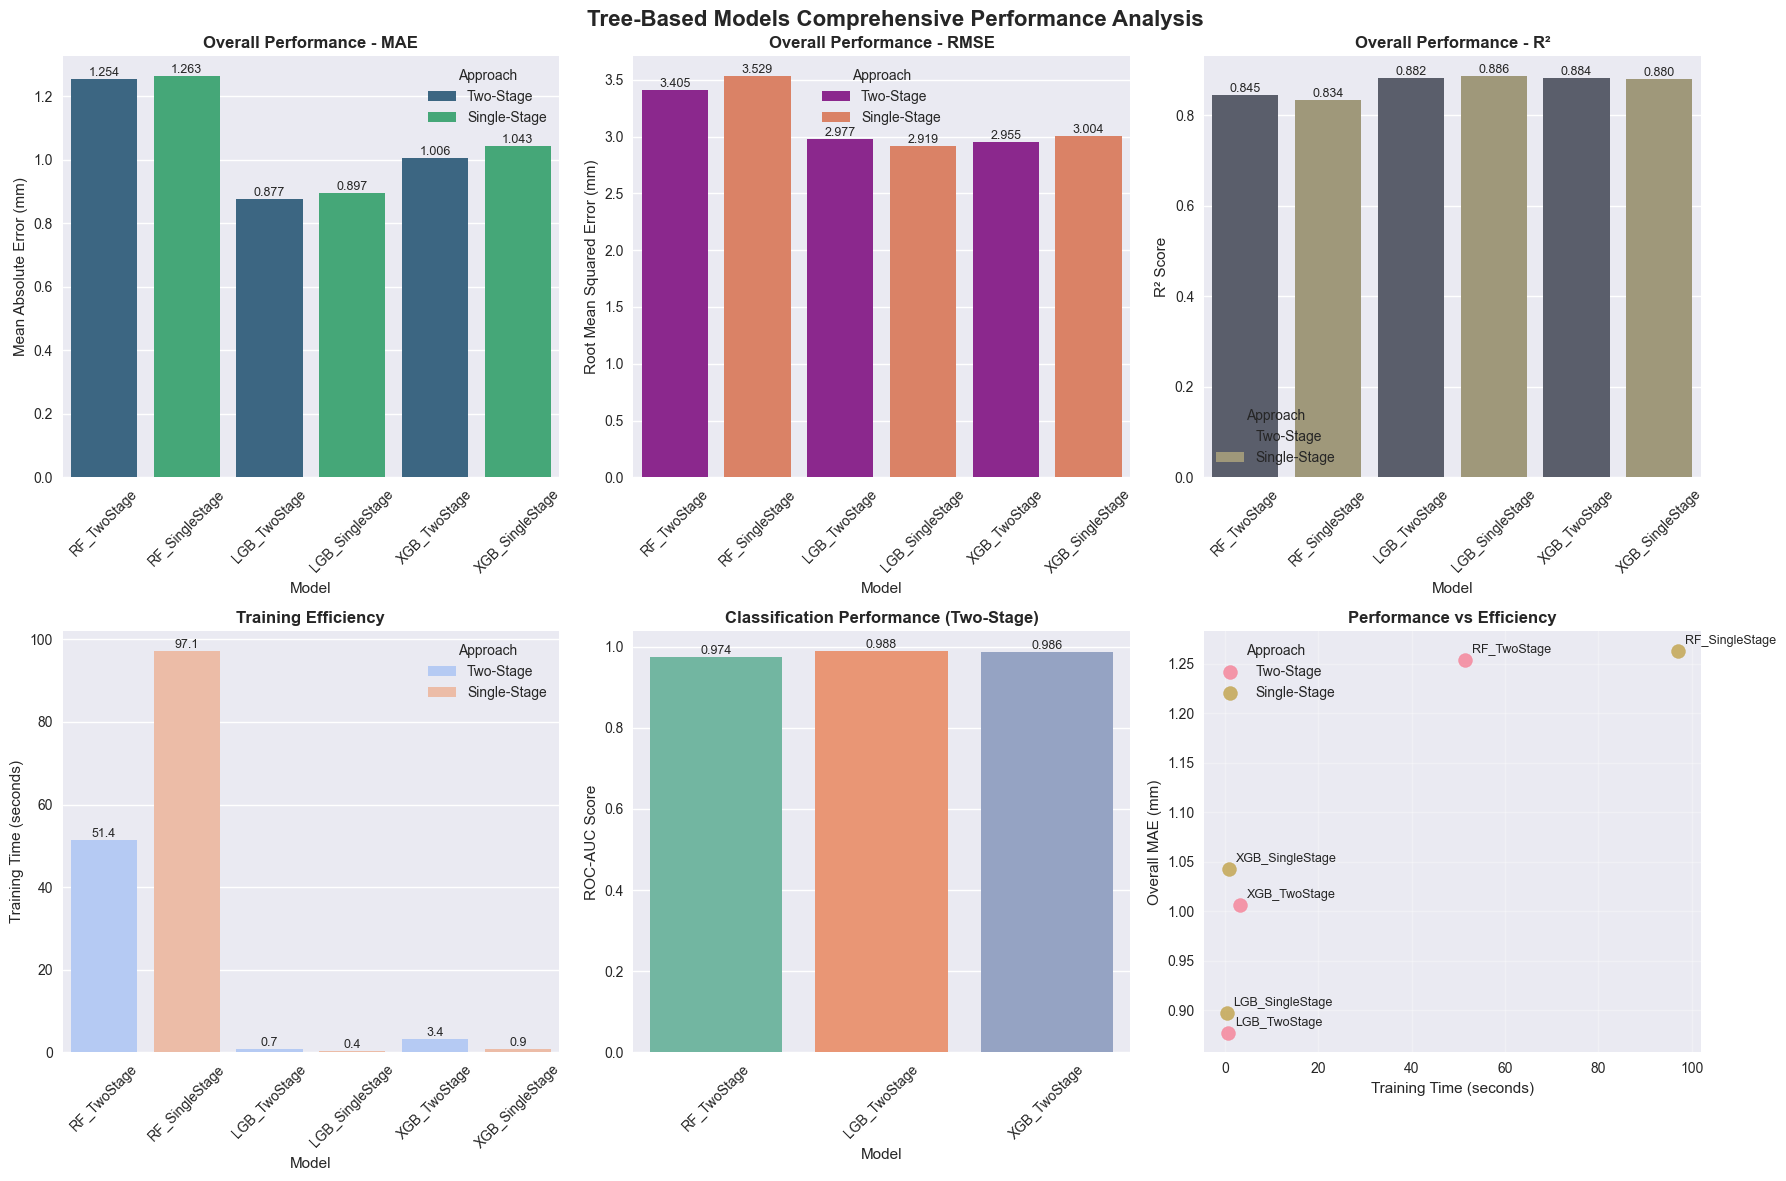


📊 ENHANCED PERFORMANCE SUMMARY:
Metric      Best_Model     Approach  Value          Direction
   MAE    LGB_TwoStage    Two-Stage 0.8769  ↓ Lower is better
  RMSE LGB_SingleStage Single-Stage 2.9189  ↓ Lower is better
    R2 LGB_SingleStage Single-Stage 0.8863 ↑ Higher is better

🏆 OVERALL CHAMPION:
🥇 Best Model: LGB_TwoStage - Two-Stage
   • MAE: 0.8769 mm
   • RMSE: 2.9772 mm
   • R²: 0.8818
   • Training Time: 0.7s
   • Classification AUC: 0.9883

⚡ Most Efficient: LGB_SingleStage - Single-Stage
   • Training Time: 0.4s
   • MAE: 0.8974 mm

⚖️ Best Balance (Performance/Time): LGB_SingleStage - Single-Stage
   • MAE: 0.8974 mm
   • Training Time: 0.4s

💡 RECOMMENDATIONS:
📌 For Production Use:
   • Choose model with lowest MAE for best accuracy
   • Consider training time if frequent retraining needed
   • Two-stage models provide interpretable rain/no-rain decisions

📌 For Further Analysis:
   • Examine feature importance of best model
   • Analyze prediction errors by season/weathe

In [39]:
# =============================================================================
# ENHANCED VISUALIZATION WITH RMSE & COMPREHENSIVE METRICS
# =============================================================================

print("\n📈 ENHANCED VISUALIZATION")
print("="*40)

if not comparison_df.empty and not comparison_df['Overall_MAE'].isna().all():
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Tree-Based Models Comprehensive Performance Analysis', fontsize=16, fontweight='bold')
    
    # Clean data for plotting
    clean_data = comparison_df.dropna(subset=['Overall_MAE', 'Overall_RMSE', 'Overall_R2'])
    
    if not clean_data.empty:
        # 1. Overall MAE Comparison
        ax1 = axes[0, 0]
        sns.barplot(data=clean_data, x='Model', y='Overall_MAE', hue='Approach', ax=ax1, palette='viridis')
        ax1.set_title('Overall Performance - MAE', fontweight='bold')
        ax1.set_ylabel('Mean Absolute Error (mm)')
        ax1.legend(title='Approach')
        ax1.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for container in ax1.containers:
            ax1.bar_label(container, fmt='%.3f', fontsize=9)
        
        # 2. Overall RMSE Comparison
        ax2 = axes[0, 1]
        sns.barplot(data=clean_data, x='Model', y='Overall_RMSE', hue='Approach', ax=ax2, palette='plasma')
        ax2.set_title('Overall Performance - RMSE', fontweight='bold')
        ax2.set_ylabel('Root Mean Squared Error (mm)')
        ax2.legend(title='Approach')
        ax2.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for container in ax2.containers:
            ax2.bar_label(container, fmt='%.3f', fontsize=9)
        
        # 3. Overall R² Comparison
        ax3 = axes[0, 2]
        sns.barplot(data=clean_data, x='Model', y='Overall_R2', hue='Approach', ax=ax3, palette='cividis')
        ax3.set_title('Overall Performance - R²', fontweight='bold')
        ax3.set_ylabel('R² Score')
        ax3.legend(title='Approach')
        ax3.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for container in ax3.containers:
            ax3.bar_label(container, fmt='%.3f', fontsize=9)
        
        # 4. Training Time Comparison
        ax4 = axes[1, 0]
        sns.barplot(data=comparison_df, x='Model', y='Training_Time', hue='Approach', ax=ax4, palette='coolwarm')
        ax4.set_title('Training Efficiency', fontweight='bold')
        ax4.set_ylabel('Training Time (seconds)')
        ax4.legend(title='Approach')
        ax4.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for container in ax4.containers:
            ax4.bar_label(container, fmt='%.1f', fontsize=9)
        
        # 5. Classification Performance (Two-stage only)
        ax5 = axes[1, 1]
        two_stage_data = clean_data[clean_data['Approach'] == 'Two-Stage'].dropna(subset=['Classification_AUC'])
        if not two_stage_data.empty:
            sns.barplot(data=two_stage_data, x='Model', y='Classification_AUC', ax=ax5, palette='Set2')
            ax5.set_title('Classification Performance (Two-Stage)', fontweight='bold')
            ax5.set_ylabel('ROC-AUC Score')
            ax5.tick_params(axis='x', rotation=45)
            
            # Add value labels on bars
            for container in ax5.containers:
                ax5.bar_label(container, fmt='%.3f', fontsize=9)
        else:
            ax5.text(0.5, 0.5, 'No Two-Stage Models\nwith Classification Results', 
                    ha='center', va='center', transform=ax5.transAxes, fontsize=12)
            ax5.set_title('Classification Performance', fontweight='bold')
        
        # 6. Performance vs Efficiency Scatter Plot
        ax6 = axes[1, 2]
        scatter_data = clean_data.copy()
        
        # Create scatter plot
        for approach in scatter_data['Approach'].unique():
            approach_data = scatter_data[scatter_data['Approach'] == approach]
            ax6.scatter(approach_data['Training_Time'], approach_data['Overall_MAE'], 
                       label=approach, s=100, alpha=0.7)
            
            # Add model labels
            for idx, row in approach_data.iterrows():
                ax6.annotate(row['Model'], 
                           (row['Training_Time'], row['Overall_MAE']),
                           xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        ax6.set_xlabel('Training Time (seconds)')
        ax6.set_ylabel('Overall MAE (mm)')
        ax6.set_title('Performance vs Efficiency', fontweight='bold')
        ax6.legend(title='Approach')
        ax6.grid(True, alpha=0.3)
    
    else:
        # No clean data available
        for ax in axes.flat:
            ax.text(0.5, 0.5, 'No Valid Data\nfor Visualization', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced Summary Table
    print(f"\n📊 ENHANCED PERFORMANCE SUMMARY:")
    print("="*100)
    
    if not clean_data.empty:
        # Create summary metrics
        summary_stats = []
        
        for metric in ['Overall_MAE', 'Overall_RMSE', 'Overall_R2']:
            if metric in clean_data.columns and not clean_data[metric].isna().all():
                if metric == 'Overall_R2':
                    best_idx = clean_data[metric].idxmax()
                    direction = "↑ Higher is better"
                else:
                    best_idx = clean_data[metric].idxmin()
                    direction = "↓ Lower is better"
                
                best_model = clean_data.loc[best_idx]
                summary_stats.append({
                    'Metric': metric.replace('Overall_', ''),
                    'Best_Model': best_model['Model'],
                    'Approach': best_model['Approach'],
                    'Value': best_model[metric],
                    'Direction': direction
                })
        
        summary_df = pd.DataFrame(summary_stats)
        print(summary_df.to_string(index=False, float_format='%.4f'))
        
        # Overall champion
        print(f"\n🏆 OVERALL CHAMPION:")
        print("="*50)
        
        # Rank by MAE (primary metric for rainfall prediction)
        best_overall = clean_data.loc[clean_data['Overall_MAE'].idxmin()]
        print(f"🥇 Best Model: {best_overall['Model']} - {best_overall['Approach']}")
        print(f"   • MAE: {best_overall['Overall_MAE']:.4f} mm")
        print(f"   • RMSE: {best_overall['Overall_RMSE']:.4f} mm")
        print(f"   • R²: {best_overall['Overall_R2']:.4f}")
        print(f"   • Training Time: {best_overall['Training_Time']:.1f}s")
        
        if best_overall['Approach'] == 'Two-Stage' and not pd.isna(best_overall.get('Classification_AUC')):
            print(f"   • Classification AUC: {best_overall['Classification_AUC']:.4f}")
        
        # Efficiency champion
        fastest_model = comparison_df.loc[comparison_df['Training_Time'].idxmin()]
        print(f"\n⚡ Most Efficient: {fastest_model['Model']} - {fastest_model['Approach']}")
        print(f"   • Training Time: {fastest_model['Training_Time']:.1f}s")
        if not pd.isna(fastest_model.get('Overall_MAE')):
            print(f"   • MAE: {fastest_model['Overall_MAE']:.4f} mm")
        
        # Balance champion (performance/time ratio)
        if 'Overall_MAE' in clean_data.columns and 'Training_Time' in clean_data.columns:
            clean_data['Efficiency_Score'] = clean_data['Training_Time'] / (1 / clean_data['Overall_MAE'])  # Lower is better
            balanced_idx = clean_data['Efficiency_Score'].idxmin()
            balanced_model = clean_data.loc[balanced_idx]
            print(f"\n⚖️ Best Balance (Performance/Time): {balanced_model['Model']} - {balanced_model['Approach']}")
            print(f"   • MAE: {balanced_model['Overall_MAE']:.4f} mm")
            print(f"   • Training Time: {balanced_model['Training_Time']:.1f}s")
    
    else:
        print("❌ No valid data for enhanced summary")
    
    # Recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    print("="*50)
    print("📌 For Production Use:")
    print("   • Choose model with lowest MAE for best accuracy")
    print("   • Consider training time if frequent retraining needed")
    print("   • Two-stage models provide interpretable rain/no-rain decisions")
    print("\n📌 For Further Analysis:")
    print("   • Examine feature importance of best model")
    print("   • Analyze prediction errors by season/weather patterns")
    print("   • Consider ensemble methods combining top performers")

else:
    print("❌ No data available for visualization")

print(f"\n✅ Enhanced visualization and analysis completed!")
print(f"📅 End: {datetime.now().strftime('%H:%M:%S')}")

## Linear Regression Model

In [40]:
# =============================================================================
# LINEAR MODELS PIPELINE - SETUP WITH df_selected
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error, r2_score

# Import linear models
from src.models.linear_models import LinearRainfallModel
from src.models.base import evaluate_rainfall_model
from src.config.constants import Config

# Setup
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

print("📈 LINEAR MODELS PIPELINE (with Feature Selection)")
print("="*60)
print(f"📅 Start: {datetime.now().strftime('%H:%M:%S')}")

# Configuration
TARGET_COL = Config.COLUMN_MAPPING.get('PRECTOTCORR', 'Lượng mưa')
CLASSIFICATION_THRESHOLD = 0.1
TEST_SIZE = 0.2
RANDOM_STATE = 42

print(f"🎯 Target: {TARGET_COL}")
print(f"🎯 Rain threshold: {CLASSIFICATION_THRESHOLD} mm/day")

📈 LINEAR MODELS PIPELINE (with Feature Selection)
📅 Start: 14:46:09
🎯 Target: Lượng mưa
🎯 Rain threshold: 0.1 mm/day


In [41]:
# =============================================================================
# DATA PREPARATION - df_selected WITHOUT MSTL FEATURES
# =============================================================================

print("\n📊 DATA PREPARATION FROM df_selected")
print("="*40)

# Check if df_selected exists
if 'df_selected' not in locals():
    print("❌ ERROR: df_selected not found!")
    print("Please ensure feature selection has been completed first.")
    raise ValueError("df_selected not available")

print(f"📊 Original df_selected shape: {df_selected.shape}")

# Drop MSTL features
mstl_features = [col for col in df_selected.columns if 'MSTL' in col.upper()]
print(f"🗑️ Dropping {len(mstl_features)} MSTL features: {mstl_features}")

df_no_mstl = df_selected.drop(columns=mstl_features)
print(f"📊 After dropping MSTL: {df_no_mstl.shape}")

# Drop coordinate/time columns if present
columns_to_drop = ['Ngày', 'Kinh độ', 'Vĩ độ']
existing_cols_to_drop = [col for col in columns_to_drop if col in df_no_mstl.columns]
if existing_cols_to_drop:
    print(f"🗑️ Dropping additional columns: {existing_cols_to_drop}")
    df_no_mstl = df_no_mstl.drop(columns=existing_cols_to_drop)

# Verify target column
if TARGET_COL not in df_no_mstl.columns:
    print(f"❌ ERROR: Target column '{TARGET_COL}' not found!")
    print(f"Available columns: {list(df_no_mstl.columns)}")
    raise ValueError(f"Target column '{TARGET_COL}' missing")

# Prepare features and target
feature_cols = [col for col in df_no_mstl.columns if col != TARGET_COL]
X_linear = df_no_mstl[feature_cols].copy()
y_linear = df_no_mstl[TARGET_COL].copy()

# Clean missing values
print(f"\n🧹 CLEANING DATA")
original_size = len(X_linear)
mask = X_linear.isnull().any(axis=1) | y_linear.isnull()
X_linear = X_linear.loc[~mask]
y_linear = y_linear.loc[~mask]

print(f"   Original samples: {original_size:,}")
print(f"   Clean samples: {len(X_linear):,}")
print(f"   Features: {len(feature_cols)}")

# Ensure numeric data only
non_numeric_cols = X_linear.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_cols:
    print(f"⚠️ Converting non-numeric columns: {non_numeric_cols}")
    X_linear = X_linear.select_dtypes(include=[np.number])
    feature_cols = X_linear.columns.tolist()

# Time series split
split_idx = int(len(X_linear) * (1 - TEST_SIZE))
X_train_linear, X_test_linear = X_linear.iloc[:split_idx], X_linear.iloc[split_idx:]
y_train_linear, y_test_linear = y_linear.iloc[:split_idx], y_linear.iloc[split_idx:]

# Statistics
rain_count_train = (y_train_linear > CLASSIFICATION_THRESHOLD).sum()
rain_count_test = (y_test_linear > CLASSIFICATION_THRESHOLD).sum()

print(f"\n📈 DATASET STATISTICS:")
print(f"   Total features: {len(feature_cols)}")
print(f"   Train samples: {len(X_train_linear):,}")
print(f"   Test samples: {len(X_test_linear):,}")
print(f"   Train rain events: {rain_count_train:,} ({rain_count_train/len(y_train_linear)*100:.1f}%)")
print(f"   Test rain events: {rain_count_test:,} ({rain_count_test/len(y_test_linear)*100:.1f}%)")

print(f"\n✅ Linear models data ready!")


📊 DATA PREPARATION FROM df_selected
📊 Original df_selected shape: (9252, 64)
🗑️ Dropping 12 MSTL features: ['MSTL_Trend', 'MSTL_Residual', 'MSTL_Seasonal_1', 'MSTL_Seasonal_2', 'MSTL_Seasonal_3', 'MSTL_Seasonal_4', 'MSTL_Trend_lag_1', 'MSTL_Residual_lag_1', 'MSTL_Seasonal_1_lag_1', 'MSTL_Seasonal_2_lag_1', 'MSTL_Seasonal_3_lag_1', 'MSTL_Seasonal_4_lag_1']
📊 After dropping MSTL: (9252, 52)
🗑️ Dropping additional columns: ['Ngày']

🧹 CLEANING DATA
   Original samples: 9,252
   Clean samples: 9,222
   Features: 50

📈 DATASET STATISTICS:
   Total features: 50
   Train samples: 7,377
   Test samples: 1,845
   Train rain events: 4,505 (61.1%)
   Test rain events: 1,243 (67.4%)

✅ Linear models data ready!


In [42]:
# =============================================================================
# LINEAR MODEL DEFINITIONS - ALL 6 VARIANTS
# =============================================================================

print("\n⚙️ LINEAR MODEL DEFINITIONS")
print("="*40)

# Alpha values for regularization
RIDGE_ALPHA = 1.0    # Balanced L2 regularization
LASSO_ALPHA = 0.1    # Balanced L1 regularization (with feature selection)

linear_models_config = {
    # Ridge Regression (L2 Regularization)
    'Linear_Ridge_TwoStage': LinearRainfallModel(
        use_two_stage=True,
        classification_threshold=CLASSIFICATION_THRESHOLD,
        regression_type='ridge',
        alpha=RIDGE_ALPHA,
        normalize_features=True,  # ✅ Feature scaling enabled
        random_state=RANDOM_STATE
    ),
    
    'Linear_Ridge_SingleStage': LinearRainfallModel(
        use_two_stage=False,
        classification_threshold=CLASSIFICATION_THRESHOLD,
        regression_type='ridge',
        alpha=RIDGE_ALPHA,
        normalize_features=True,
        random_state=RANDOM_STATE
    ),
    
    # Lasso Regression (L1 Regularization + Feature Selection)
    'Linear_Lasso_TwoStage': LinearRainfallModel(
        use_two_stage=True,
        classification_threshold=CLASSIFICATION_THRESHOLD,
        regression_type='lasso',
        alpha=LASSO_ALPHA,
        normalize_features=True,
        random_state=RANDOM_STATE
    ),
    
    'Linear_Lasso_SingleStage': LinearRainfallModel(
        use_two_stage=False,
        classification_threshold=CLASSIFICATION_THRESHOLD,
        regression_type='lasso',
        alpha=LASSO_ALPHA,
        normalize_features=True,
        random_state=RANDOM_STATE
    ),
    
    # Plain Linear Regression (No Regularization)
    'Linear_Plain_TwoStage': LinearRainfallModel(
        use_two_stage=True,
        classification_threshold=CLASSIFICATION_THRESHOLD,
        regression_type='linear',
        alpha=0.0,  # No regularization
        normalize_features=True,
        random_state=RANDOM_STATE
    ),
    
    'Linear_Plain_SingleStage': LinearRainfallModel(
        use_two_stage=False,
        classification_threshold=CLASSIFICATION_THRESHOLD,
        regression_type='linear',
        alpha=0.0,
        normalize_features=True,
        random_state=RANDOM_STATE
    )
}

print(f"   Defined {len(linear_models_config)} linear models:")
for name, model in linear_models_config.items():
    approach = 'Two-Stage' if model.use_two_stage else 'Single-Stage'
    reg_type = model.regression_type.title()
    alpha_str = f"α={model.alpha}" if model.alpha > 0 else "No Reg"
    print(f"   • {name}: {approach} {reg_type} ({alpha_str})")

print(f"\n🔧 Regularization Settings:")
print(f"   • Ridge Alpha: {RIDGE_ALPHA} (L2 regularization)")
print(f"   • Lasso Alpha: {LASSO_ALPHA} (L1 + feature selection)")
print(f"   • Feature Scaling: ✅ Enabled (StandardScaler)")


⚙️ LINEAR MODEL DEFINITIONS
   Defined 6 linear models:
   • Linear_Ridge_TwoStage: Two-Stage Ridge (α=1.0)
   • Linear_Ridge_SingleStage: Single-Stage Ridge (α=1.0)
   • Linear_Lasso_TwoStage: Two-Stage Lasso (α=0.1)
   • Linear_Lasso_SingleStage: Single-Stage Lasso (α=0.1)
   • Linear_Plain_TwoStage: Two-Stage Linear (No Reg)
   • Linear_Plain_SingleStage: Single-Stage Linear (No Reg)

🔧 Regularization Settings:
   • Ridge Alpha: 1.0 (L2 regularization)
   • Lasso Alpha: 0.1 (L1 + feature selection)
   • Feature Scaling: ✅ Enabled (StandardScaler)


In [43]:
# =============================================================================
# LINEAR MODELS TRAINING & EVALUATION
# =============================================================================

print("\n🚀 LINEAR MODELS TRAINING & EVALUATION")
print("="*60)

linear_results = {}

for model_name, model in linear_models_config.items():
    print(f"\n{'='*60}")
    print(f"📈 {model_name}")
    print(f"{'='*60}")
    
    start_time = datetime.now()
    
    try:
        # Training using CORRECT interface: fit(X, y)
        print("   🔄 Training...")
        print(f"   • Regression Type: {model.regression_type.title()}")
        print(f"   • Alpha: {model.alpha}")
        print(f"   • Feature Scaling: {'✅' if model.normalize_features else '❌'}")
        
        model.fit(X_train_linear, y_train_linear)
        training_time = (datetime.now() - start_time).total_seconds()
        print(f"   ✅ Training completed ({training_time:.1f}s)")
        
        # Evaluation using built-in function
        print("   🔄 Evaluating...")
        eval_results = evaluate_rainfall_model(model, X_test_linear, y_test_linear)
        
        # Store results with proper structure
        linear_results[model_name] = {
            'model_type': f"Linear_{model.regression_type.title()}",
            'approach': eval_results['approach'],
            'training_time': training_time,
            'evaluation': eval_results,
            'regularization': {
                'type': model.regression_type,
                'alpha': model.alpha,
                'feature_scaling': model.normalize_features
            }
        }
        
        # Print results
        if model.use_two_stage:
            clf_metrics = eval_results.get('classification', {})
            reg_metrics = eval_results.get('regression', {})
            combined_metrics = eval_results.get('combined', {})
            
            print(f"   📊 Classification AUC: {clf_metrics.get('ROC_AUC', 0):.4f}")
            print(f"   📊 Regression MAE: {reg_metrics.get('MAE', float('inf')):.4f}")
            print(f"   📊 Regression RMSE: {reg_metrics.get('RMSE', float('inf')):.4f}")
            print(f"   📊 Combined MAE: {combined_metrics.get('MAE', float('inf')):.4f}")
            print(f"   📊 Combined RMSE: {combined_metrics.get('RMSE', float('inf')):.4f}")
            print(f"   📊 Combined R²: {combined_metrics.get('R2', 0):.4f}")
        else:
            single_metrics = eval_results.get('single_stage', {})
            print(f"   📊 MAE: {single_metrics.get('MAE', float('inf')):.4f}")
            print(f"   📊 RMSE: {single_metrics.get('RMSE', float('inf')):.4f}")
            print(f"   📊 R²: {single_metrics.get('R2', 0):.4f}")
        
        print(f"   ✅ {model_name} completed successfully!")
        
    except Exception as e:
        print(f"   ❌ {model_name} failed: {str(e)}")
        linear_results[model_name] = {
            'model_type': f"Linear_{model.regression_type.title()}",
            'approach': 'Two-Stage' if model.use_two_stage else 'Single-Stage',
            'error': str(e),
            'regularization': {
                'type': model.regression_type,
                'alpha': model.alpha,
                'feature_scaling': model.normalize_features
            }
        }

print(f"\n{'='*60}")
print("✅ ALL LINEAR MODELS COMPLETED")
print(f"{'='*60}")


🚀 LINEAR MODELS TRAINING & EVALUATION

📈 Linear_Ridge_TwoStage
   🔄 Training...
   • Regression Type: Ridge
   • Alpha: 1.0
   • Feature Scaling: ✅
🚀 Training LinearRainfallModel...
   Approach: Two-stage
   📊 Stage 1: Logistic Regression (4505 rain days / 7377 total)
   📈 Stage 2: Ridge Regression on 4505 rainy days
   ✅ Training completed
   ✅ Training completed (0.4s)
   🔄 Evaluating...
   📊 Classification AUC: 0.9588
   📊 Regression MAE: 2.6336
   📊 Regression RMSE: 4.4552
   📊 Combined MAE: 1.8711
   📊 Combined RMSE: 3.6974
   📊 Combined R²: 0.8176
   ✅ Linear_Ridge_TwoStage completed successfully!

📈 Linear_Ridge_SingleStage
   🔄 Training...
   • Regression Type: Ridge
   • Alpha: 1.0
   • Feature Scaling: ✅
🚀 Training LinearRainfallModel...
   Approach: Single-stage
   📈 Single-stage Ridge Regression on all 7377 samples
   ✅ Training completed
   ✅ Training completed (0.0s)
   🔄 Evaluating...
   📊 MAE: 2.0515
   📊 RMSE: 3.8326
   📊 R²: 0.8040
   ✅ Linear_Ridge_SingleStage compl

In [44]:
# =============================================================================
# LINEAR MODELS RESULTS ANALYSIS & COMPARISON
# =============================================================================

print("\n📊 LINEAR MODELS RESULTS ANALYSIS")
print("="*50)

linear_comparison_data = []

for model_name, result in linear_results.items():
    if 'error' in result:
        print(f"❌ {model_name}: {result['error']}")
        continue
    
    eval_data = result.get('evaluation', {})
    reg_info = result.get('regularization', {})
    
    row = {
        'Model': model_name,
        'Regression_Type': reg_info.get('type', 'unknown').title(),
        'Alpha': reg_info.get('alpha', 0),
        'Approach': result['approach'].replace('_', '-').title(),
        'Training_Time': result.get('training_time', 0)
    }
    
    if result['approach'] == 'two_stage':
        # Two-stage results
        clf_metrics = eval_data.get('classification', {})
        reg_metrics = eval_data.get('regression', {})
        combined_metrics = eval_data.get('combined', {})
        
        row.update({
            'Classification_AUC': clf_metrics.get('ROC_AUC', np.nan),
            'Overall_MAE': combined_metrics.get('MAE', np.nan),
            'Overall_RMSE': combined_metrics.get('RMSE', np.nan),
            'Overall_R2': combined_metrics.get('R2', np.nan),
            'RainDays_MAE': reg_metrics.get('MAE', np.nan),
            'RainDays_RMSE': reg_metrics.get('RMSE', np.nan),
            'Rain_Days_Count': eval_data.get('rain_days_count', 0)
        })
    else:
        # Single-stage results
        single_metrics = eval_data.get('single_stage', {})
        
        row.update({
            'Classification_AUC': np.nan,
            'Overall_MAE': single_metrics.get('MAE', np.nan),
            'Overall_RMSE': single_metrics.get('RMSE', np.nan),
            'Overall_R2': single_metrics.get('R2', np.nan),
            'RainDays_MAE': np.nan,
            'RainDays_RMSE': np.nan,
            'Rain_Days_Count': eval_data.get('total_samples', 0)
        })
    
    linear_comparison_data.append(row)

# Create DataFrame
linear_comparison_df = pd.DataFrame(linear_comparison_data)

if not linear_comparison_df.empty:
    print("\n🏆 LINEAR MODELS PERFORMANCE COMPARISON:")
    print("="*130)
    
    # Display comprehensive table
    display_cols = ['Model', 'Regression_Type', 'Alpha', 'Approach', 'Classification_AUC', 
                   'Overall_MAE', 'Overall_RMSE', 'Overall_R2', 'Training_Time']
    print(linear_comparison_df[display_cols].round(4).to_string(index=False))
    
    # Best performers analysis
    print(f"\n🥇 BEST LINEAR MODEL PERFORMERS:")
    print("="*60)
    
    # Best classification (Two-stage only)
    two_stage_models = linear_comparison_df[linear_comparison_df['Approach'] == 'Two-Stage']
    if not two_stage_models.empty and not two_stage_models['Classification_AUC'].isna().all():
        best_clf_idx = two_stage_models['Classification_AUC'].idxmax()
        best_clf = two_stage_models.loc[best_clf_idx]
        print(f"🎯 Best Classification: {best_clf['Model']} (AUC: {best_clf['Classification_AUC']:.4f})")
    
    # Best MAE
    if not linear_comparison_df['Overall_MAE'].isna().all():
        best_mae_idx = linear_comparison_df['Overall_MAE'].idxmin()
        best_mae = linear_comparison_df.loc[best_mae_idx]
        print(f"📈 Best MAE: {best_mae['Model']} ({best_mae['Overall_MAE']:.4f})")
    
    # Best RMSE
    if not linear_comparison_df['Overall_RMSE'].isna().all():
        best_rmse_idx = linear_comparison_df['Overall_RMSE'].idxmin()
        best_rmse = linear_comparison_df.loc[best_rmse_idx]
        print(f"📈 Best RMSE: {best_rmse['Model']} ({best_rmse['Overall_RMSE']:.4f})")
    
    # Best R²
    if not linear_comparison_df['Overall_R2'].isna().all():
        best_r2_idx = linear_comparison_df['Overall_R2'].idxmax()
        best_r2 = linear_comparison_df.loc[best_r2_idx]
        print(f"📈 Best R²: {best_r2['Model']} ({best_r2['Overall_R2']:.4f})")
    
    # Fastest training
    fastest_idx = linear_comparison_df['Training_Time'].idxmin()
    fastest = linear_comparison_df.loc[fastest_idx]
    print(f"⚡ Fastest Training: {fastest['Model']} ({fastest['Training_Time']:.1f}s)")
    
    # Regularization analysis
    print(f"\n🔍 REGULARIZATION ANALYSIS:")
    print("="*60)
    
    # Group by regression type
    for reg_type in linear_comparison_df['Regression_Type'].unique():
        type_models = linear_comparison_df[linear_comparison_df['Regression_Type'] == reg_type]
        if not type_models.empty and not type_models['Overall_MAE'].isna().all():
            best_in_type = type_models.loc[type_models['Overall_MAE'].idxmin()]
            print(f"🏅 Best {reg_type}: {best_in_type['Model']} (MAE: {best_in_type['Overall_MAE']:.4f})")
    
    # Detailed breakdown
    print(f"\n📋 DETAILED BREAKDOWN:")
    print("="*130)
    detail_cols = ['Model', 'Regression_Type', 'Alpha', 'Approach', 'Overall_MAE', 
                  'Overall_RMSE', 'Overall_R2', 'Training_Time']
    print(linear_comparison_df[detail_cols].round(4).to_string(index=False))
    
else:
    print("❌ No successful linear model results to analyze")


📊 LINEAR MODELS RESULTS ANALYSIS

🏆 LINEAR MODELS PERFORMANCE COMPARISON:
                   Model Regression_Type  Alpha     Approach  Classification_AUC  Overall_MAE  Overall_RMSE  Overall_R2  Training_Time
   Linear_Ridge_TwoStage           Ridge    1.0    Two-Stage              0.9588       1.8711        3.6974      0.8176         0.3953
Linear_Ridge_SingleStage           Ridge    1.0 Single-Stage                 NaN       2.0515        3.8326      0.8040         0.0181
   Linear_Lasso_TwoStage           Lasso    0.1    Two-Stage              0.9588       1.9386        3.9479      0.7921         0.3061
Linear_Lasso_SingleStage           Lasso    0.1 Single-Stage                 NaN       2.1296        4.1845      0.7664         0.0710
   Linear_Plain_TwoStage          Linear    0.0    Two-Stage              0.9588       1.8765        3.6977      0.8176         0.2885
Linear_Plain_SingleStage          Linear    0.0 Single-Stage                 NaN       2.0570        3.8313      0.

In [45]:
# =============================================================================
# FEATURE IMPORTANCE ANALYSIS (LINEAR MODELS)
# =============================================================================

print("\n🔍 FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Extract coefficients from best performing models
best_models_for_analysis = []

# Get best model overall
if not linear_comparison_df.empty and not linear_comparison_df['Overall_MAE'].isna().all():
    best_overall_idx = linear_comparison_df['Overall_MAE'].idxmin()
    best_model_name = linear_comparison_df.loc[best_overall_idx, 'Model']
    best_models_for_analysis.append(best_model_name)

# Get best from each regularization type
for reg_type in ['Ridge', 'Lasso', 'Linear']:
    type_models = linear_comparison_df[linear_comparison_df['Regression_Type'] == reg_type]
    if not type_models.empty and not type_models['Overall_MAE'].isna().all():
        best_in_type_idx = type_models['Overall_MAE'].idxmin()
        best_in_type_name = type_models.loc[best_in_type_idx, 'Model']
        if best_in_type_name not in best_models_for_analysis:
            best_models_for_analysis.append(best_in_type_name)

print(f"📊 Analyzing coefficients for: {best_models_for_analysis}")

for model_name in best_models_for_analysis:
    if model_name in linear_models_config and model_name not in [k for k, v in linear_results.items() if 'error' in v]:
        print(f"\n🔬 {model_name} - Feature Coefficients:")
        print("-" * 50)
        
        model = linear_models_config[model_name]
        try:
            coefficients = model.get_coefficients()
            
            if model.use_two_stage:
                # Two-stage coefficients
                if 'classification' in coefficients:
                    clf_coefs = coefficients['classification']['coefficients']
                    print(f"   📊 Classification (Top 10 features):")
                    coef_df = pd.DataFrame({
                        'Feature': feature_cols,
                        'Coefficient': clf_coefs
                    }).sort_values('Coefficient', key=abs, ascending=False)
                    print(coef_df.head(10).to_string(index=False, float_format='%.4f'))
                
                if 'regression' in coefficients:
                    reg_coefs = coefficients['regression']['coefficients']
                    print(f"\n   📈 Regression (Top 10 features):")
                    coef_df = pd.DataFrame({
                        'Feature': feature_cols,
                        'Coefficient': reg_coefs
                    }).sort_values('Coefficient', key=abs, ascending=False)
                    print(coef_df.head(10).to_string(index=False, float_format='%.4f'))
            else:
                # Single-stage coefficients
                if 'single_stage' in coefficients:
                    single_coefs = coefficients['single_stage']['coefficients']
                    print(f"   📈 Single-stage (Top 10 features):")
                    coef_df = pd.DataFrame({
                        'Feature': feature_cols,
                        'Coefficient': single_coefs
                    }).sort_values('Coefficient', key=abs, ascending=False)
                    print(coef_df.head(10).to_string(index=False, float_format='%.4f'))
                    
        except Exception as e:
            print(f"   ❌ Could not extract coefficients: {str(e)}")

print(f"\n✅ Linear models training and analysis completed!")
print(f"📅 End: {datetime.now().strftime('%H:%M:%S')}")


🔍 FEATURE IMPORTANCE ANALYSIS
📊 Analyzing coefficients for: ['Linear_Ridge_TwoStage', 'Linear_Lasso_TwoStage', 'Linear_Plain_TwoStage']

🔬 Linear_Ridge_TwoStage - Feature Coefficients:
--------------------------------------------------
   📊 Classification (Top 10 features):
                 Feature  Coefficient
        Độ ẩm đất bề mặt       7.6850
  Độ ẩm đất bề mặt_lag_1      -4.6891
Độ ẩm đất bề mặt_mean_7d      -3.0483
        Lượng mưa_std_7d      -2.7672
        Lượng mưa_max_7d       1.9176
Độ ẩm tương đối 2m_lag_1      -1.4291
      Độ ẩm tương đối 2m       1.4137
       Lượng mưa_mean_7d       1.3425
        Lượng mưa_sum_7d       1.3425
   Bức xạ sóng dài xuống       1.2201

   📈 Regression (Top 10 features):
                   Feature  Coefficient
          Độ ẩm đất bề mặt      20.4272
  Độ ẩm đất bề mặt_mean_7d     -17.4903
    Độ ẩm đất bề mặt_lag_1      -6.1710
          Lượng mưa_sum_7d       5.0762
         Lượng mưa_mean_7d       5.0762
Độ ẩm tương đối 2m_mean_7d    

## Times Series Model

In [46]:
# =============================================================================
# TIME SERIES MODELS PIPELINE - ARIMA & SARIMA
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Import time series models
from src.models.time_series import ARIMAModel, SARIMAModel, StationarityTester, evaluate_time_series_model
from src.config.constants import Config

# Setup
plt.style.use('seaborn-v0_8')
sns.set_palette("plasma")

print("📈 TIME SERIES MODELS PIPELINE - ARIMA & SARIMA")
print("="*70)
print(f"📅 Start: {datetime.now().strftime('%H:%M:%S')}")

# Configuration
TARGET_COL = Config.COLUMN_MAPPING.get('PRECTOTCORR', 'Lượng mưa')
TEST_SIZE = 0.2  # Time-based split
RANDOM_STATE = 42

print(f"🎯 Target: {TARGET_COL}")
print(f"🎯 Test size: {TEST_SIZE}")
print("🔧 Models: ARIMA, SARIMA (univariate only)")

📈 TIME SERIES MODELS PIPELINE - ARIMA & SARIMA
📅 Start: 14:46:10
🎯 Target: Lượng mưa
🎯 Test size: 0.2
🔧 Models: ARIMA, SARIMA (univariate only)


In [47]:
# =============================================================================
# TIME SERIES DATA PREPARATION - TARGET ONLY
# =============================================================================

print("\n📊 TIME SERIES DATA PREPARATION")
print("="*50)

# Check data availability
if 'df_selected' not in locals():
    print("❌ ERROR: df_selected not found!")
    print("Please ensure feature selection has been completed first.")
    raise ValueError("df_selected not available")

# Extract only target variable
if TARGET_COL not in df_selected.columns:
    print(f"❌ ERROR: Target column '{TARGET_COL}' not found!")
    print(f"Available columns: {list(df_selected.columns)}")
    raise ValueError(f"Target column '{TARGET_COL}' missing")

print(f"📊 Original df_selected shape: {df_selected.shape}")

# Extract target time series
target_series = df_selected[TARGET_COL].copy()

# Clean missing values
print(f"\n🧹 CLEANING TARGET SERIES")
original_size = len(target_series)
target_series = target_series.dropna()

print(f"   Original samples: {original_size:,}")
print(f"   Clean samples: {len(target_series):,}")
print(f"   Missing values removed: {original_size - len(target_series):,}")

# Basic statistics
print(f"\n📈 TARGET SERIES STATISTICS:")
print(f"   Mean: {target_series.mean():.3f} mm")
print(f"   Std: {target_series.std():.3f} mm")
print(f"   Min: {target_series.min():.3f} mm")
print(f"   Max: {target_series.max():.3f} mm")
print(f"   Rain days (>0.1mm): {(target_series > 0.1).sum():,} ({(target_series > 0.1).mean()*100:.1f}%)")

# Time-based train/test split (preserve temporal order)
split_idx = int(len(target_series) * (1 - TEST_SIZE))
y_train_ts = target_series.iloc[:split_idx]
y_test_ts = target_series.iloc[split_idx:]

print(f"\n🔄 TIME-BASED TRAIN/TEST SPLIT:")
print(f"   Train samples: {len(y_train_ts):,} ({100*(1-TEST_SIZE):.0f}%)")
print(f"   Test samples: {len(y_test_ts):,} ({100*TEST_SIZE:.0f}%)")
print(f"   Train period: {y_train_ts.index[0]} to {y_train_ts.index[-1]}")
print(f"   Test period: {y_test_ts.index[0]} to {y_test_ts.index[-1]}")

print(f"\n✅ Time series data ready!")


📊 TIME SERIES DATA PREPARATION
📊 Original df_selected shape: (9252, 64)

🧹 CLEANING TARGET SERIES
   Original samples: 9,252
   Clean samples: 9,252
   Missing values removed: 0

📈 TARGET SERIES STATISTICS:
   Mean: 3.929 mm
   Std: 7.647 mm
   Min: 0.000 mm
   Max: 143.310 mm
   Rain days (>0.1mm): 5,758 (62.2%)

🔄 TIME-BASED TRAIN/TEST SPLIT:
   Train samples: 7,401 (80%)
   Test samples: 1,851 (20%)
   Train period: 0 to 7400
   Test period: 7401 to 9251

✅ Time series data ready!


In [48]:
# =============================================================================
# STATIONARITY TESTING & TRANSFORMATION
# =============================================================================

print("\n🩺 STATIONARITY ANALYSIS")
print("="*50)

# Test stationarity of original target series
print("📊 Testing stationarity of original target series...")
stationarity_result = StationarityTester.test_stationarity(y_train_ts, verbose=True)

# Prepare stationary series for modeling
if stationarity_result['conclusion'] == 'NON-STATIONARY':
    print(f"\n🔄 Target series is non-stationary. Applying differencing...")
    
    # Apply first differencing
    y_train_stationary = y_train_ts.diff().dropna()
    
    # Test stationarity again
    print("📊 Testing stationarity after differencing...")
    diff_stationarity = StationarityTester.test_stationarity(y_train_stationary, verbose=True)
    
    if diff_stationarity['conclusion'] == 'STATIONARY':
        print("✅ Series is now stationary after first differencing")
        differencing_needed = True
        d_parameter = 1
    else:
        print("⚠️ Series may need additional differencing")
        differencing_needed = True
        d_parameter = 1  # Start with d=1
else:
    print("✅ Target series is already stationary")
    y_train_stationary = y_train_ts
    differencing_needed = False
    d_parameter = 0

print(f"\n📋 STATIONARITY SUMMARY:")
print(f"   Original series: {stationarity_result['conclusion']}")
print(f"   Differencing needed: {'Yes' if differencing_needed else 'No'}")
print(f"   Recommended d parameter: {d_parameter}")
print(f"   Stationary series length: {len(y_train_stationary):,}")


🩺 STATIONARITY ANALYSIS
📊 Testing stationarity of original target series...
📊 Stationarity Test: Lượng mưa
   ADF p-value: 0.000000 (Stationary)
   KPSS p-value: 0.100000 (Stationary)
   ➤ Conclusion: STATIONARY
✅ Target series is already stationary

📋 STATIONARITY SUMMARY:
   Original series: STATIONARY
   Differencing needed: No
   Recommended d parameter: 0
   Stationary series length: 7,401


In [49]:
# =============================================================================
# TIME SERIES MODEL DEFINITIONS
# =============================================================================

print("\n⚙️ TIME SERIES MODEL DEFINITIONS")
print("="*50)

# Model configurations based on suggestions
time_series_models_config = {
    # ARIMA Models
    'ARIMA_3_1_3': ARIMAModel(
        order=(3, 1, 3)  # Use detected d parameter
    ),
    
    'ARIMA_3_0_3': ARIMAModel(
        order=(3, 0, 3)  # No differencing
    ),
    
    # SARIMA Models - Based on suggestions
    'SARIMA_3_1_3_x_1_1_1_20': SARIMAModel(
        order=(3, 1, 3),
        seasonal_order=(1, 1, 1, 20)  
    ),
    
    'SARIMA_3_0_3_x_1_0_1_20': SARIMAModel(
        order=(3, 0, 3),
        seasonal_order=(1, 0, 1, 20)  
    ),
    
    'SARIMA_3_1_3_x_1_1_1_7': SARIMAModel(
        order=(3, 1, 3),
        seasonal_order=(1, 1, 1, 7) 
    ),
    
    'SARIMA_3_0_3_x_1_0_1_7': SARIMAModel(
        order=(3, 0, 3),
        seasonal_order=(1, 0, 1, 7) 
    )
}

print(f"   Defined {len(time_series_models_config)} time series models:")
for name, model in time_series_models_config.items():
    if hasattr(model, 'seasonal_order') and model.seasonal_order:
        print(f"   • {name}: SARIMA{model.order}x{model.seasonal_order}")
    else:
        print(f"   • {name}: ARIMA{model.order}")

print(f"\n🔧 Model Parameters:")
print(f"   • Detected d parameter: {d_parameter}")
print(f"   • Annual seasonality: 365 days")
print(f"   • 4-month seasonality: 122 days")
print(f"   • All models use p=3, q=3 (AR and MA terms)")

# Prepare target series for modeling (use original, let models handle differencing)
y_train_for_models = y_train_ts
y_test_for_models = y_test_ts

print(f"\n📊 Ready for time series modeling:")
print(f"   Training series: {len(y_train_for_models):,} samples")
print(f"   Test series: {len(y_test_for_models):,} samples")
print(f"   Series name: {TARGET_COL}")


⚙️ TIME SERIES MODEL DEFINITIONS
   Defined 6 time series models:
   • ARIMA_3_1_3: ARIMA(3, 1, 3)
   • ARIMA_3_0_3: ARIMA(3, 0, 3)
   • SARIMA_3_1_3_x_1_1_1_20: SARIMA(3, 1, 3)x(1, 1, 1, 20)
   • SARIMA_3_0_3_x_1_0_1_20: SARIMA(3, 0, 3)x(1, 0, 1, 20)
   • SARIMA_3_1_3_x_1_1_1_7: SARIMA(3, 1, 3)x(1, 1, 1, 7)
   • SARIMA_3_0_3_x_1_0_1_7: SARIMA(3, 0, 3)x(1, 0, 1, 7)

🔧 Model Parameters:
   • Detected d parameter: 0
   • Annual seasonality: 365 days
   • 4-month seasonality: 122 days
   • All models use p=3, q=3 (AR and MA terms)

📊 Ready for time series modeling:
   Training series: 7,401 samples
   Test series: 1,851 samples
   Series name: Lượng mưa


In [50]:
# =============================================================================
# TIME SERIES MODELS TRAINING & EVALUATION
# =============================================================================

print("\n🚀 TIME SERIES MODELS TRAINING & EVALUATION")
print("="*70)

time_series_results = {}

for model_name, model in time_series_models_config.items():
    print(f"\n{'='*70}")
    print(f"📈 {model_name}")
    print(f"{'='*70}")
    
    start_time = datetime.now()
    
    try:
        # Display model configuration
        if hasattr(model, 'seasonal_order') and model.seasonal_order:
            print(f"   🔧 Model: SARIMA{model.order}x{model.seasonal_order}")
        else:
            print(f"   🔧 Model: ARIMA{model.order}")
        
        # Training using time series interface: fit(y)
        print("   🔄 Training...")
        model.fit(y_train_for_models, verbose=False)
        training_time = (datetime.now() - start_time).total_seconds()
        print(f"   ✅ Training completed ({training_time:.1f}s)")
        
        # Forecasting
        print("   🔄 Generating forecasts...")
        forecast_steps = len(y_test_for_models)
        forecasts = model.forecast(steps=forecast_steps)
        
        # Evaluation using time series evaluation function
        print("   🔄 Evaluating...")
        eval_metrics = evaluate_time_series_model(model, y_test_for_models)
        
        # Store results
        time_series_results[model_name] = {
            'model_type': 'SARIMA' if hasattr(model, 'seasonal_order') and model.seasonal_order else 'ARIMA',
            'order': model.order,
            'seasonal_order': getattr(model, 'seasonal_order', None),
            'approach': 'time_series',
            'training_time': training_time,
            'forecasts': forecasts,
            'evaluation': eval_metrics,
            'forecast_steps': forecast_steps
        }
        
        # Print results
        print(f"   📊 MAE: {eval_metrics.get('MAE', float('inf')):.4f}")
        print(f"   📊 RMSE: {eval_metrics.get('RMSE', float('inf')):.4f}")
        print(f"   📊 R²: {eval_metrics.get('R2', 0):.4f}")
        
        print(f"   ✅ {model_name} completed successfully!")
        
    except Exception as e:
        print(f"   ❌ {model_name} failed: {str(e)}")
        time_series_results[model_name] = {
            'model_type': 'SARIMA' if 'SARIMA' in model_name else 'ARIMA',
            'approach': 'time_series',
            'error': str(e),
            'order': model.order,
            'seasonal_order': getattr(model, 'seasonal_order', None)
        }

print(f"\n{'='*70}")
print("✅ ALL TIME SERIES MODELS COMPLETED")
print(f"{'='*70}")


🚀 TIME SERIES MODELS TRAINING & EVALUATION

📈 ARIMA_3_1_3
   🔧 Model: ARIMA(3, 1, 3)
   🔄 Training...
🚀 Training ARIMA(3, 1, 3) model...
   ✅ Training completed (1.2s)
   🔄 Generating forecasts...
   🔄 Evaluating...
   📊 MAE: 4.7464
   📊 RMSE: 9.8426
   📊 R²: -0.2954
   ✅ ARIMA_3_1_3 completed successfully!

📈 ARIMA_3_0_3
   🔧 Model: ARIMA(3, 0, 3)
   🔄 Training...
🚀 Training ARIMA(3, 0, 3) model...
   ✅ Training completed (3.7s)
   🔄 Generating forecasts...
   🔄 Evaluating...
   📊 MAE: 4.7767
   📊 RMSE: 9.8764
   📊 R²: -0.3043
   ✅ ARIMA_3_0_3 completed successfully!

📈 SARIMA_3_1_3_x_1_1_1_20
   🔧 Model: SARIMA(3, 1, 3)x(1, 1, 1, 20)
   🔄 Training...
🚀 Training SARIMA(3, 1, 3)x(1, 1, 1, 20) model...
   ✅ Training completed (122.9s)
   🔄 Generating forecasts...
   🔄 Evaluating...
   📊 MAE: 4.9451
   📊 RMSE: 9.9196
   📊 R²: -0.3157
   ✅ SARIMA_3_1_3_x_1_1_1_20 completed successfully!

📈 SARIMA_3_0_3_x_1_0_1_20
   🔧 Model: SARIMA(3, 0, 3)x(1, 0, 1, 20)
   🔄 Training...
🚀 Training SARIM

In [51]:
# =============================================================================
# TIME SERIES RESULTS ANALYSIS & COMPARISON
# =============================================================================

print("\n📊 TIME SERIES RESULTS ANALYSIS")
print("="*60)

ts_comparison_data = []

for model_name, result in time_series_results.items():
    if 'error' in result:
        print(f"❌ {model_name}: {result['error']}")
        continue
    
    eval_data = result.get('evaluation', {})
    
    # Extract model info
    order_str = str(result.get('order', 'unknown'))
    seasonal_order_str = str(result.get('seasonal_order', '')) if result.get('seasonal_order') else 'None'
    
    row = {
        'Model': model_name,
        'Type': result.get('model_type', 'unknown'),
        'Order': order_str,
        'Seasonal_Order': seasonal_order_str,
        'Training_Time': result.get('training_time', 0),
        'MAE': eval_data.get('MAE', np.nan),
        'RMSE': eval_data.get('RMSE', np.nan),
        'R2': eval_data.get('R2', np.nan),
        'Forecast_Steps': result.get('forecast_steps', 0)
    }
    
    ts_comparison_data.append(row)

# Create DataFrame
ts_comparison_df = pd.DataFrame(ts_comparison_data)

if not ts_comparison_df.empty:
    print("\n🏆 TIME SERIES MODELS PERFORMANCE COMPARISON:")
    print("="*100)
    
    # Display comprehensive table
    display_cols = ['Model', 'Type', 'Order', 'MAE', 'RMSE', 'R2', 'Training_Time']
    print(ts_comparison_df[display_cols].round(4).to_string(index=False))
    
    # Best performers analysis
    print(f"\n🥇 BEST TIME SERIES MODEL PERFORMERS:")
    print("="*60)
    
    # Best MAE
    if not ts_comparison_df['MAE'].isna().all():
        best_mae_idx = ts_comparison_df['MAE'].idxmin()
        best_mae = ts_comparison_df.loc[best_mae_idx]
        print(f"📈 Best MAE: {best_mae['Model']} ({best_mae['MAE']:.4f})")
    
    # Best RMSE
    if not ts_comparison_df['RMSE'].isna().all():
        best_rmse_idx = ts_comparison_df['RMSE'].idxmin()
        best_rmse = ts_comparison_df.loc[best_rmse_idx]
        print(f"📈 Best RMSE: {best_rmse['Model']} ({best_rmse['RMSE']:.4f})")
    
    # Best R²
    if not ts_comparison_df['R2'].isna().all():
        best_r2_idx = ts_comparison_df['R2'].idxmax()
        best_r2 = ts_comparison_df.loc[best_r2_idx]
        print(f"📈 Best R²: {best_r2['Model']} ({best_r2['R2']:.4f})")
    
    # Fastest training
    fastest_idx = ts_comparison_df['Training_Time'].idxmin()
    fastest = ts_comparison_df.loc[fastest_idx]
    print(f"⚡ Fastest Training: {fastest['Model']} ({fastest['Training_Time']:.1f}s)")
    
    # Model type analysis
    print(f"\n🔍 MODEL TYPE ANALYSIS:")
    print("="*60)
    
    # Best ARIMA
    arima_models = ts_comparison_df[ts_comparison_df['Type'] == 'ARIMA']
    if not arima_models.empty and not arima_models['MAE'].isna().all():
        best_arima_idx = arima_models['MAE'].idxmin()
        best_arima = arima_models.loc[best_arima_idx]
        print(f"🏅 Best ARIMA: {best_arima['Model']} (MAE: {best_arima['MAE']:.4f})")
    
    # Best SARIMA
    sarima_models = ts_comparison_df[ts_comparison_df['Type'] == 'SARIMA']
    if not sarima_models.empty and not sarima_models['MAE'].isna().all():
        best_sarima_idx = sarima_models['MAE'].idxmin()
        best_sarima = sarima_models.loc[best_sarima_idx]
        print(f"🏅 Best SARIMA: {best_sarima['Model']} (MAE: {best_sarima['MAE']:.4f})")
    
    # Seasonal analysis
    print(f"\n📈 SEASONALITY ANALYSIS:")
    print("="*60)
    
    # Compare seasonal vs non-seasonal
    non_seasonal = ts_comparison_df[ts_comparison_df['Seasonal_Order'] == 'None']
    seasonal = ts_comparison_df[ts_comparison_df['Seasonal_Order'] != 'None']
    
    if not non_seasonal.empty and not non_seasonal['MAE'].isna().all():
        avg_mae_non_seasonal = non_seasonal['MAE'].mean()
        print(f"📊 Average MAE (Non-seasonal): {avg_mae_non_seasonal:.4f}")
    
    if not seasonal.empty and not seasonal['MAE'].isna().all():
        avg_mae_seasonal = seasonal['MAE'].mean()
        print(f"📊 Average MAE (Seasonal): {avg_mae_seasonal:.4f}")
        
        if not non_seasonal.empty and not non_seasonal['MAE'].isna().all():
            improvement = ((avg_mae_non_seasonal - avg_mae_seasonal) / avg_mae_non_seasonal) * 100
            print(f"📈 Seasonal improvement: {improvement:.1f}%")
    
    # Detailed breakdown
    print(f"\n📋 DETAILED BREAKDOWN:")
    print("="*120)
    detail_cols = ['Model', 'Type', 'Order', 'Seasonal_Order', 'MAE', 'RMSE', 'R2', 'Training_Time']
    print(ts_comparison_df[detail_cols].round(4).to_string(index=False))
    
else:
    print("❌ No successful time series results to analyze")


📊 TIME SERIES RESULTS ANALYSIS

🏆 TIME SERIES MODELS PERFORMANCE COMPARISON:
                  Model   Type     Order    MAE    RMSE      R2  Training_Time
            ARIMA_3_1_3  ARIMA (3, 1, 3) 4.7464  9.8426 -0.2954         1.1584
            ARIMA_3_0_3  ARIMA (3, 0, 3) 4.7767  9.8764 -0.3043         3.6721
SARIMA_3_1_3_x_1_1_1_20 SARIMA (3, 1, 3) 4.9451  9.9196 -0.3157       122.8928
SARIMA_3_0_3_x_1_0_1_20 SARIMA (3, 0, 3) 4.8671  9.9245 -0.3170        14.1970
 SARIMA_3_1_3_x_1_1_1_7 SARIMA (3, 1, 3) 6.1277 10.5516 -0.4887        12.3952
 SARIMA_3_0_3_x_1_0_1_7 SARIMA (3, 0, 3) 4.7776  9.8773 -0.3045         4.9348

🥇 BEST TIME SERIES MODEL PERFORMERS:
📈 Best MAE: ARIMA_3_1_3 (4.7464)
📈 Best RMSE: ARIMA_3_1_3 (9.8426)
📈 Best R²: ARIMA_3_1_3 (-0.2954)
⚡ Fastest Training: ARIMA_3_1_3 (1.2s)

🔍 MODEL TYPE ANALYSIS:
🏅 Best ARIMA: ARIMA_3_1_3 (MAE: 4.7464)
🏅 Best SARIMA: SARIMA_3_0_3_x_1_0_1_7 (MAE: 4.7776)

📈 SEASONALITY ANALYSIS:
📊 Average MAE (Non-seasonal): 4.7616
📊 Average MAE 


📈 TIME SERIES FORECASTS VISUALIZATION


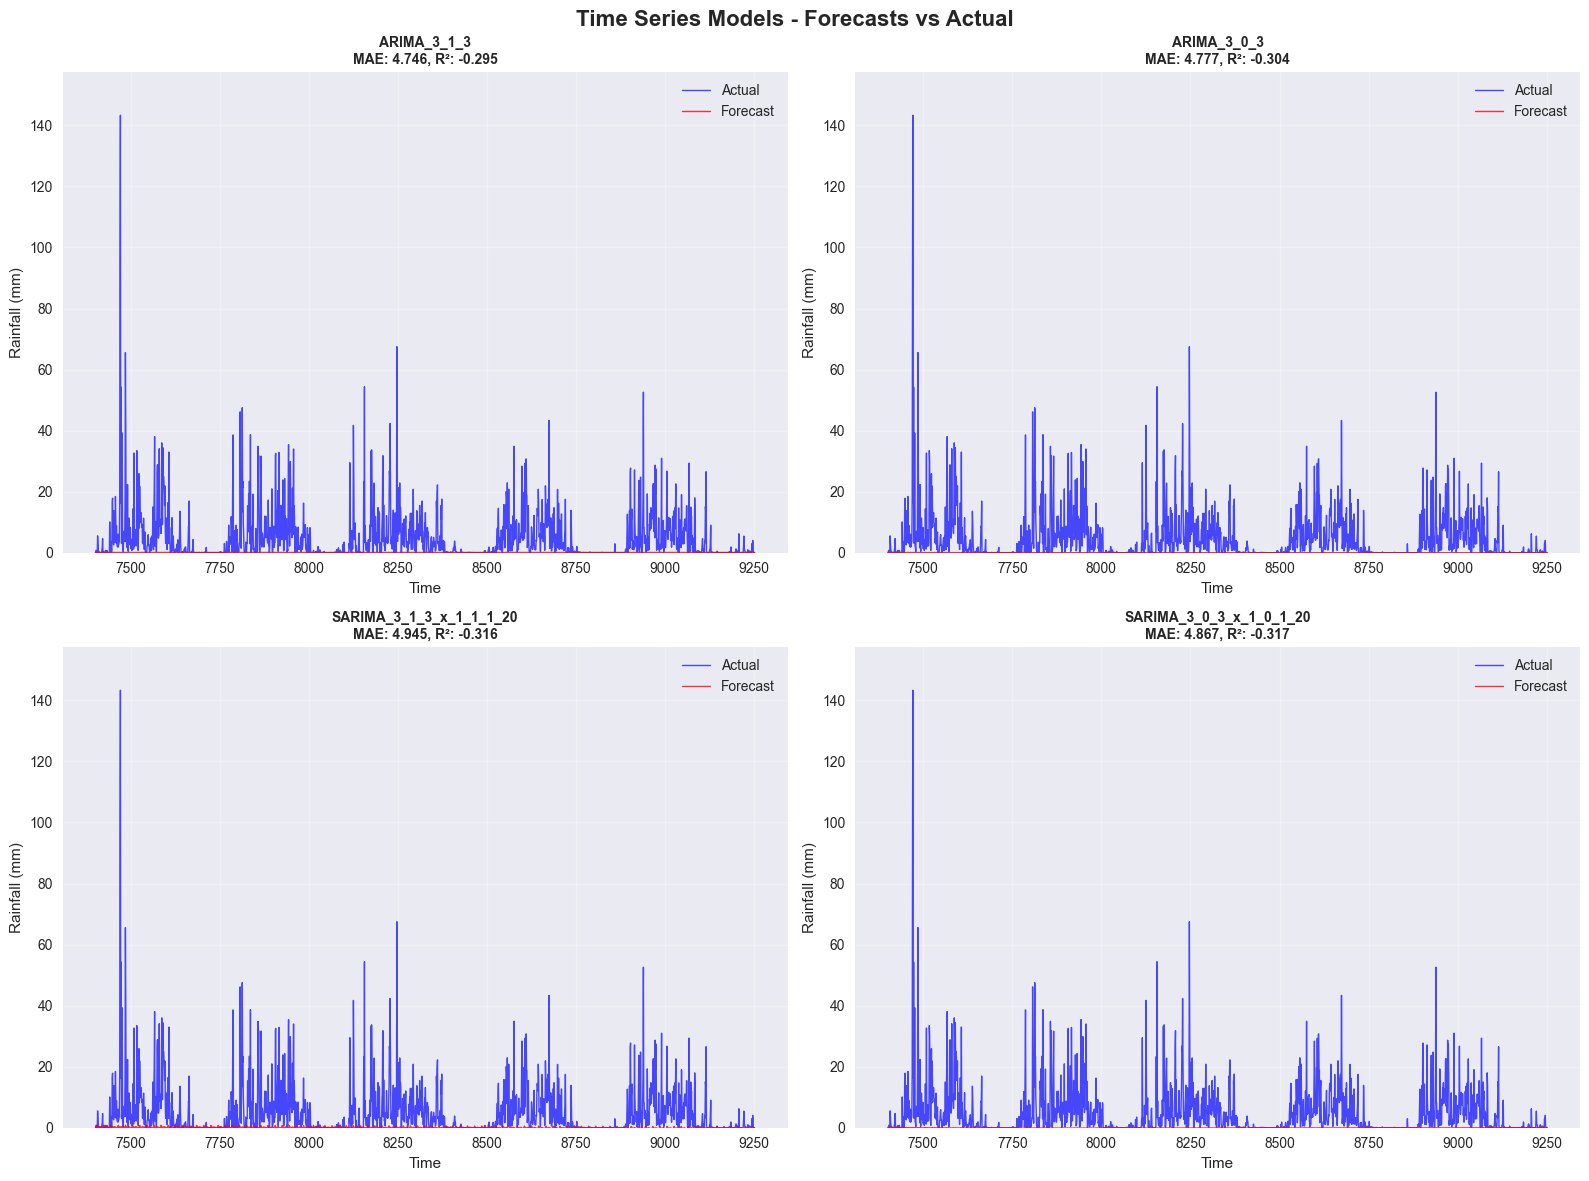


📊 FORECAST SUMMARY:
🔸 ARIMA_3_1_3:
   MAE: 4.7464 mm
   RMSE: 9.8426 mm
   R²: -0.2954
🔸 ARIMA_3_0_3:
   MAE: 4.7767 mm
   RMSE: 9.8764 mm
   R²: -0.3043
🔸 SARIMA_3_1_3_x_1_1_1_20:
   MAE: 4.9451 mm
   RMSE: 9.9196 mm
   R²: -0.3157
🔸 SARIMA_3_0_3_x_1_0_1_20:
   MAE: 4.8671 mm
   RMSE: 9.9245 mm
   R²: -0.3170
🔸 SARIMA_3_1_3_x_1_1_1_7:
   MAE: 6.1277 mm
   RMSE: 10.5516 mm
   R²: -0.4887
🔸 SARIMA_3_0_3_x_1_0_1_7:
   MAE: 4.7776 mm
   RMSE: 9.8773 mm
   R²: -0.3045

🏆 TIME SERIES CHAMPION:
🥇 Best Model: ARIMA_3_1_3
   • Type: ARIMA
   • Order: (3, 1, 3)
   • MAE: 4.7464 mm
   • RMSE: 9.8426 mm
   • R²: -0.2954
   • Training Time: 1.2s

✅ Time series models pipeline completed!
📅 End: 14:49:19


In [52]:
# =============================================================================
# TIME SERIES FORECASTS VISUALIZATION
# =============================================================================

print("\n📈 TIME SERIES FORECASTS VISUALIZATION")
print("="*60)

if not ts_comparison_df.empty and len([k for k, v in time_series_results.items() if 'forecasts' in v]) > 0:
    
    # Create forecasts visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Time Series Models - Forecasts vs Actual', fontsize=16, fontweight='bold')
    
    # Get successful models with forecasts
    successful_models = [(name, result) for name, result in time_series_results.items() 
                        if 'forecasts' in result and 'error' not in result]
    
    # Plot up to 4 best models
    models_to_plot = successful_models[:4]
    
    for idx, (model_name, result) in enumerate(models_to_plot):
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
        
        forecasts = result['forecasts']
        
        # Plot actual vs forecast
        ax.plot(y_test_for_models.index, y_test_for_models.values, 
               label='Actual', color='blue', alpha=0.7, linewidth=1)
        ax.plot(y_test_for_models.index, forecasts, 
               label='Forecast', color='red', alpha=0.8, linewidth=1)
        
        # Get metrics for title
        mae = result['evaluation'].get('MAE', 0)
        r2 = result['evaluation'].get('R2', 0)
        
        ax.set_title(f'{model_name}\nMAE: {mae:.3f}, R²: {r2:.3f}', fontsize=10, fontweight='bold')
        ax.set_xlabel('Time')
        ax.set_ylabel('Rainfall (mm)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Limit y-axis for better visualization
        ax.set_ylim(0, max(y_test_for_models.max(), np.max(forecasts)) * 1.1)
    
    # Hide empty subplots
    for idx in range(len(models_to_plot), 4):
        row = idx // 2
        col = idx % 2
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n📊 FORECAST SUMMARY:")
    print("="*60)
    
    for model_name, result in successful_models:
        if 'evaluation' in result:
            metrics = result['evaluation']
            print(f"🔸 {model_name}:")
            print(f"   MAE: {metrics.get('MAE', 0):.4f} mm")
            print(f"   RMSE: {metrics.get('RMSE', 0):.4f} mm")
            print(f"   R²: {metrics.get('R2', 0):.4f}")
    
    # Overall champion
    if not ts_comparison_df['MAE'].isna().all():
        best_overall = ts_comparison_df.loc[ts_comparison_df['MAE'].idxmin()]
        print(f"\n🏆 TIME SERIES CHAMPION:")
        print("="*40)
        print(f"🥇 Best Model: {best_overall['Model']}")
        print(f"   • Type: {best_overall['Type']}")
        print(f"   • Order: {best_overall['Order']}")
        if best_overall['Seasonal_Order'] != 'None':
            print(f"   • Seasonal Order: {best_overall['Seasonal_Order']}")
        print(f"   • MAE: {best_overall['MAE']:.4f} mm")
        print(f"   • RMSE: {best_overall['RMSE']:.4f} mm")
        print(f"   • R²: {best_overall['R2']:.4f}")
        print(f"   • Training Time: {best_overall['Training_Time']:.1f}s")

else:
    print("❌ No forecasts available for visualization")

print(f"\n✅ Time series models pipeline completed!")
print(f"📅 End: {datetime.now().strftime('%H:%M:%S')}")

## Neural Network Model